# Uncertainty analysis

Here we will demonstrate a full uncertainty analysis of the inversion. We use a stochastic approach, where we 1) choose the important input parameters to the inversion, 2) define each of there uncertainty distributions, 3) run a series of inversions which sample these inputs from their uncertainty distributions, and 4) use the ensemble of inverted topography models to define the mean result and the uncertainty.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging
import pathlib
import pickle
import string

import numpy as np
import verde as vd
import xarray as xr
from polartoolkit import maps, profiles
from polartoolkit import utils as polar_utils

from invert4geom import (
    plotting,
    regional,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Load results from notebook `Combining it all`

In [2]:
# load pickle files
params = []
with pathlib.Path("tmp/combining_it_all_results.pickle").open("rb") as file:
    while True:
        try:
            params.append(pickle.load(file))
        except EOFError:
            break
(
    grav_df,
    constraint_points,
    grids,
    inversion_results,
    kwargs,
    regional_grav_kwargs,
    starting_prisms,
) = params

In [3]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()
grav_df.describe()

northing      easting  upward  upper_surface_grav  \
count   1271.000000   1271.00000  1271.0         1271.000000   
mean   15000.000000  20000.00000  1001.0           -0.128879   
std     8947.792584  11836.81698     0.0            7.178884   
min        0.000000      0.00000  1001.0          -16.900446   
25%     7000.000000  10000.00000  1001.0           -5.504387   
50%    15000.000000  20000.00000  1001.0           -0.989422   
75%    23000.000000  30000.00000  1001.0            3.881698   
max    30000.000000  40000.00000  1001.0           19.952124   

       lower_surface_grav  observed_grav  gravity_anomaly  uncert  \
count         1271.000000    1271.000000      1271.000000  1271.0   
mean             0.027047      -0.101832        -0.101832     0.1   
std              2.154778       7.772302         7.771736     0.0   
min             -3.056356     -16.559656       -16.486998     0.1   
25%             -1.791650      -6.144526        -6.158828     0.1   
50%             -0.467373       0.048675         0.034049     0.1   
75%              1.619060       5.054484         5.030220     0.1   
max              4.926267      20.424284        20.490875     0.1   

       starting_gravity     true_res       misfit          reg          res  
count       1271.000000  1271.000000  1271.000000  1271.000000  1271.000000  
mean           1.196150    -1.325029    -1.297982    -0.704761    -0.593221  
std            6.435465     4.646786     5.118030     0.000000     5.118030  
min           -8.447402   -17.784897   -19.551590    -0.704761   -18.846829  
25%           -3.488058    -3.468661    -3.768814    -0.704761    -3.064053  
50%           -0.145297    -0.963446    -1.630367    -0.704761    -0.925606  
75%            4.683970     1.107829     0.946370    -0.704761     1.651130  
max           20.836752    10.999193    11.990728    -0.704761    12.695489

In [4]:
constraint_points.describe()

easting      northing  true_upward      upward     uncert  \
count     15.000000     15.000000    15.000000   15.000000  15.000000   
mean   18971.649226  16518.655913   483.571369  481.690685   9.671427   
std    10839.669022   8540.046257    76.125419   78.937423   1.522508   
min     3505.581182   1697.178371   393.845139  375.531097   7.876903   
25%    11575.107009  10553.975772   418.495999  421.417869   8.369920   
50%    19995.535031  16357.717739   473.663324  467.430002   9.473266   
75%    27651.208305  24233.535276   506.416871  503.933971  10.128337   
max    38163.601456  27603.626012   643.497514  645.115656  12.869950   

          weight  inverted_topography  
count  15.000000            15.000000  
mean    0.011376           483.408036  
std     0.003170            81.215691  
min     0.006037           389.444519  
25%     0.009754           409.589228  
50%     0.011143           476.867136  
75%     0.014278           510.753605  
max     0.016117           647.900228

In [5]:
true_topography = grids.true
lower_topography = grids.lower
starting_topography = grids.starting
final_topography = grids.inverted

In [6]:
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [7]:
kwargs

{'max_iterations': 200,
 'l2_norm_tolerance': 0.3,
 'delta_l2_norm_tolerance': 1.008}

In [8]:
regional_grav_kwargs["constraints_df"] = constraint_points
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 20,
  'damping_limits': (1e-20, 10),
  'progressbar': False,
  'fname': 'tmp/regional_sep'},
 'depth': 'default',
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   643.497514  645.115656  12.869950  0.006037   
 1   30636.914105   6974.789900   407.636336  406.559321   8.152727  0.015045   
 2   17659.550795  13659.470931   460.167715  466.061751   9.203354  0.011806   
 3   28491.676758  27073.768551   513.329953  514.406920  10.266599  0.009487   
 4   38163.601456   1697.178371   403.041503  398.723563   8.060830  0.015390   
 5   21462.843076  17815.369689   489.917983  493.461022   9.798360  0.010416   
 6   20042.577619  27603.626012   422.286895  433.300137   8.445738  0.014019   
 7    3737.943068   7448.480613   573.878441  584.748628  11.4

# Extract parameters

In [9]:
parameters

{'Density contrast(s)': '[2553.75757285] kg/m3',
 'Reference level': '481.69068459415365 m',
 'Max iterations': 200,
 'L2 norm tolerance': '0.3',
 'Delta L2 norm tolerance': '1.008',
 'Deriv type': 'annulus',
 'Solver type': 'scipy least squares',
 'Solver damping': 0.023439608400662986,
 'Upper confining layer': 'Not enabled',
 'Lower confining layer': 'Not enabled',
 'Regularization weighting grid': 'Not enabled',
 'Time elapsed': '1 seconds',
 'Avg. iteration time': '0.33 seconds',
 'Final misfit RMSE / L2-norm': '0.0475 /0.2179 mGal',
 'Termination reason': ['l2-norm tolerance'],
 'Iteration times': [0.3324565140064806,
  0.3304875419999007,
  0.3309231559978798]}

In [10]:
density_contrast = float(parameters["Density contrast(s)"][1:-7])
zref = float(parameters["Reference level"][:-2])
spacing = utils.get_spacing(grav_df)
region = vd.get_region((grav_df.easting, grav_df.northing))
solver_damping = parameters["Solver damping"]

print(f"Density contrast: {density_contrast} kg/m3")
print(f"Reference level: {zref} m")
print(f"Spacing: {spacing} m")
print(f"Region: {region}")
print(f"Solver damping: {solver_damping}")

Density contrast: 2553.75757285 kg/m3
Reference level: 481.69068459415365 m
Spacing: 1000.0 m
Region: (np.float64(0.0), np.float64(40000.0), np.float64(0.0), np.float64(30000.0))
Solver damping: 0.023439608400662986


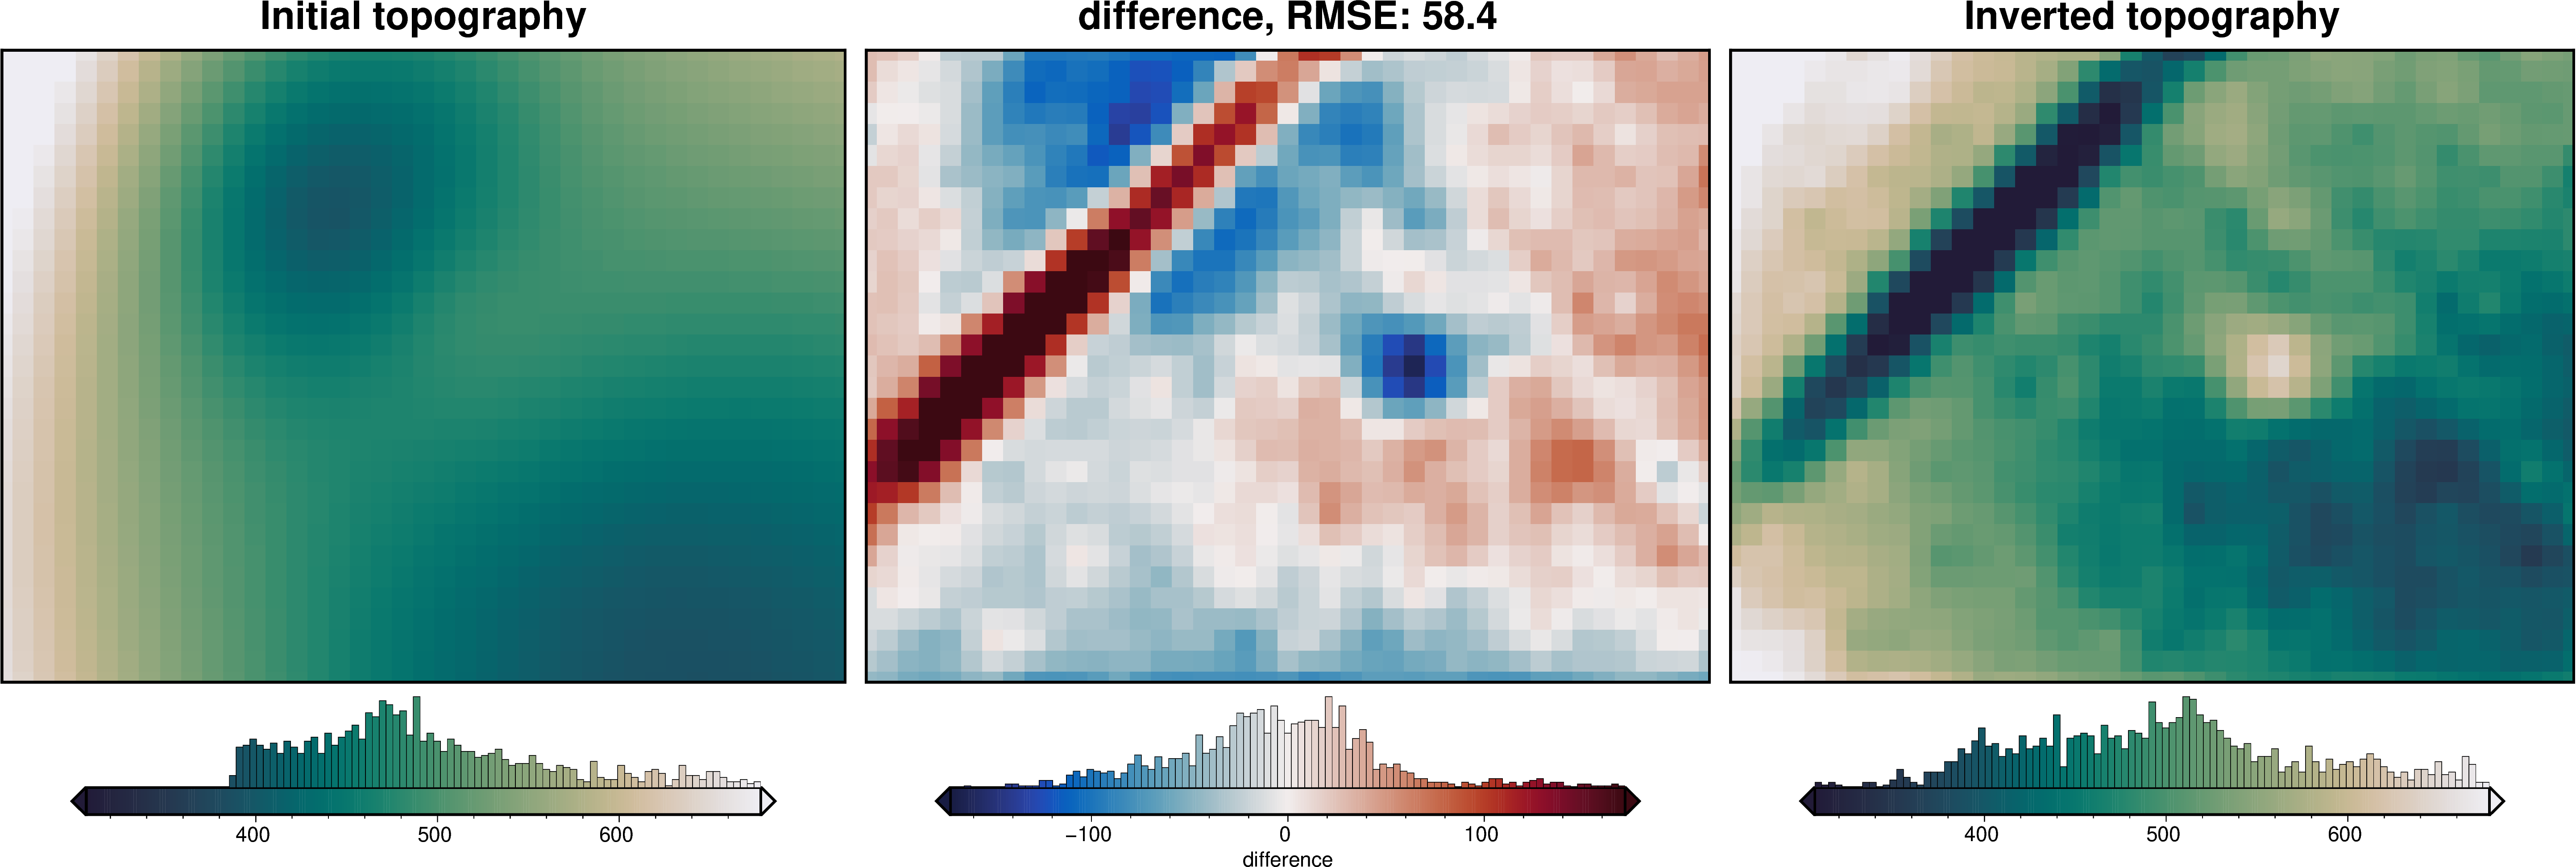

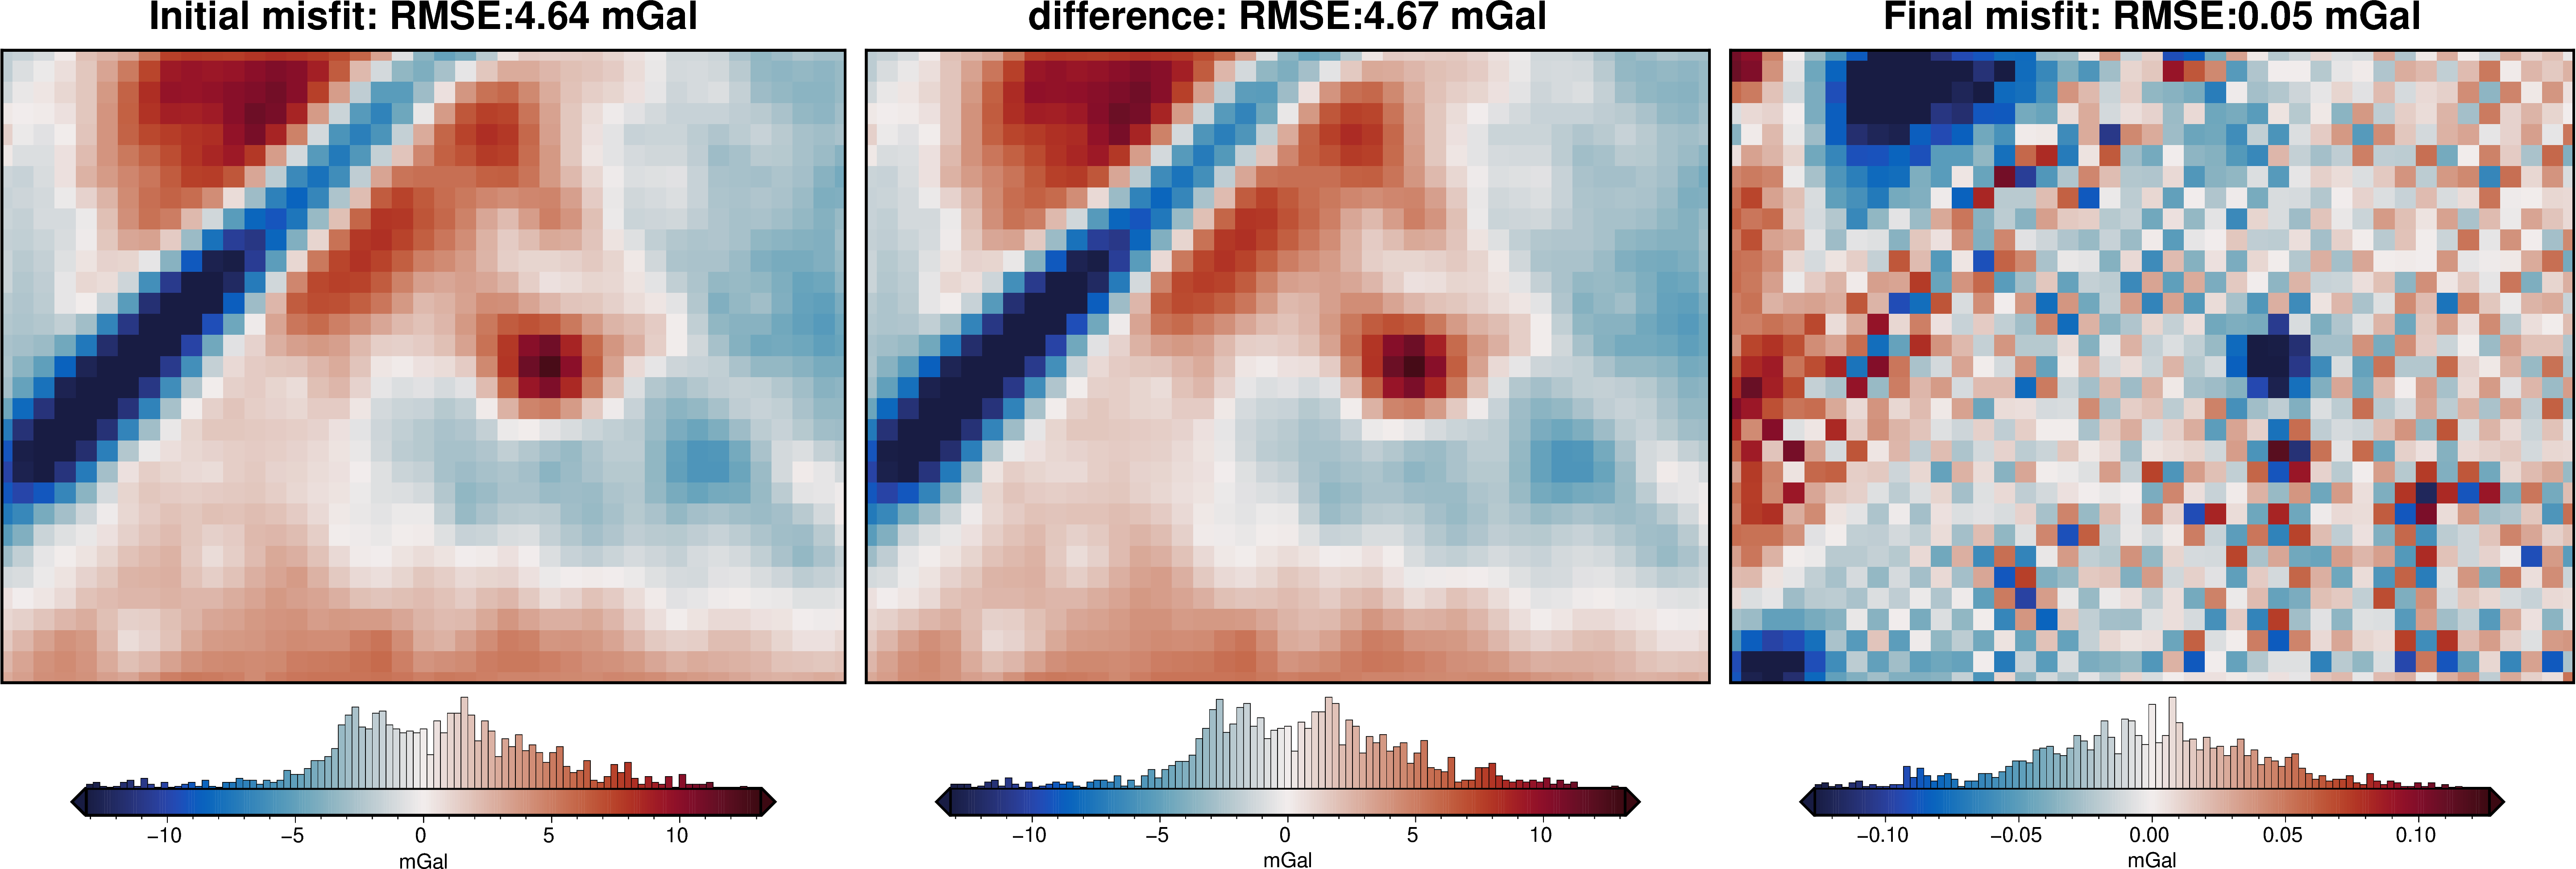

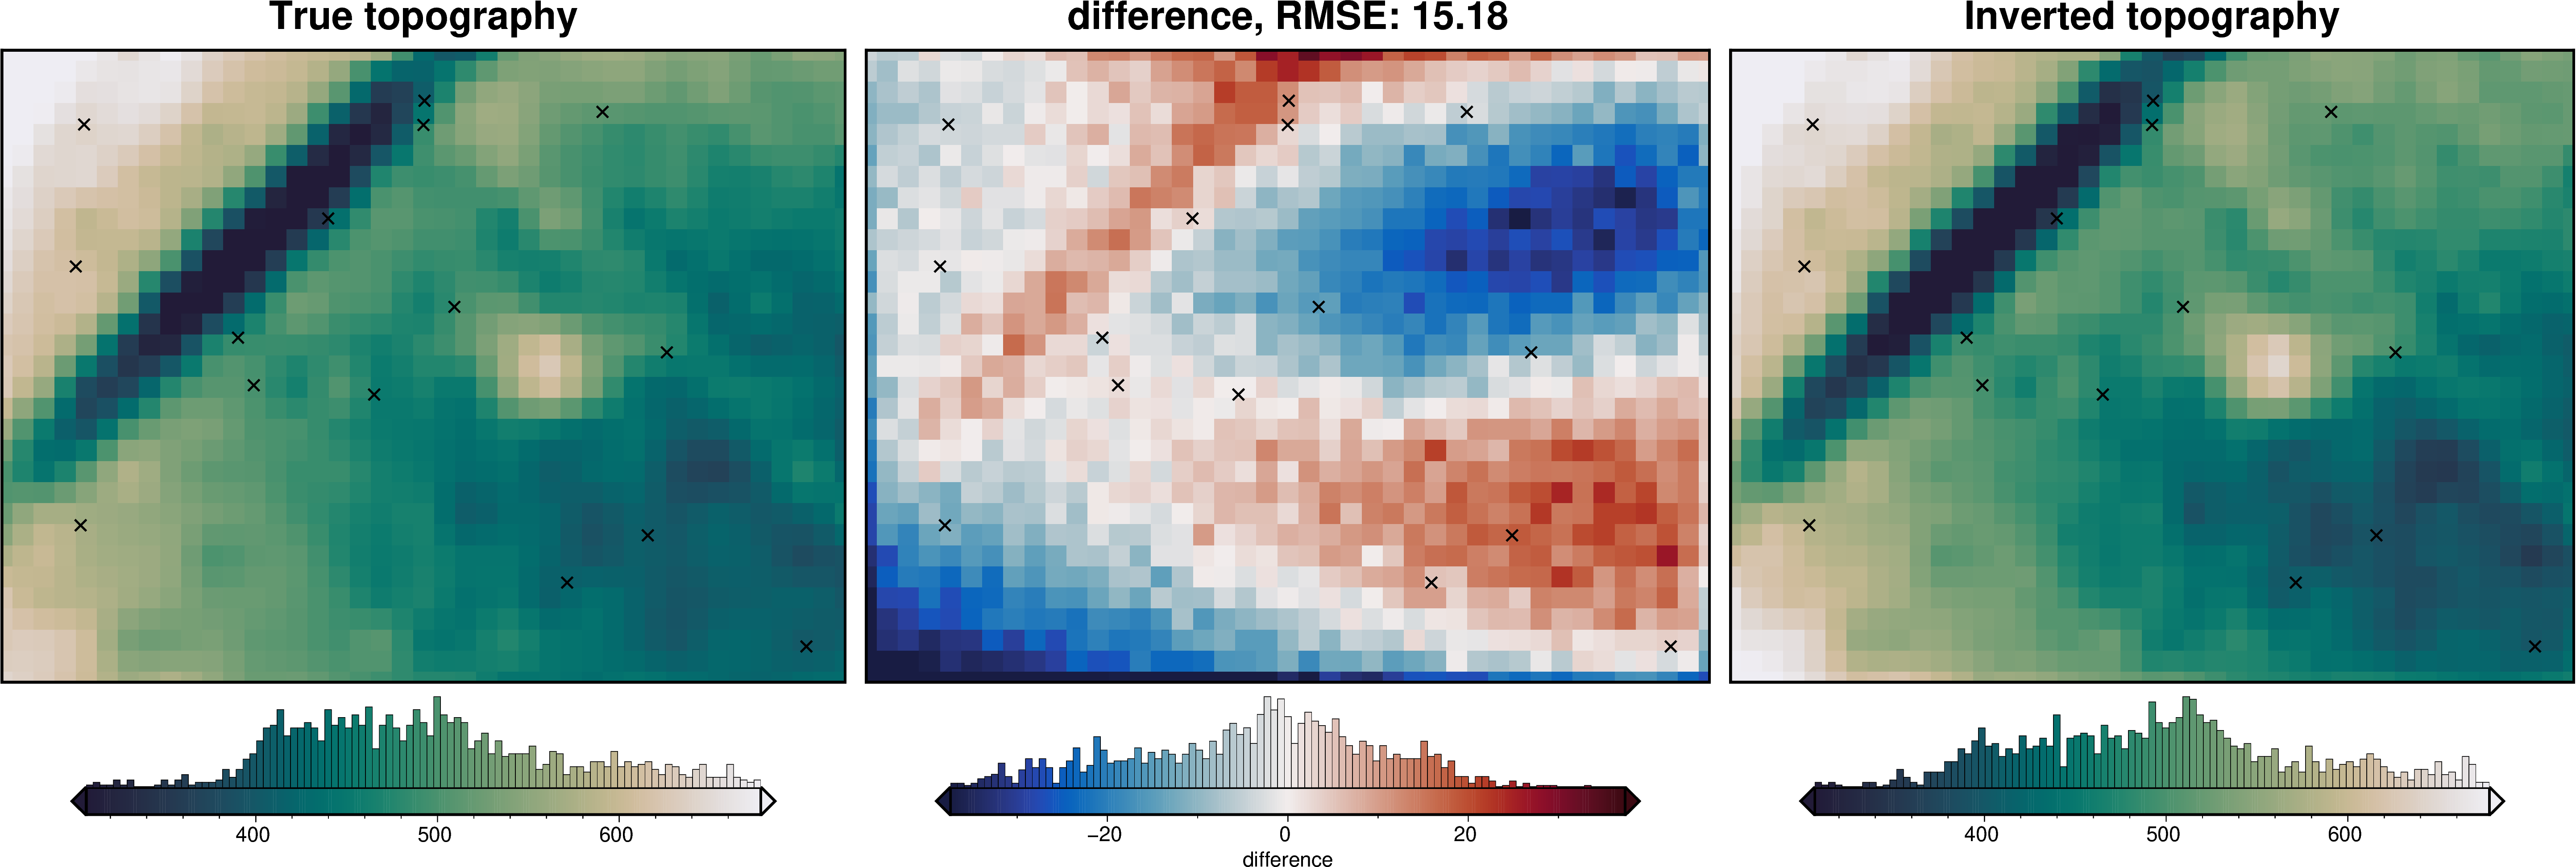

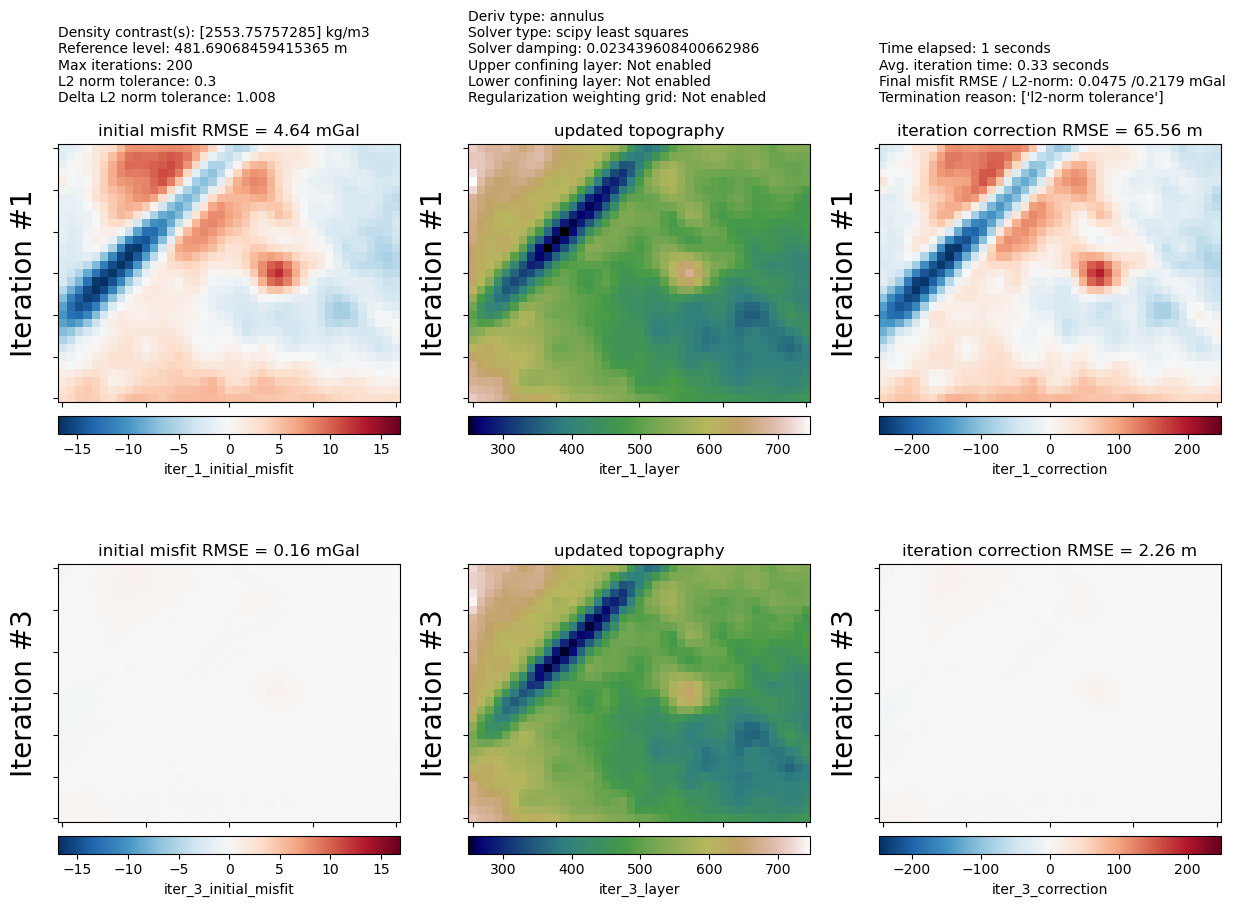

In [11]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

# Absolute value of inversion error

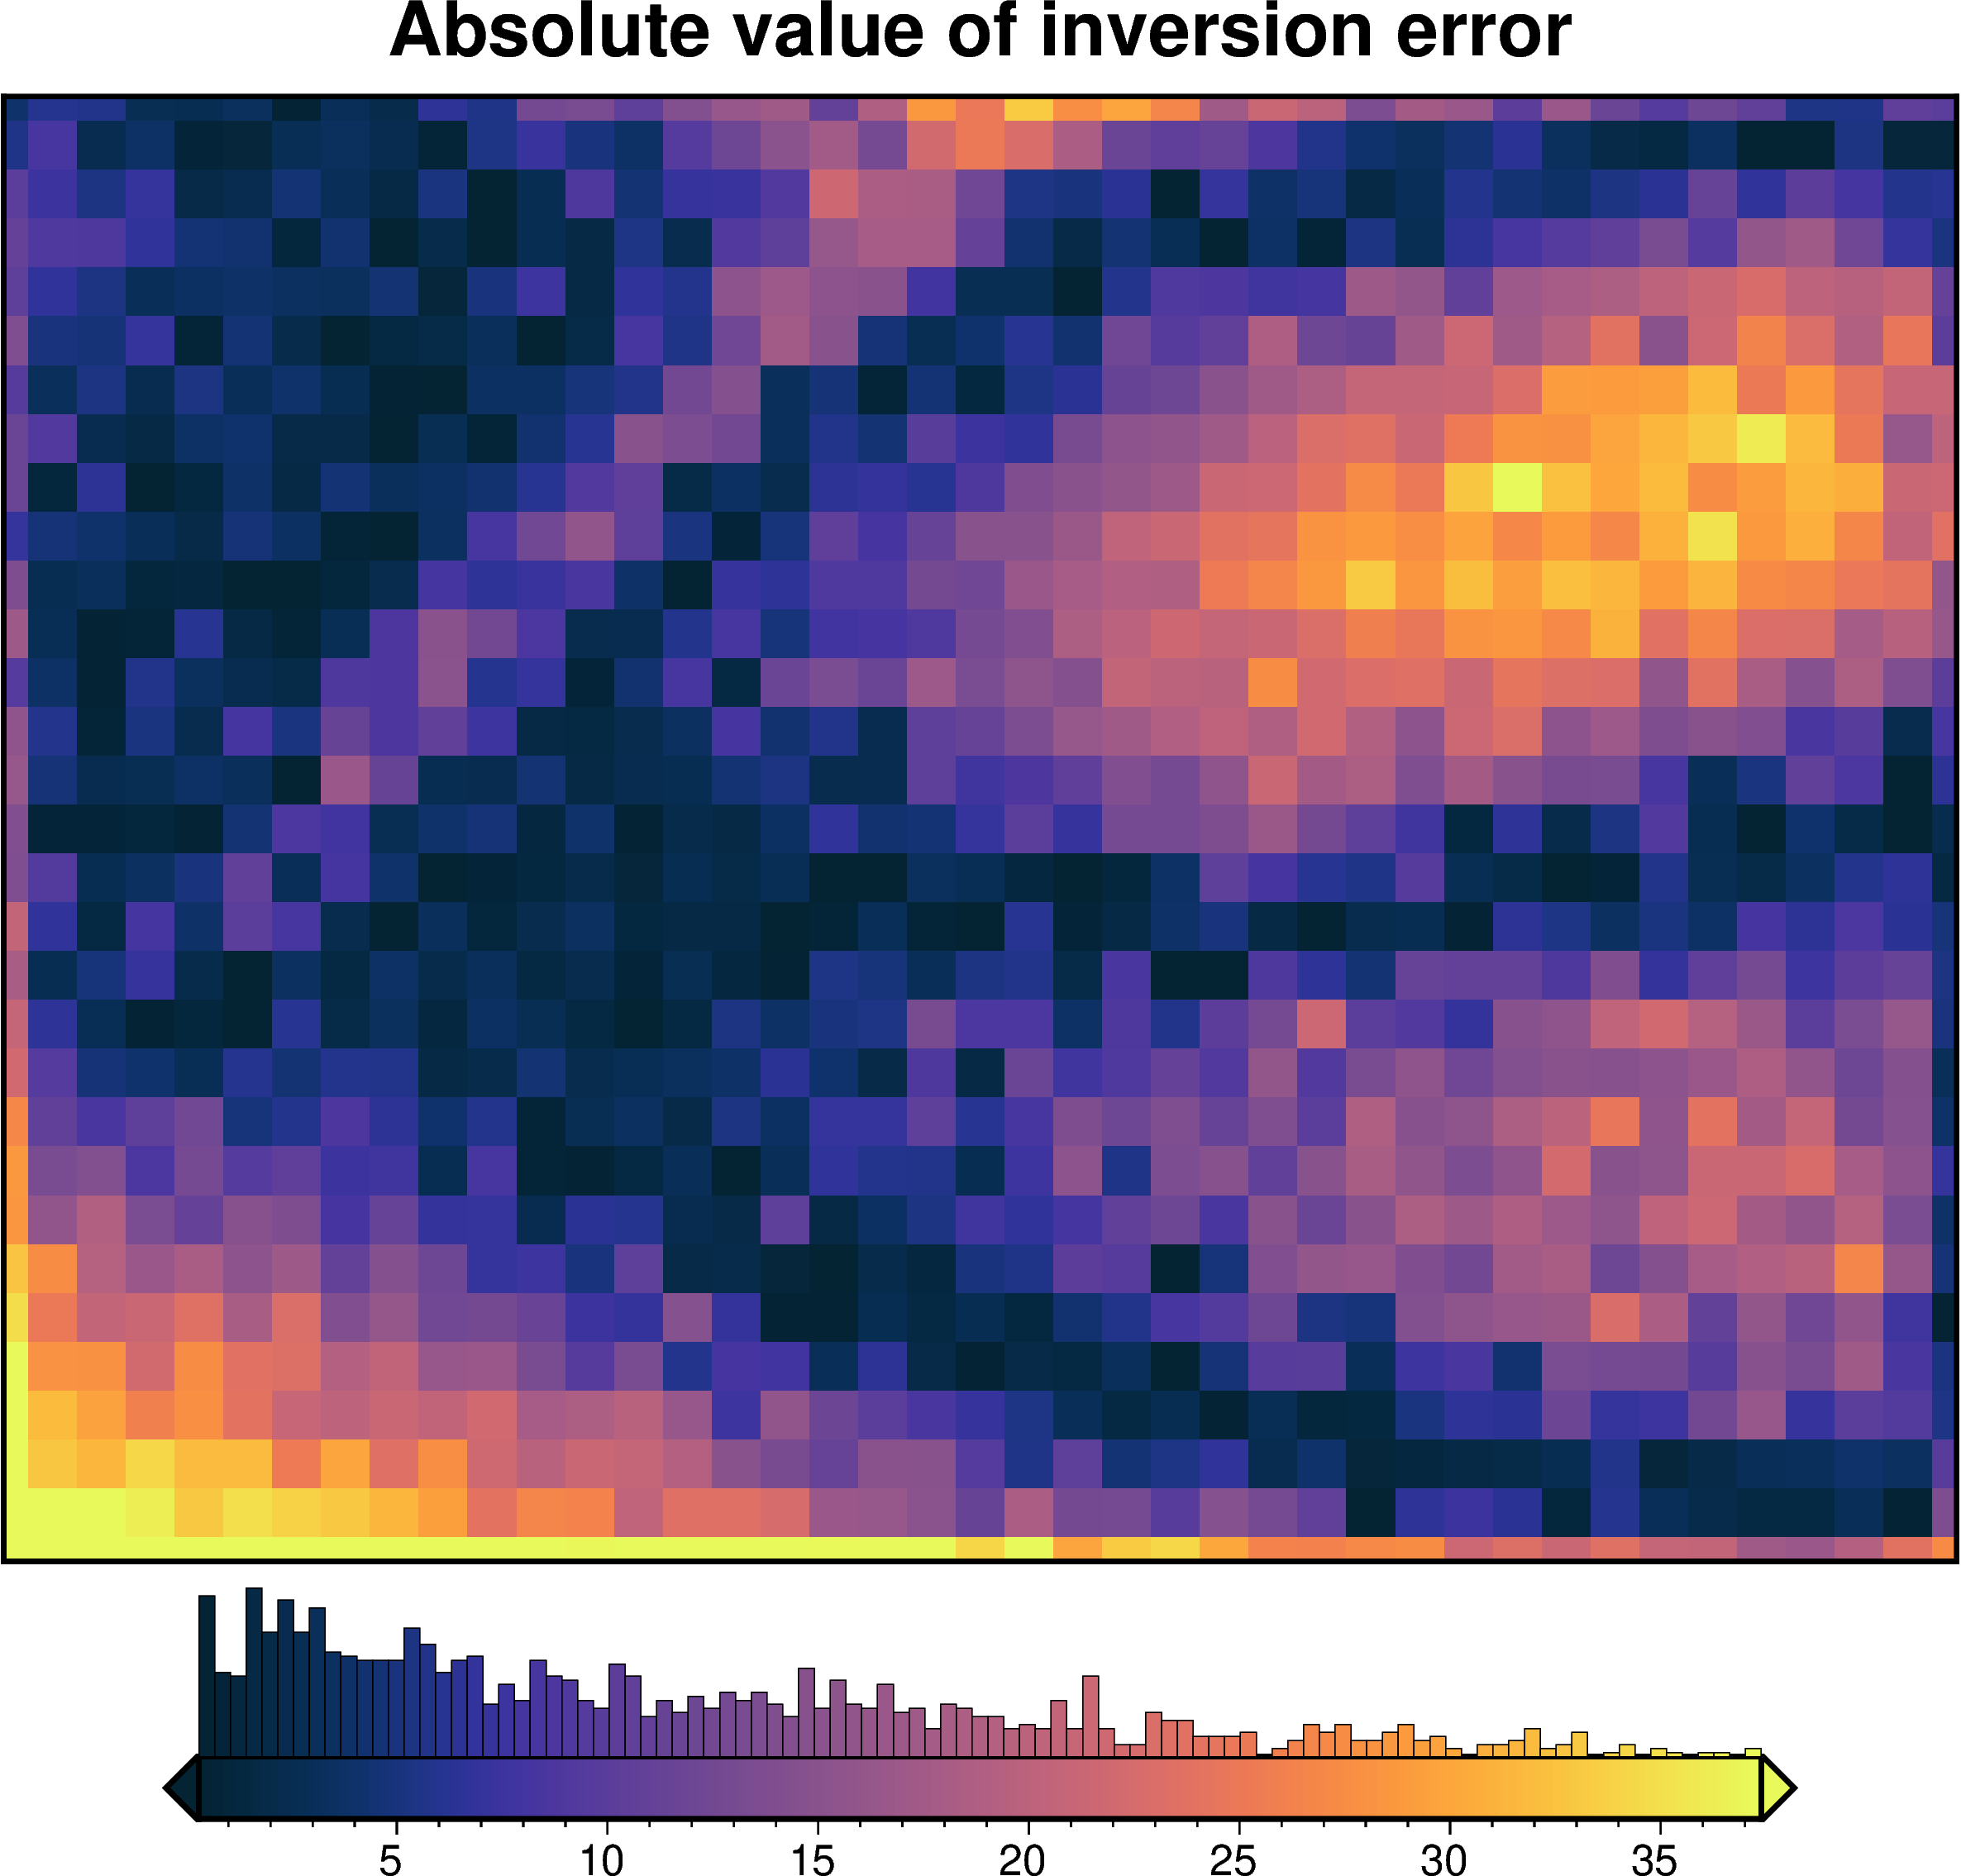

In [12]:
inversion_error = np.abs(true_topography - final_topography)
fig = maps.plot_grd(
    inversion_error,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
)
fig.show()

# Uncertainty analysis

## Starting topography uncertainty

Here we will estimate an uncertainty distribution for the spline damping value used in creating the starting topography.We then re-create the starting topography a number of times, each using a randomly sampled value for the the damping parameter from within it's uncertainty range. The cell-wise standard deviation of this ensemble will give us an idea of the uncertainty of the starting topography generation. Each repetition of the ensemble will also randomly sample the constraint depths from within their uncertainties.

In [13]:
# get best damping value used when creating grid
best_spline_damping = starting_topography.attrs["damping"]
best_spline_damping

np.float64(2.205130739903059e-06)

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 4.1006816132597525e-06, min: 1.6700634815635513e-07, max: 2.9116267936790854e-05


starting topography ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

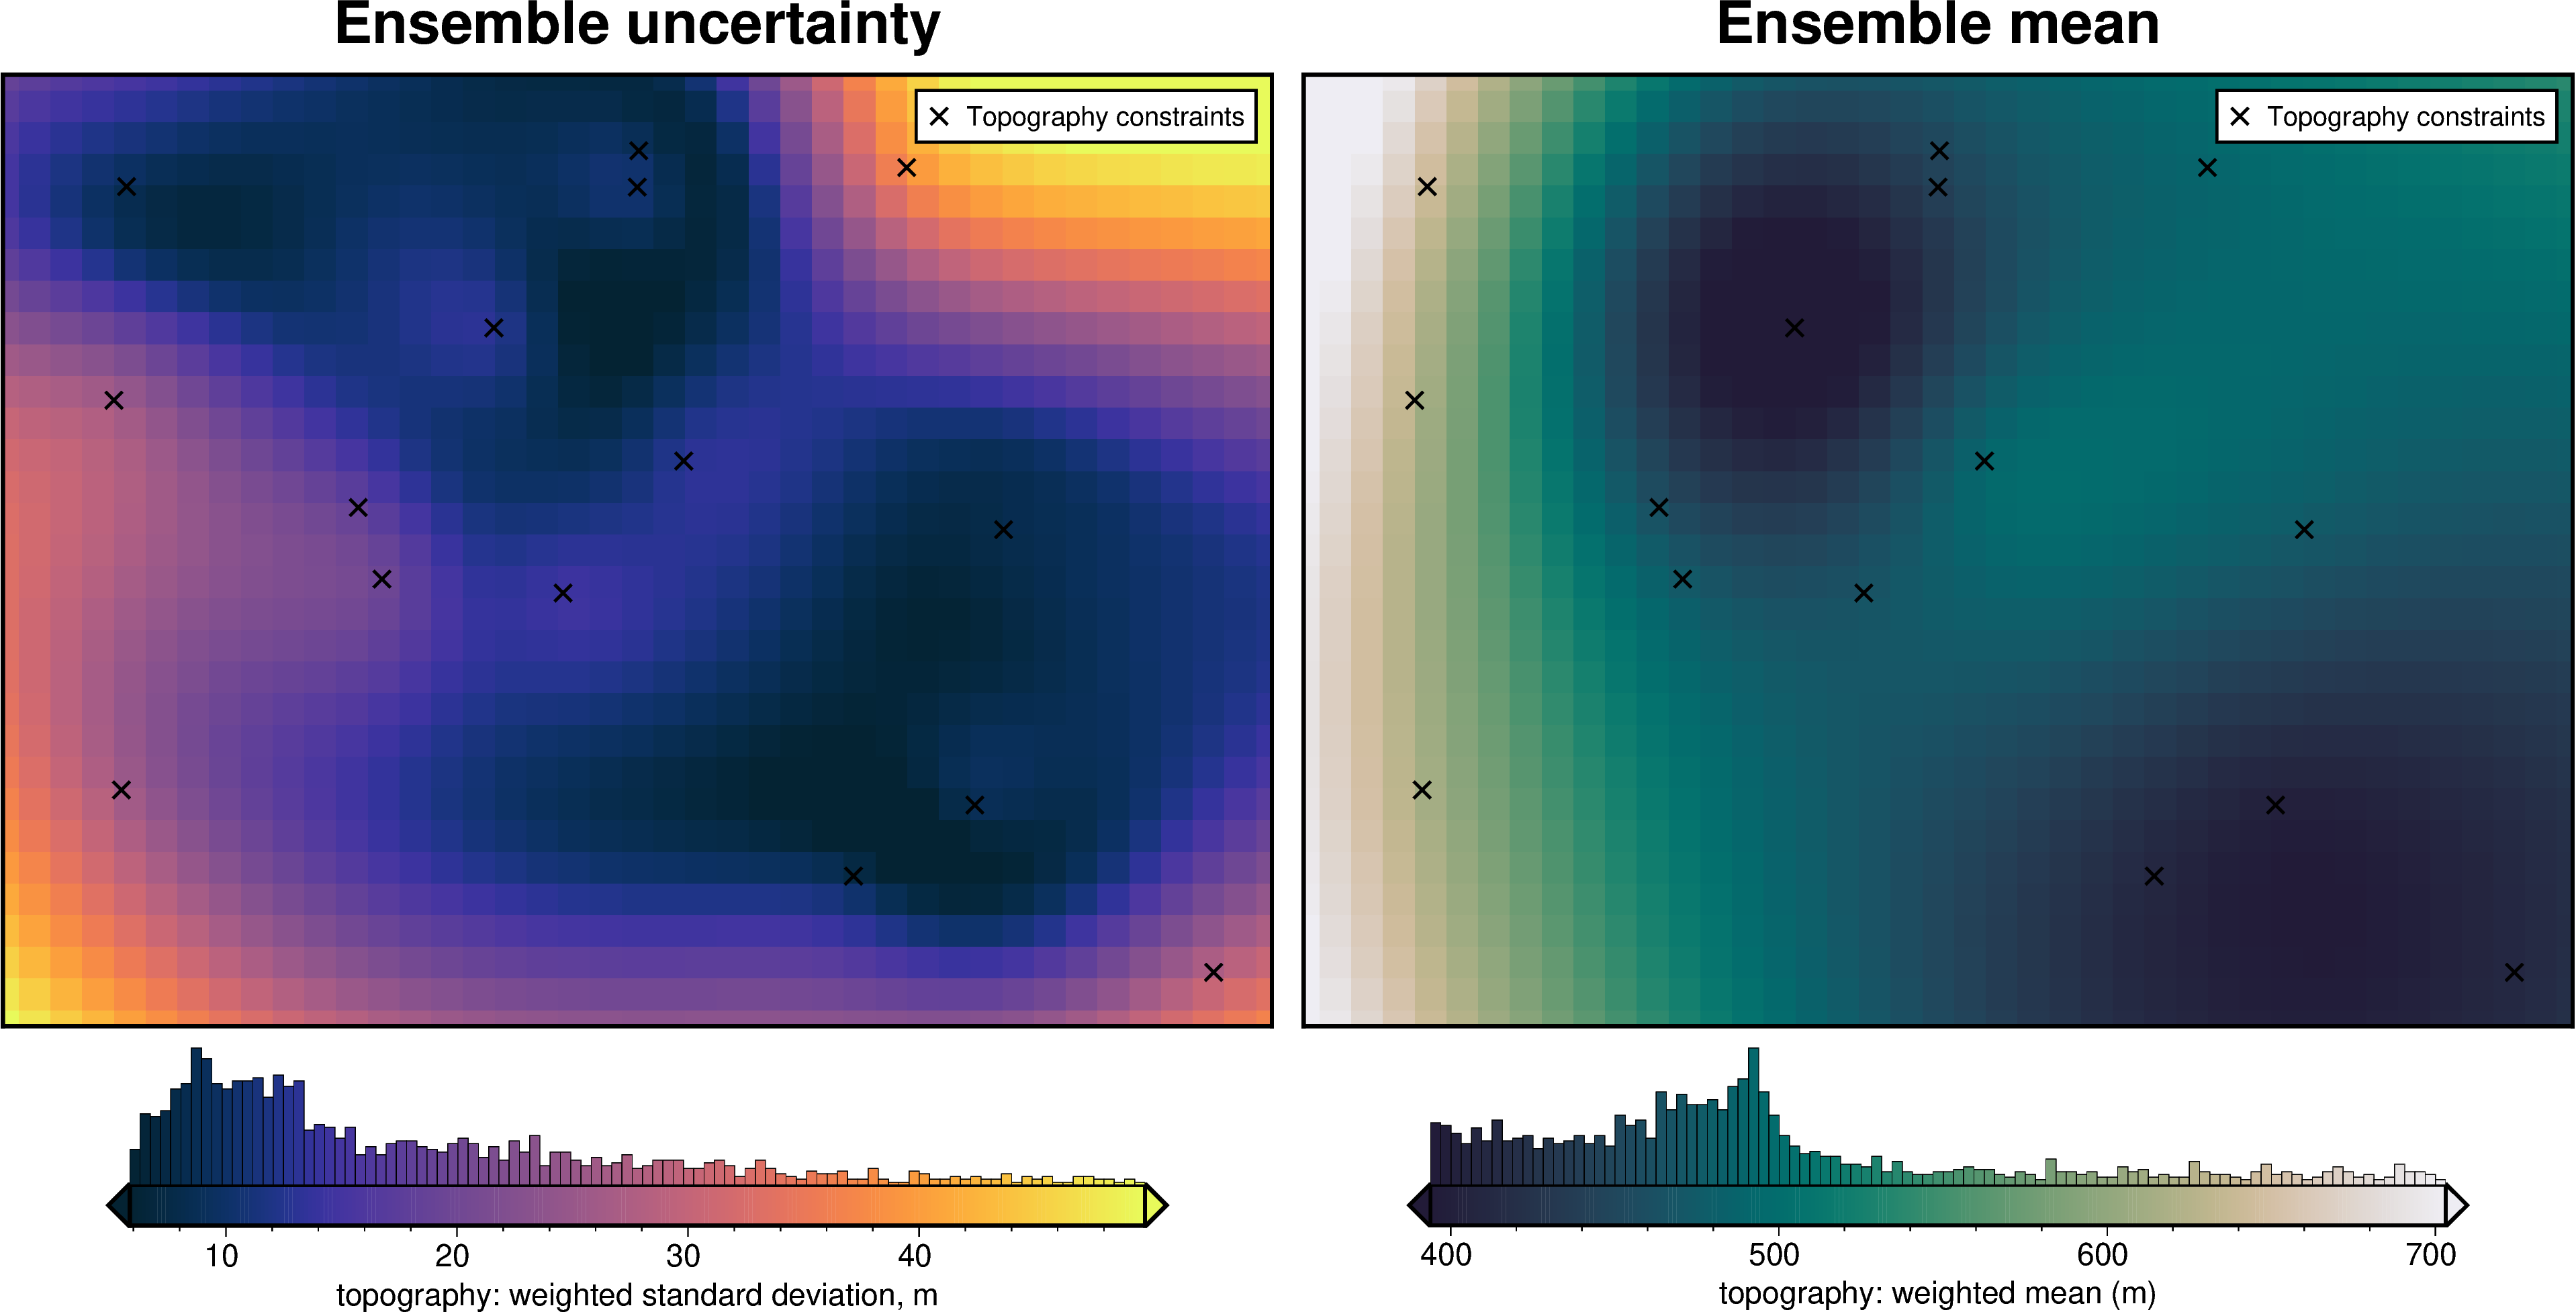

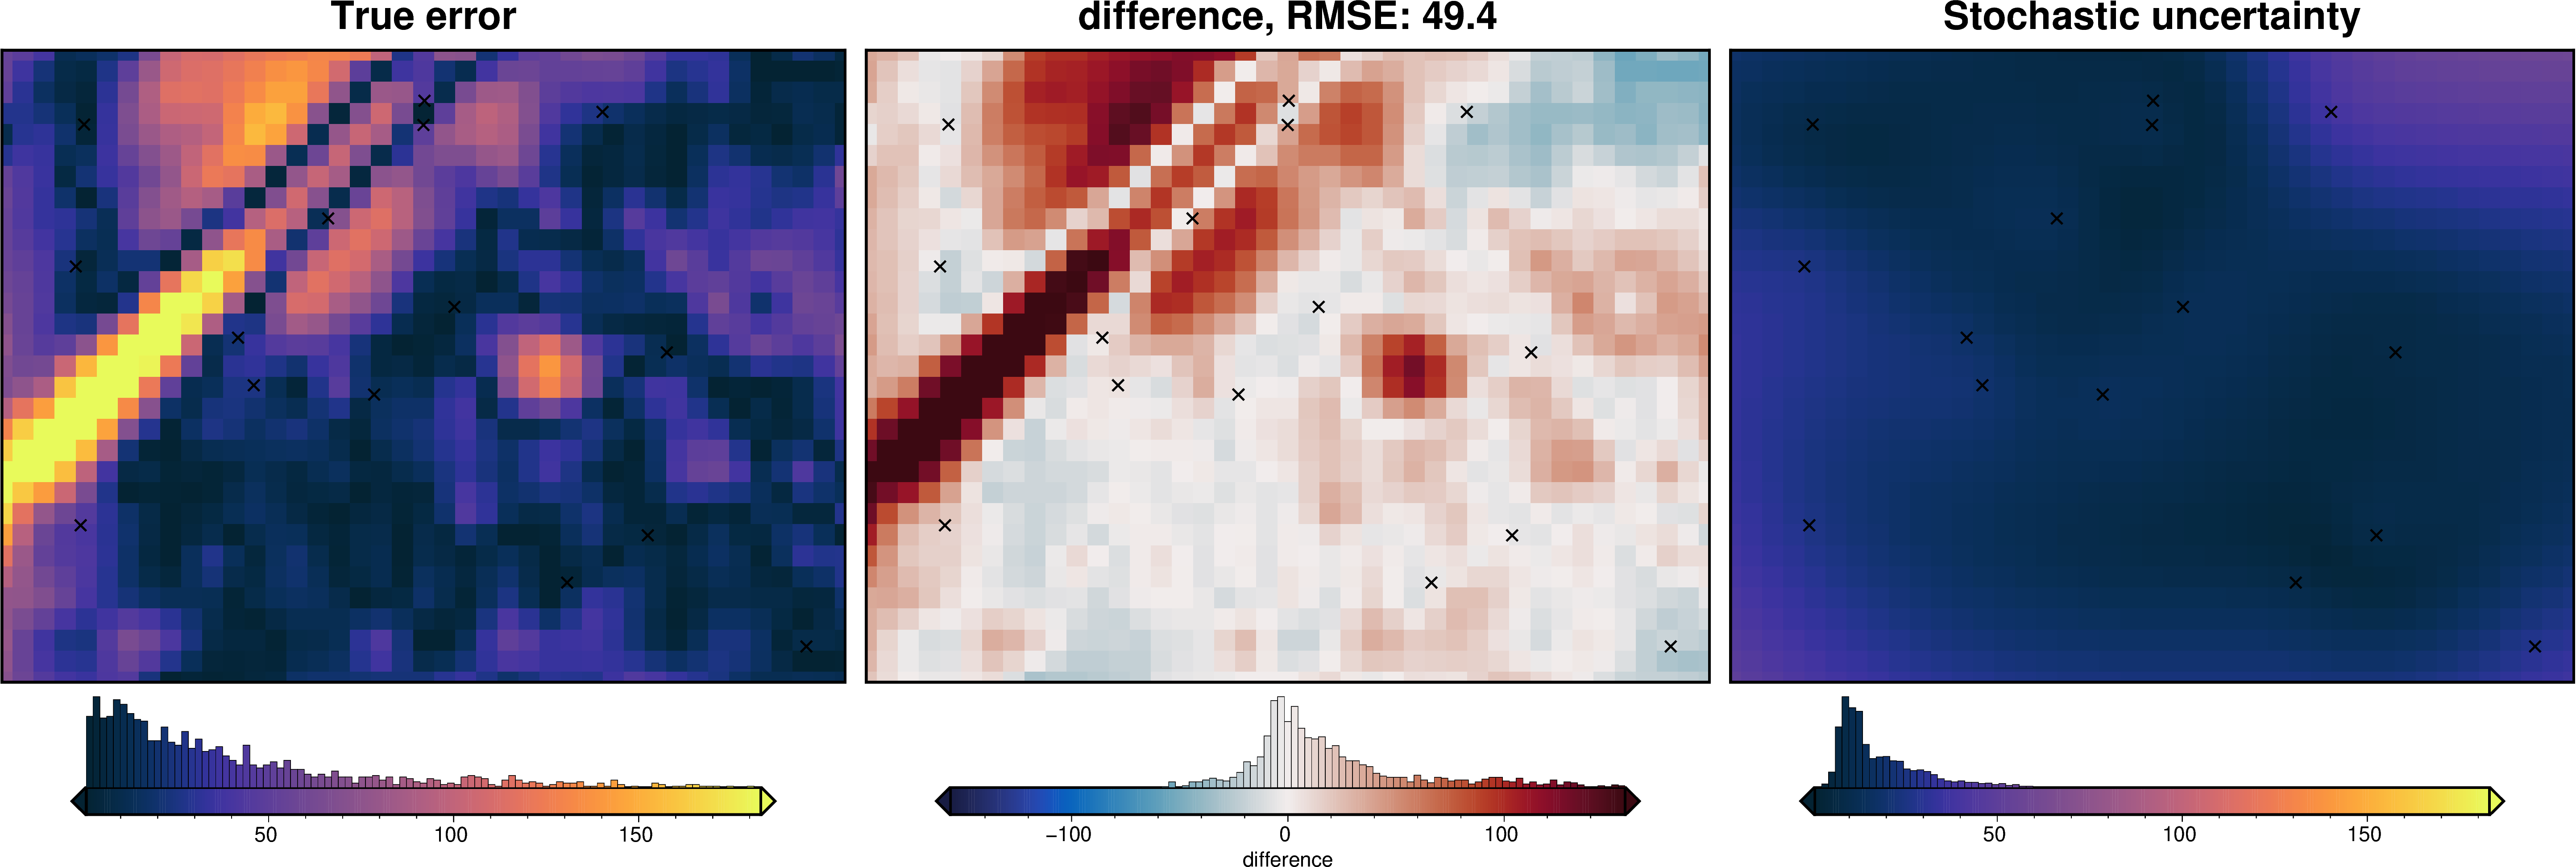

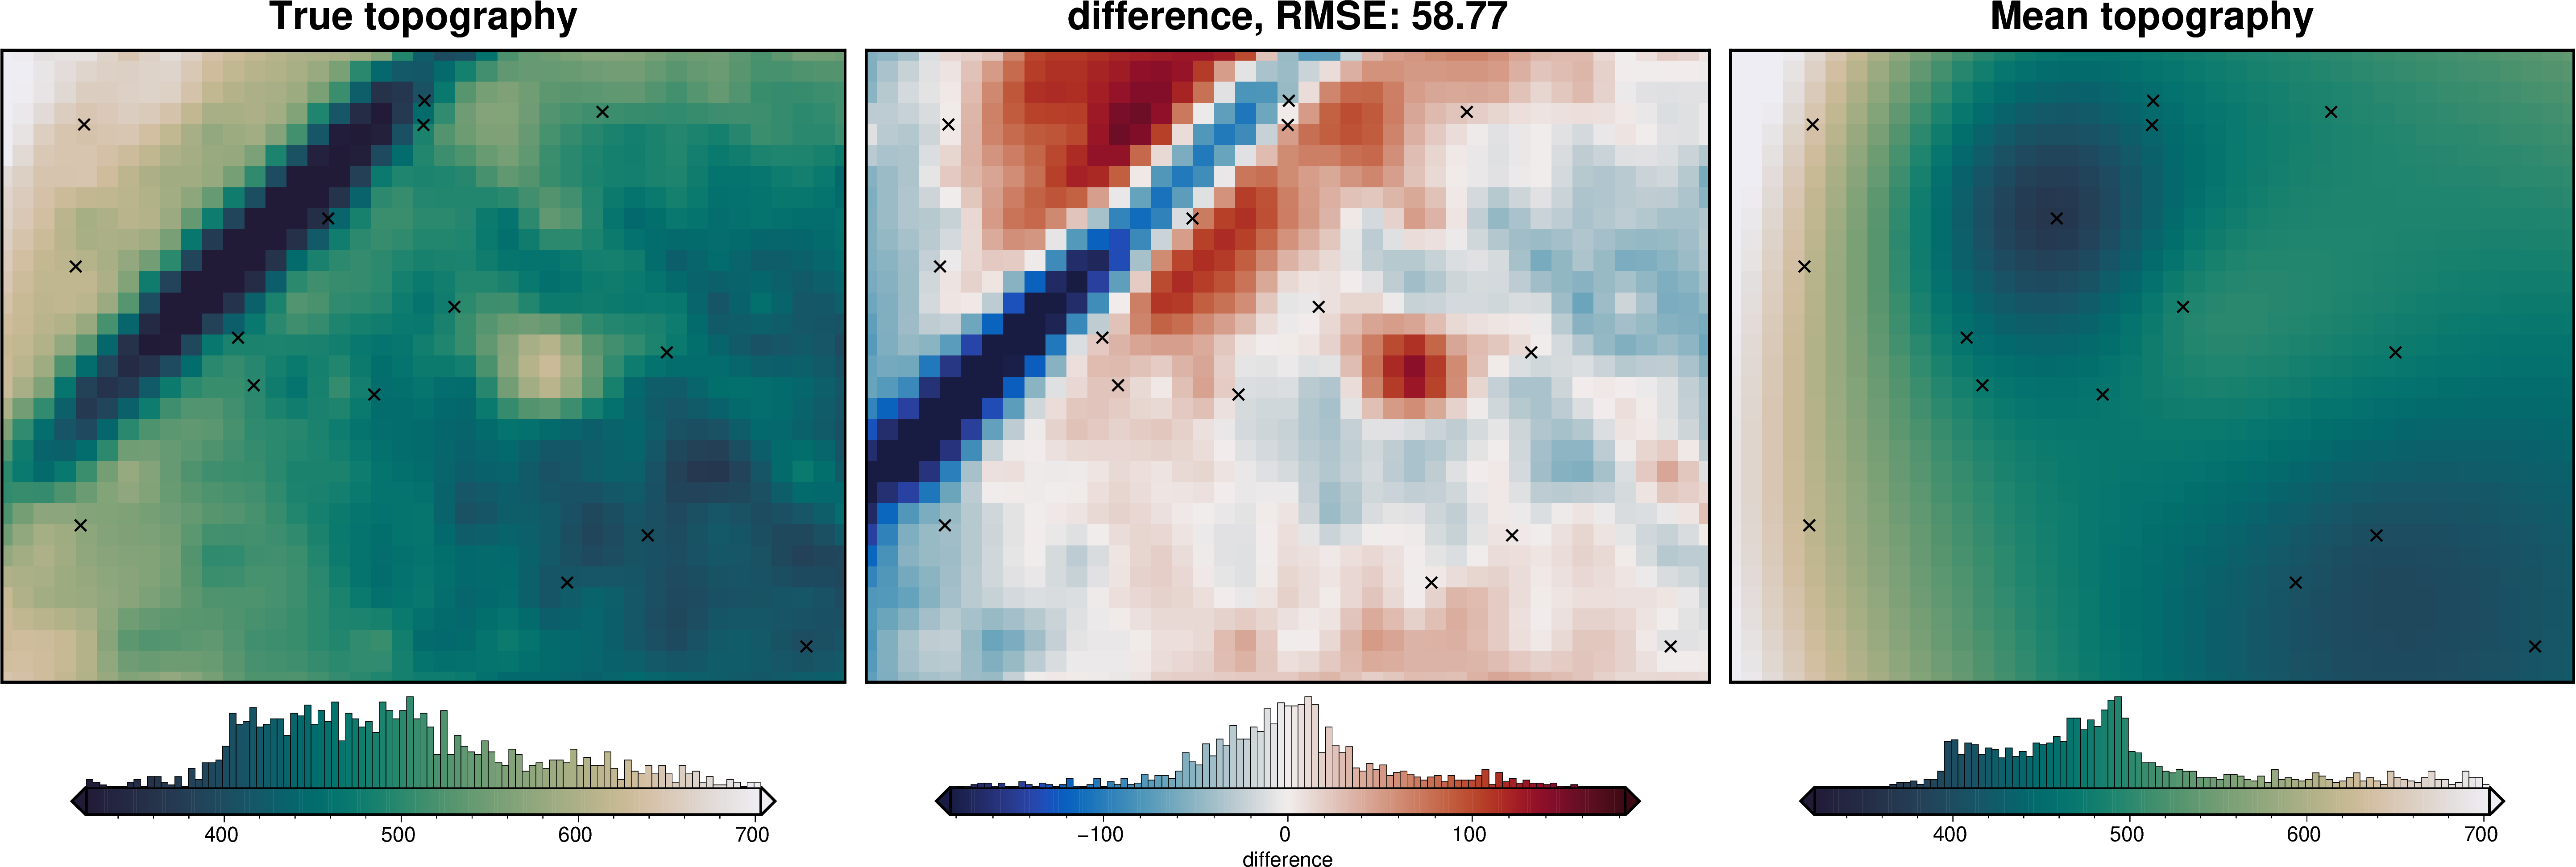

In [14]:
starting_topography_parameter_dict = {
    "dampings": {
        "distribution": "normal",
        "loc": np.log10(best_spline_damping),  # mean; base 10 exponent
        "scale": 0.5,  # standard deviation of exponent
        "log": True,
    },
}

starting_topo_stats = uncertainty.starting_topography_uncertainty(
    runs=40,
    sample_constraints=True,
    parameter_dict=starting_topography_parameter_dict,
    method="splines",
    dampings=best_spline_damping,
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    weights=constraint_points.weight,
    plot_region=region,
    true_topography=true_topography,
)

## Regional field estimation uncertainty

We will do the same thing for the regional estimation procedure. First we will re-separate the regional to see what equivalent source gridding parameter values were determined optimal. We then estimate an uncertainty distribution for these parameter values, and create an ensemble of regional models which each randomly sample both the parameter values and the gravity data. 

In [16]:
regional_grav_kwargs

{'method': 'constraints',
 'grid_method': 'eq_sources',
 'constraints_weights_column': 'weight',
 'cv': True,
 'cv_kwargs': {'n_trials': 20,
  'damping_limits': (1e-20, 10),
  'progressbar': False,
  'fname': 'tmp/regional_sep'},
 'depth': 'default',
 'block_size': None,
 'constraints_df':          easting      northing  true_upward      upward     uncert    weight  \
 0    3899.714996  26468.618776   643.497514  645.115656  12.869950  0.006037   
 1   30636.914105   6974.789900   407.636336  406.559321   8.152727  0.015045   
 2   17659.550795  13659.470931   460.167715  466.061751   9.203354  0.011806   
 3   28491.676758  27073.768551   513.329953  514.406920  10.266599  0.009487   
 4   38163.601456   1697.178371   403.041503  398.723563   8.060830  0.015390   
 5   21462.843076  17815.369689   489.917983  493.461022   9.798360  0.010416   
 6   20042.577619  27603.626012   422.286895  433.300137   8.445738  0.014019   
 7    3737.943068   7448.480613   573.878441  584.748628  11.4

In [17]:
# use the constraints to find the best regional field
_ = regional.regional_separation(grav_df=grav_df, **regional_grav_kwargs)

# re-load the study from the saved pickle file
with pathlib.Path(f"{regional_grav_kwargs.get("cv_kwargs").get("fname")}.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)
eq_damping = min(study.best_trials, key=lambda t: t.values[0]).params["damping"]
eq_damping

INFO:invert4geom:Current trial (#6, {'damping': 6.847029820277194e-12}) has a worse score (-4.015763263397727) than either of the lower (-4.006909045502178) or upper (-1.4938885595795273) parameter value limits, it might be best to stop the study and expand the limits.
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 13
INFO:invert4geom:	parameter: {'damping': 0.018864315575478324}
INFO:invert4geom:	scores: [0.10454463882702174]


0.018864315575478324

In [18]:
# if depth="default" in EquivalentSources, it will use 4.5 times the mean distances
# between nearest points as the depth
# calculate that mean distance below.
mean_constraint_distance = np.mean(
    vd.median_distance(
        (constraint_points.easting, constraint_points.northing), k_nearest=1
    )
)
mean_constraint_distance

np.float64(5599.156508868462)

INFO:invert4geom:Sampled 'depth' parameter values; mean: 23796.415162690966, min: 14242.85436943415, max: 33349.97595594778
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.17844834777023494, min: 0.00010820275667091313, max: 3.2888478360449915


starting regional ensemble:   0%|          | 0/40 [00:00<?, ?it/s]

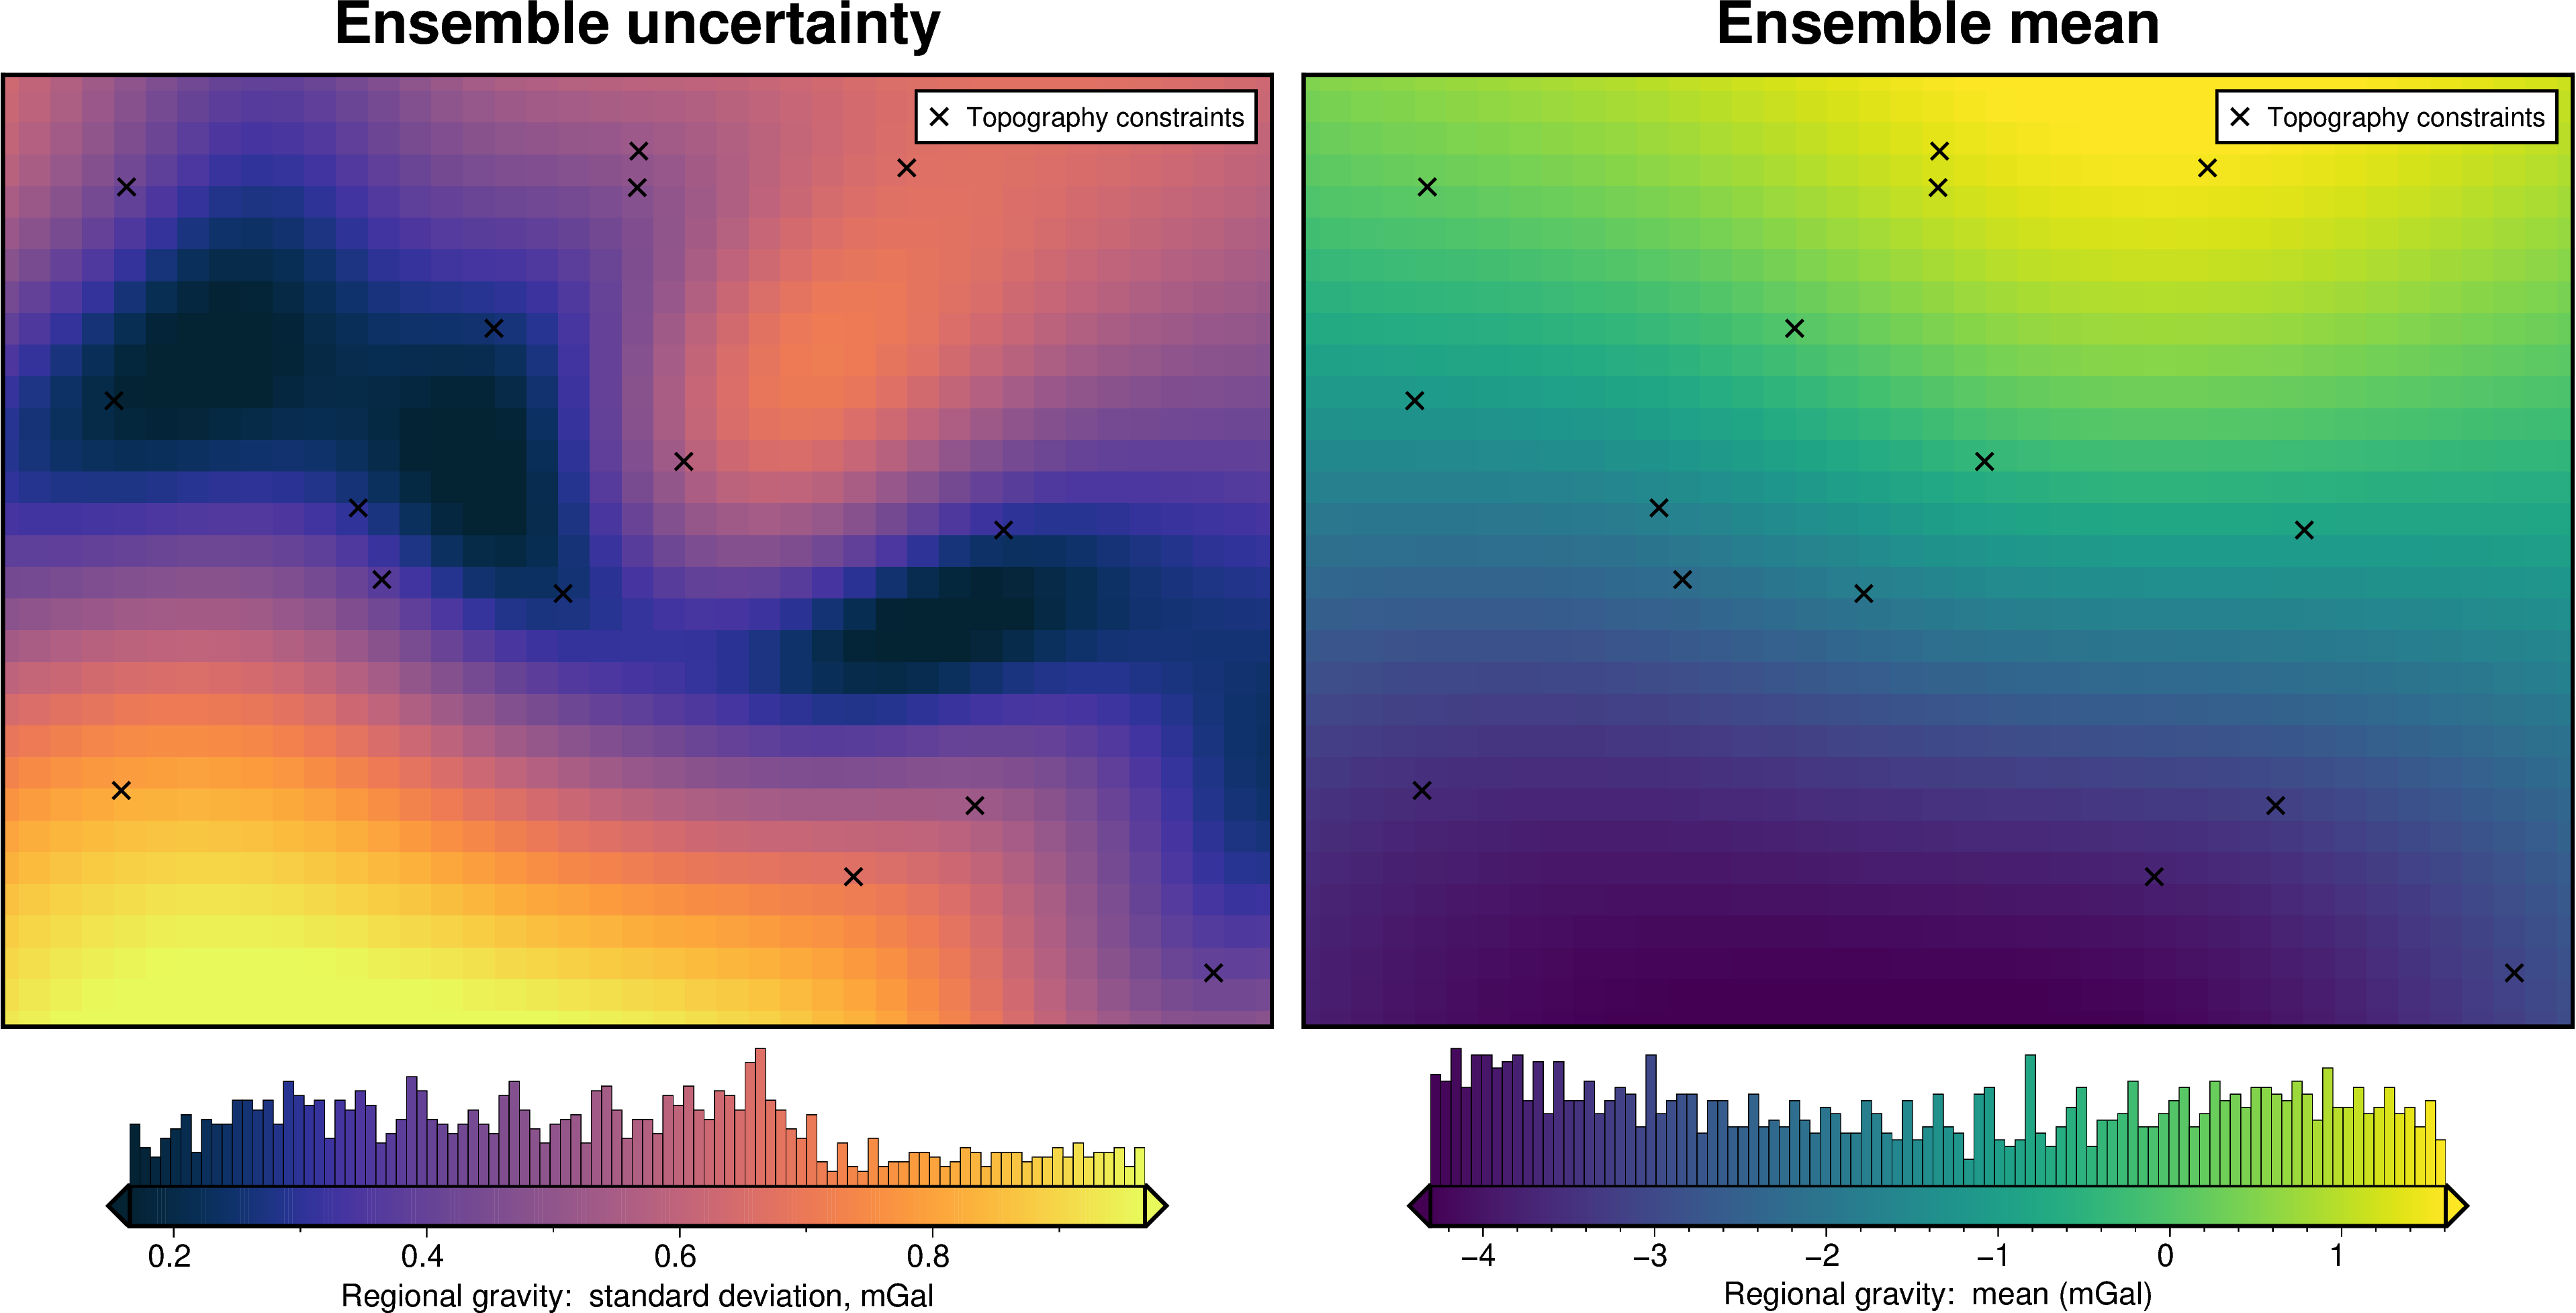

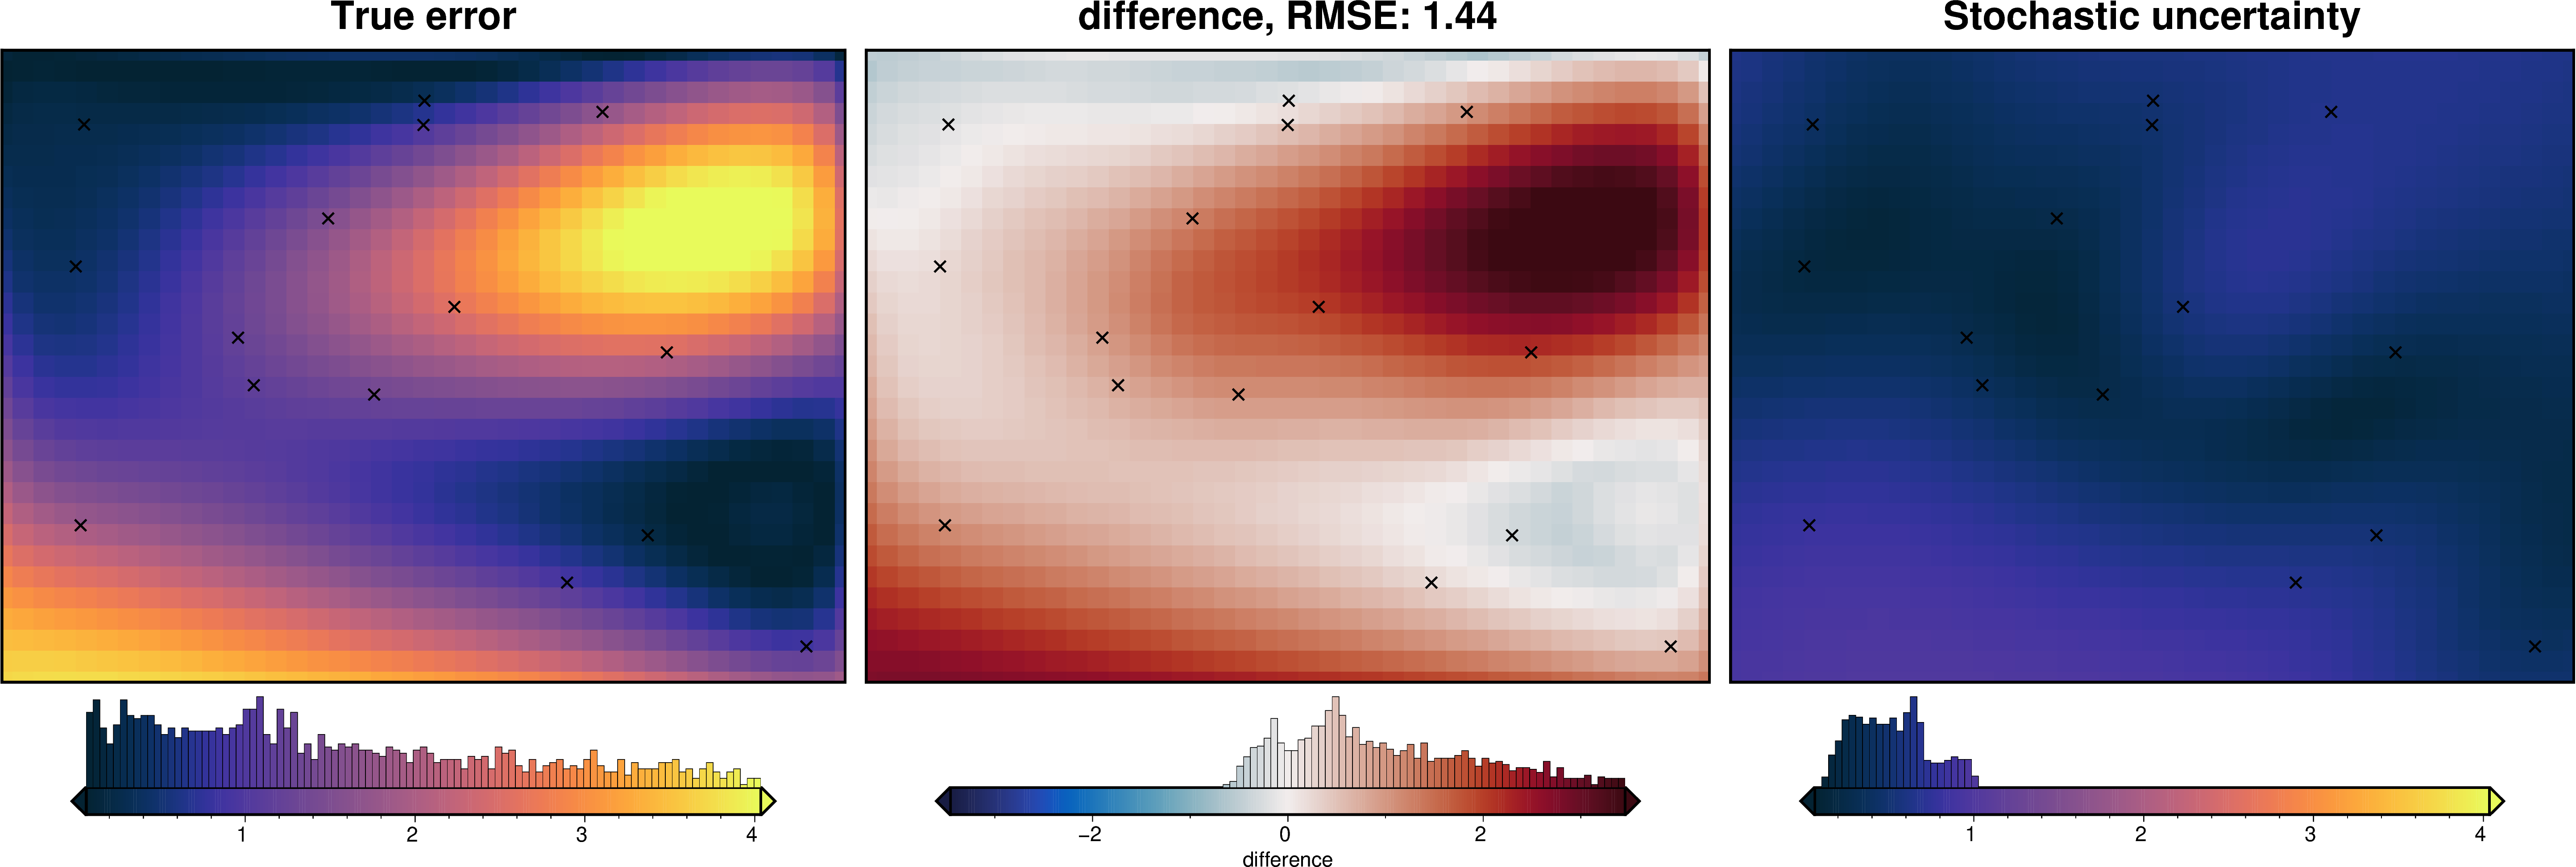

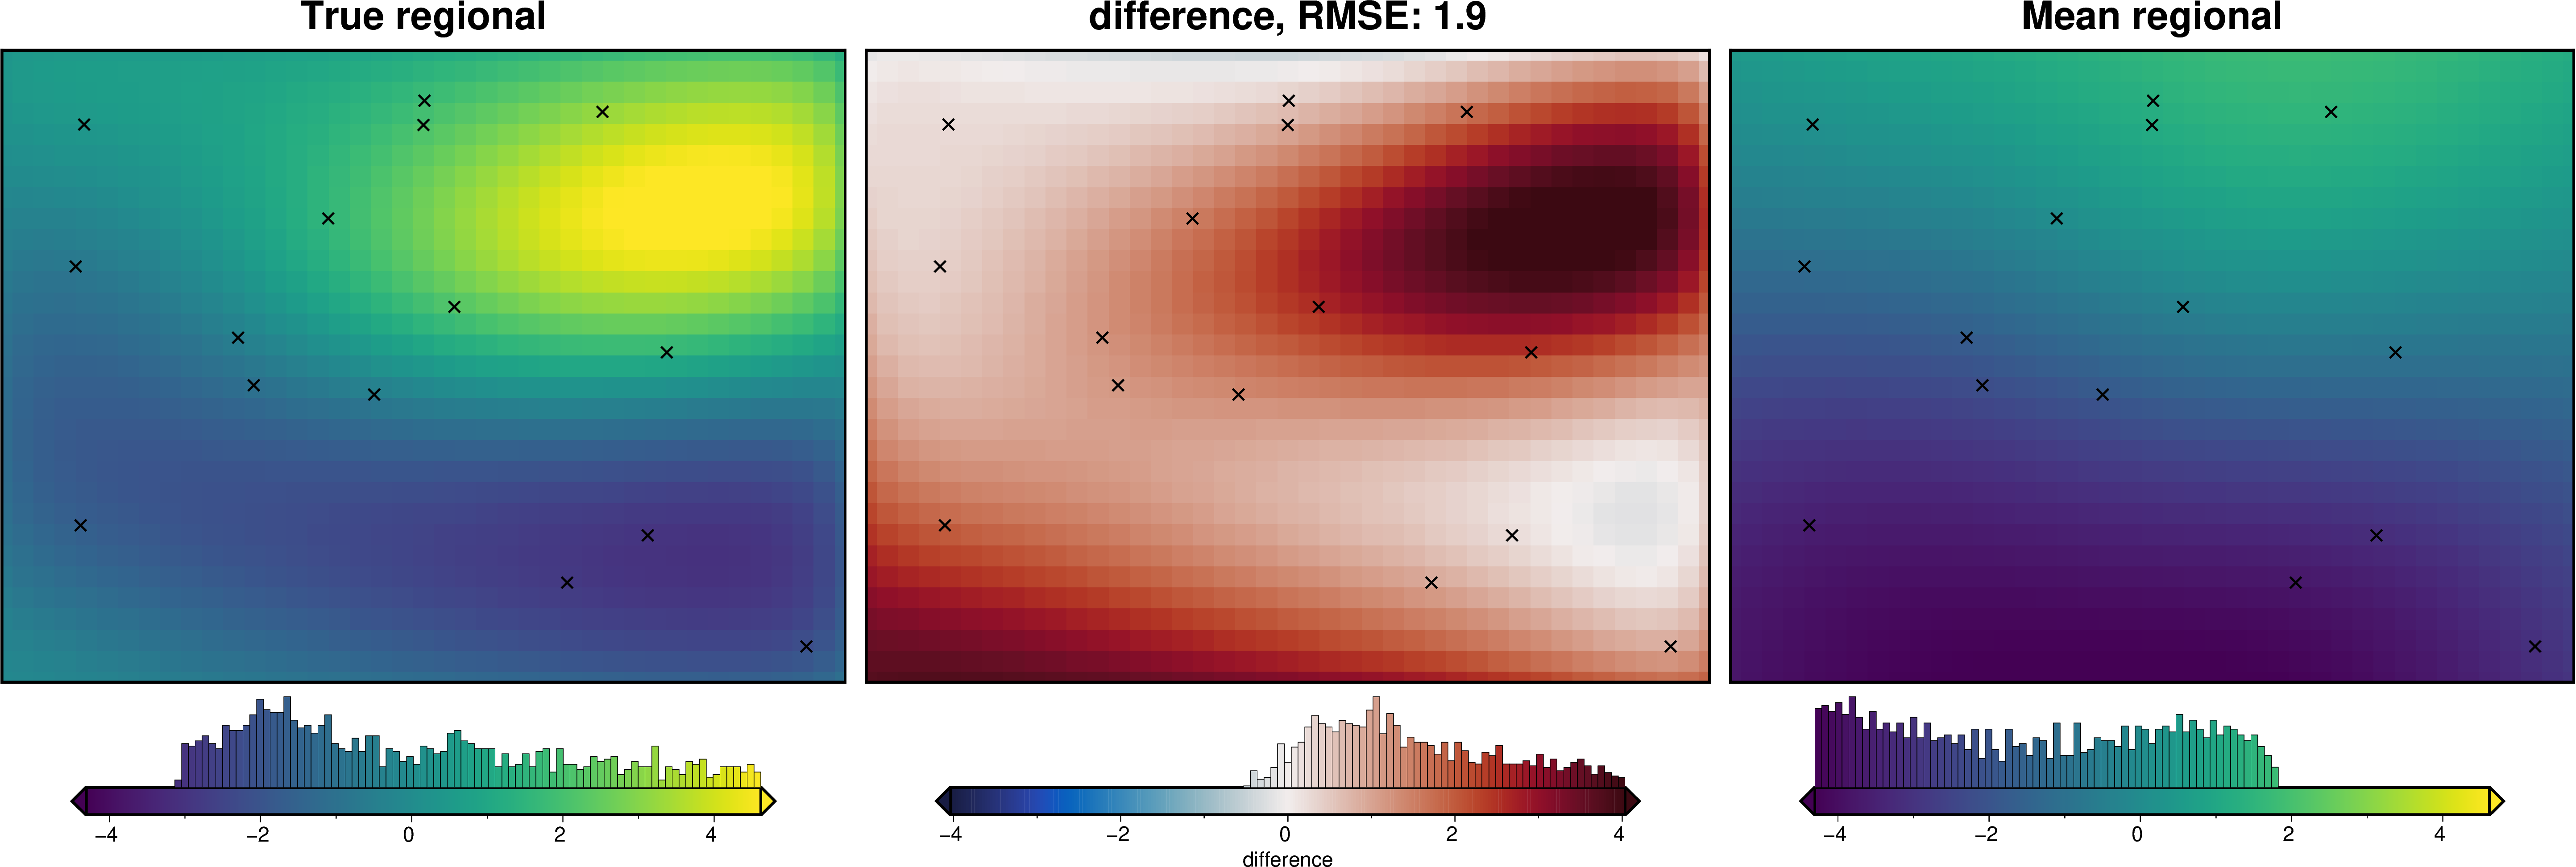

In [19]:
regional_misfit_parameter_dict = {
    "depth": {
        "distribution": "uniform",
        "loc": 2.5 * mean_constraint_distance,  # lower bound
        "scale": 3.5 * mean_constraint_distance,  # range, 2.5+3.5=6
    },
    "damping": {
        "distribution": "normal",
        "loc": np.log10(eq_damping),  # mean base 10 exponent
        "scale": 1,  # standard deviation of exponent
        "log": True,
    },
}

regional_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    method="constraints",
    grid_method="eq_sources",
    remove_starting_grav_mean=False,
    damping=eq_damping,
    depth="default",
    block_size=None,
)

regional_misfit_stats = uncertainty.regional_misfit_uncertainty(
    runs=40,
    sample_gravity=True,
    parameter_dict=regional_misfit_parameter_dict,
    plot_region=region,
    true_regional=grav_grid.lower_surface_grav,
    **regional_kwargs,
)

## Inversion Uncertainty

In [20]:
# plotting functions for uncertainty results
def uncert_plots(results):
    ds = uncertainty.merged_stats(
        results=results,
        plot=True,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    _ = polar_utils.grd_compare(
        true_topography,
        ds.weighted_mean,
        plot=True,
        grid1_name="True topography",
        grid2_name="Inverted topography",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        reverse_cpt=True,
        cmap="rain",
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    _ = polar_utils.grd_compare(
        np.abs(true_topography - ds.weighted_mean),
        ds.weighted_stdev,
        plot=True,
        grid1_name="True error",
        grid2_name="Stochastic uncertainty",
        robust=True,
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

In [21]:
# parameters used in final inversion
density_contrast, zref, solver_damping, best_spline_damping

(2553.75757285,
 481.69068459415365,
 0.023439608400662986,
 np.float64(2.205130739903059e-06))

In [22]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    constraints_df=constraint_points,
    density_contrast=density_contrast,
    zref=zref,
    solver_damping=solver_damping,
    starting_prisms=starting_prisms,
    starting_topography=starting_topography,
    # kwargs
    starting_topography_kwargs={
        "method": "splines",
        "region": region,
        "spacing": spacing,
        "constraints_df": constraint_points,
        "dampings": best_spline_damping,
        "weights": constraint_points.weight,
    },
    regional_grav_kwargs=regional_kwargs,
    **kwargs,
)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2553.7575728500005, min: 1965.7683774879838, max: 3141.746768212017
INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.02587150101529251, min: 0.009505118922086452, max: 0.057802037668333556
INFO:invert4geom:Sampled 'dampings' parameter values; mean: 3.986413368726571e-06, min: 2.3091510953564804e-07, max: 2.105796190575718e-05
INFO:invert4geom:Sampled 'depth' parameter values; mean: 23796.415162690966, min: 14487.817466697146, max: 33105.012858684786
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.15254884051283088, min: 0.00020686026106998004, max: 1.7203033598166477
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_full'



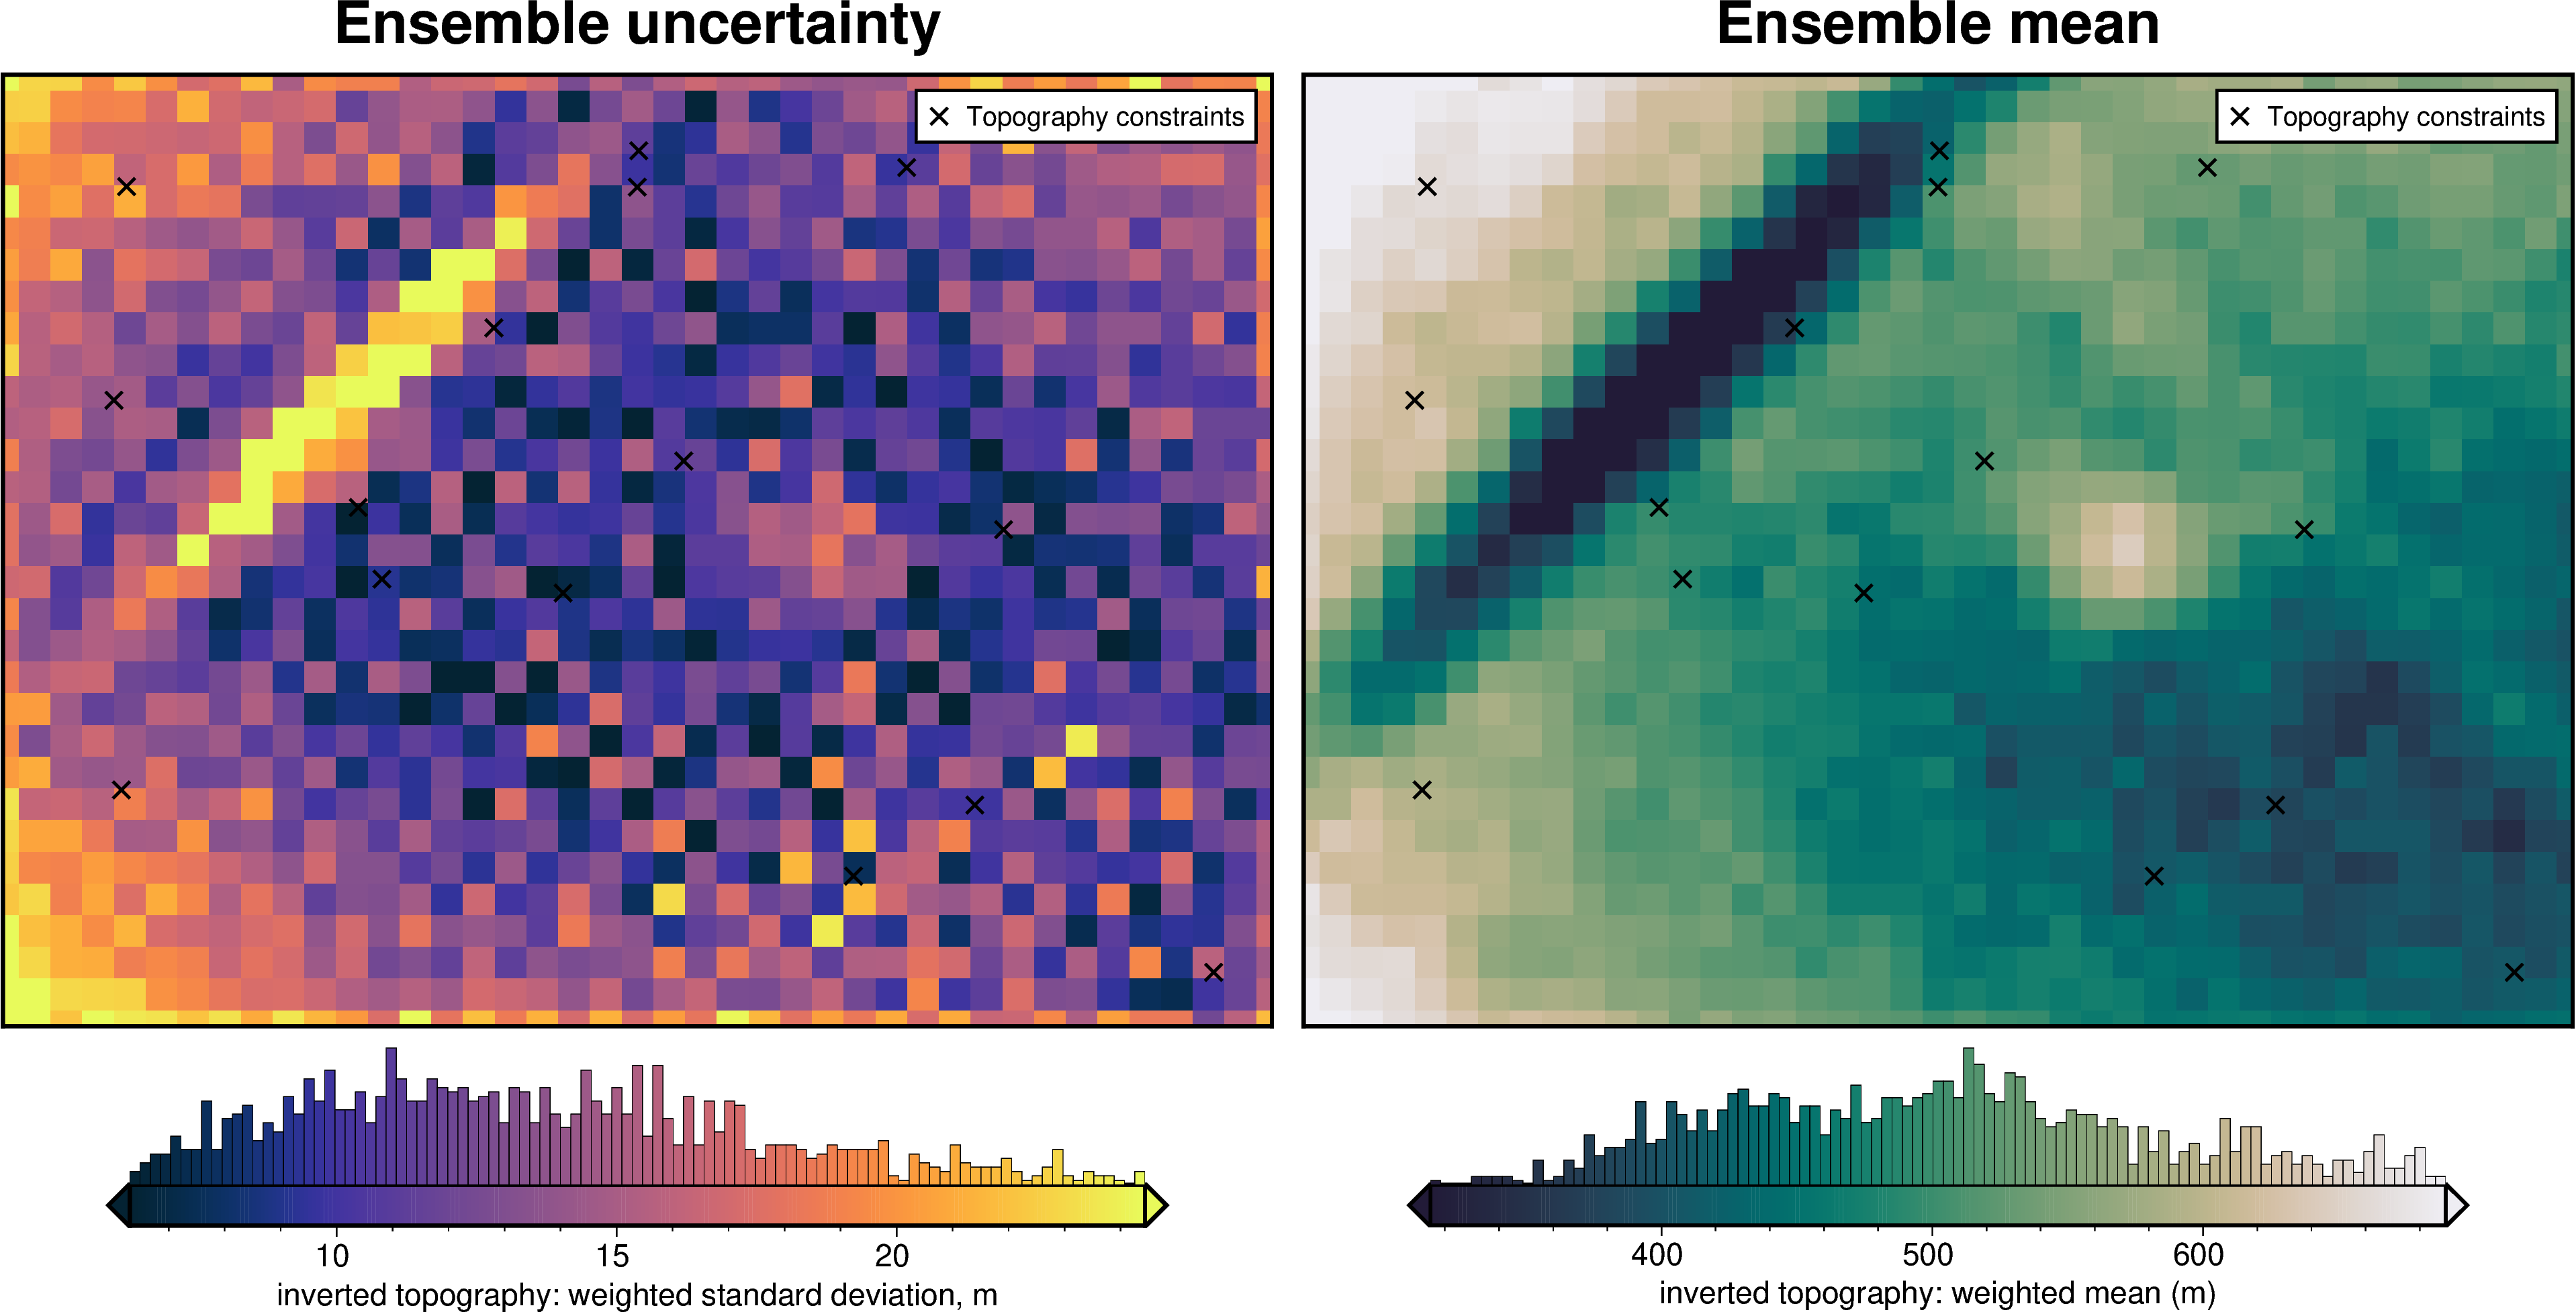

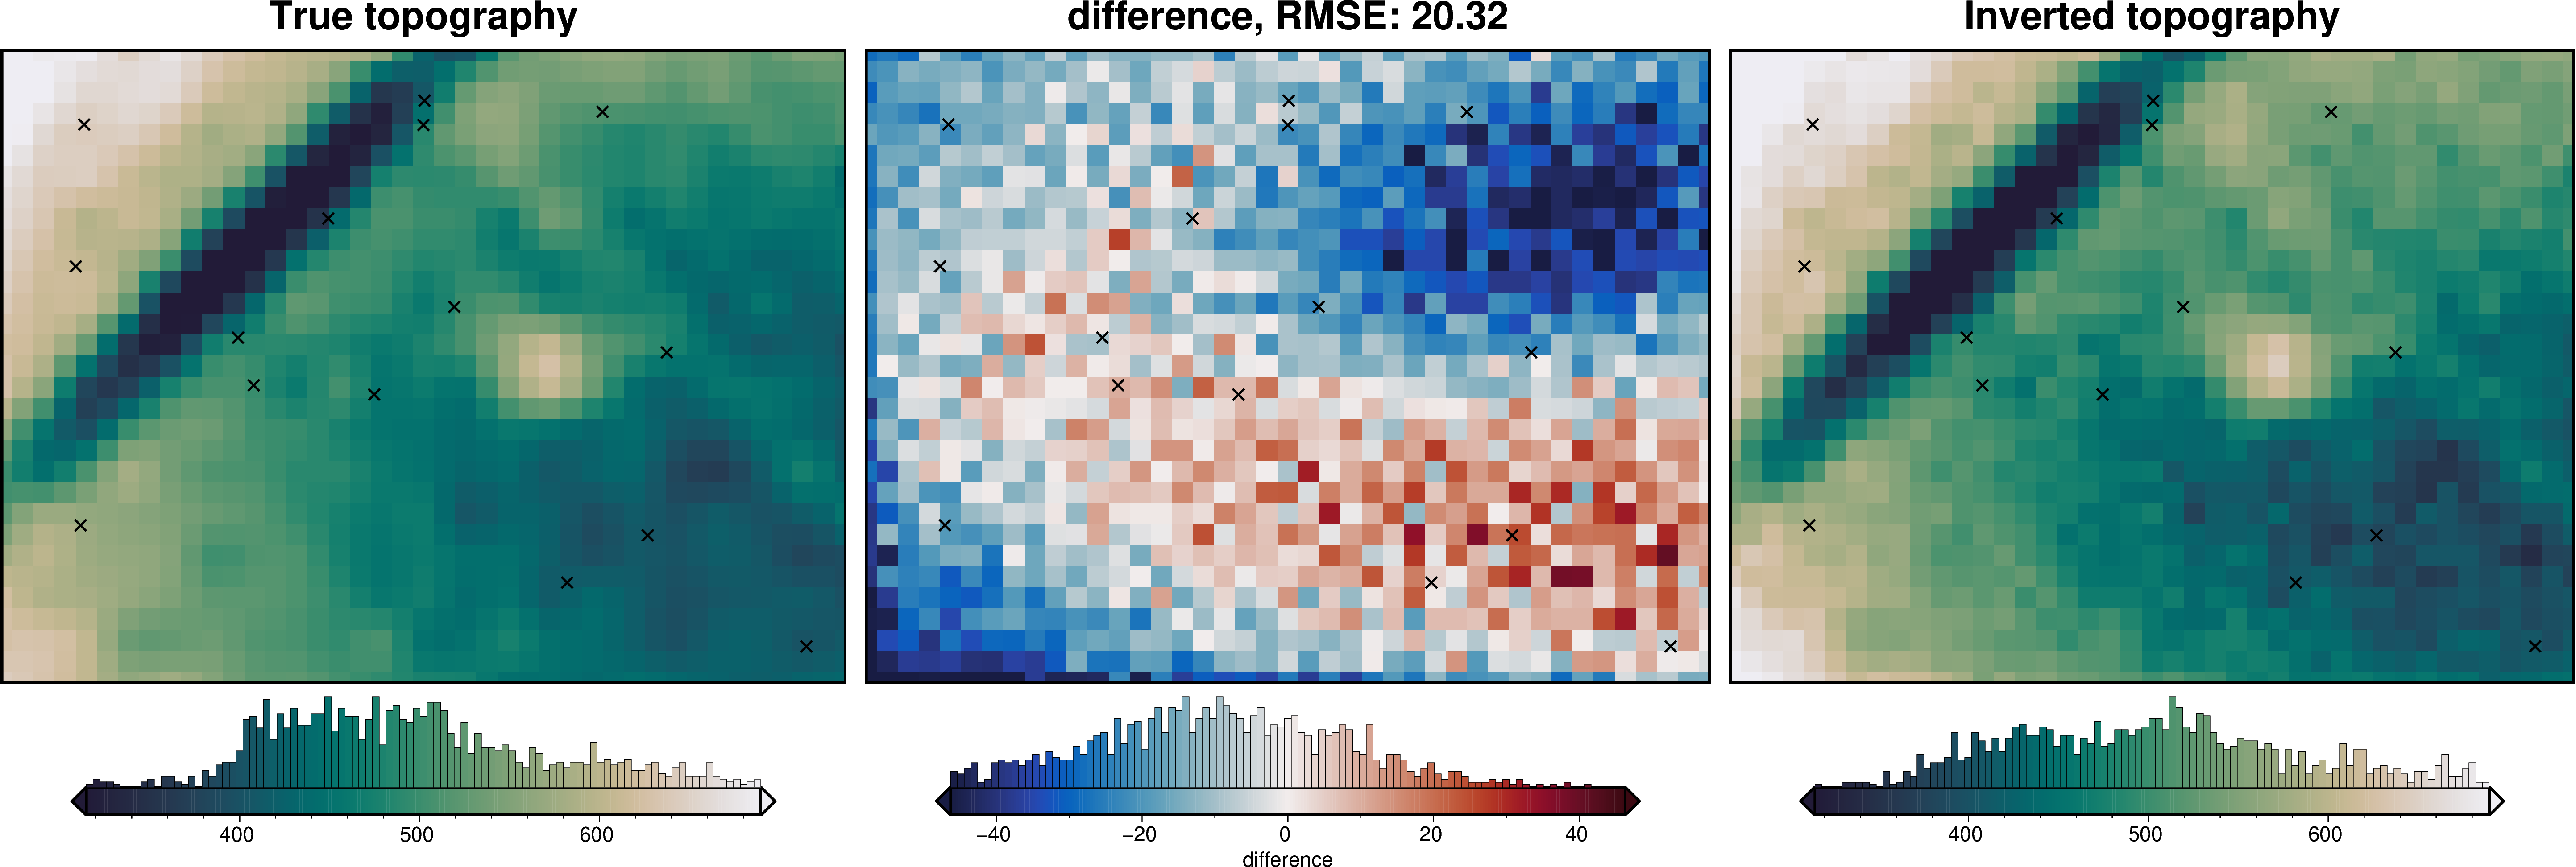

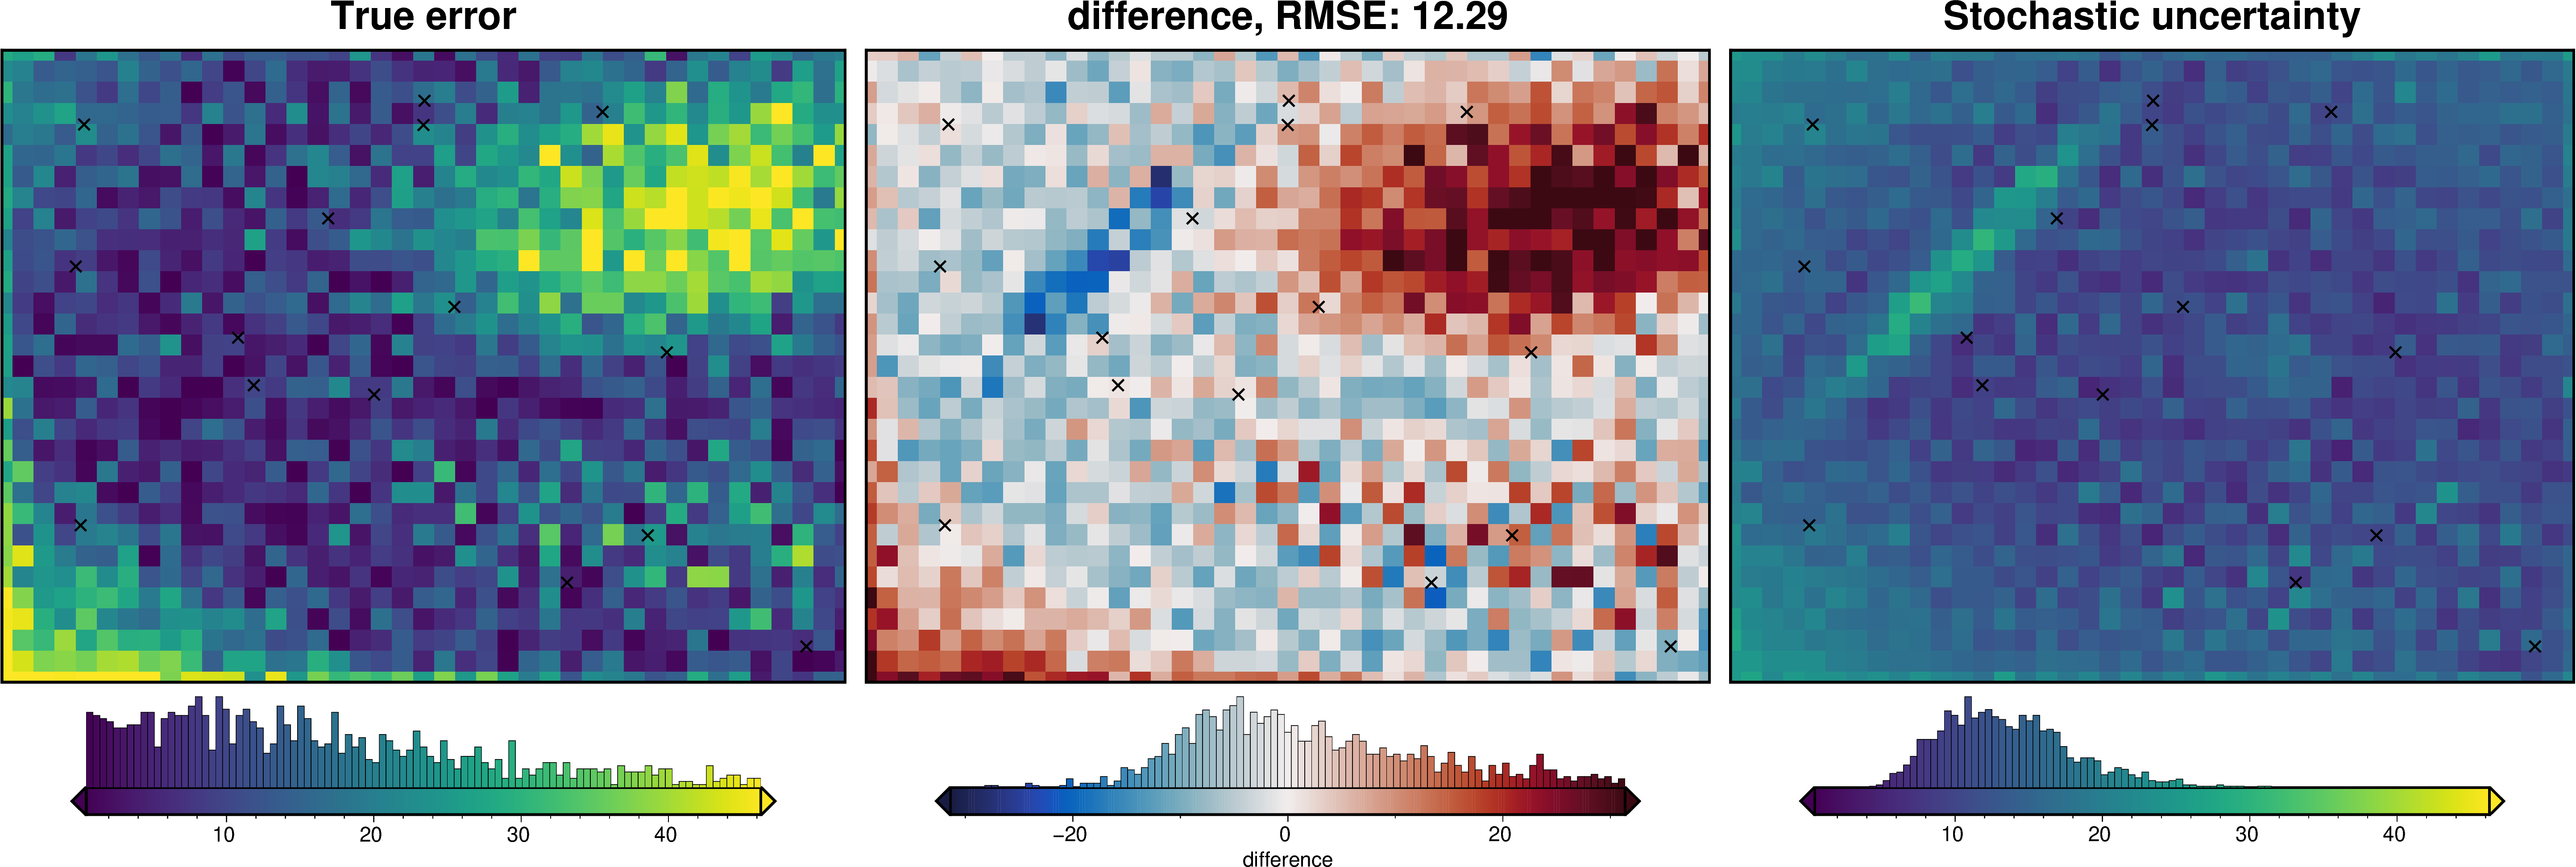

In [23]:
parameter_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": 300,
    },
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean base 10 exponent
        "scale": 0.2,
        "log": True,
    },
}

fname = "tmp/uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    sample_constraints=True,
    parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_results)

## Sensitivity Analysis

Above we perform an uncertainty assessment using all the important parameters and data. Now, we can repeat this stochastic analysis isolated the uncertainty arising from each component. This should give us a sense of which parameters/data are the most important.

#### Density contrast component

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 2553.7575728500005, min: 1965.7683774879838, max: 3141.746768212017
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_density'



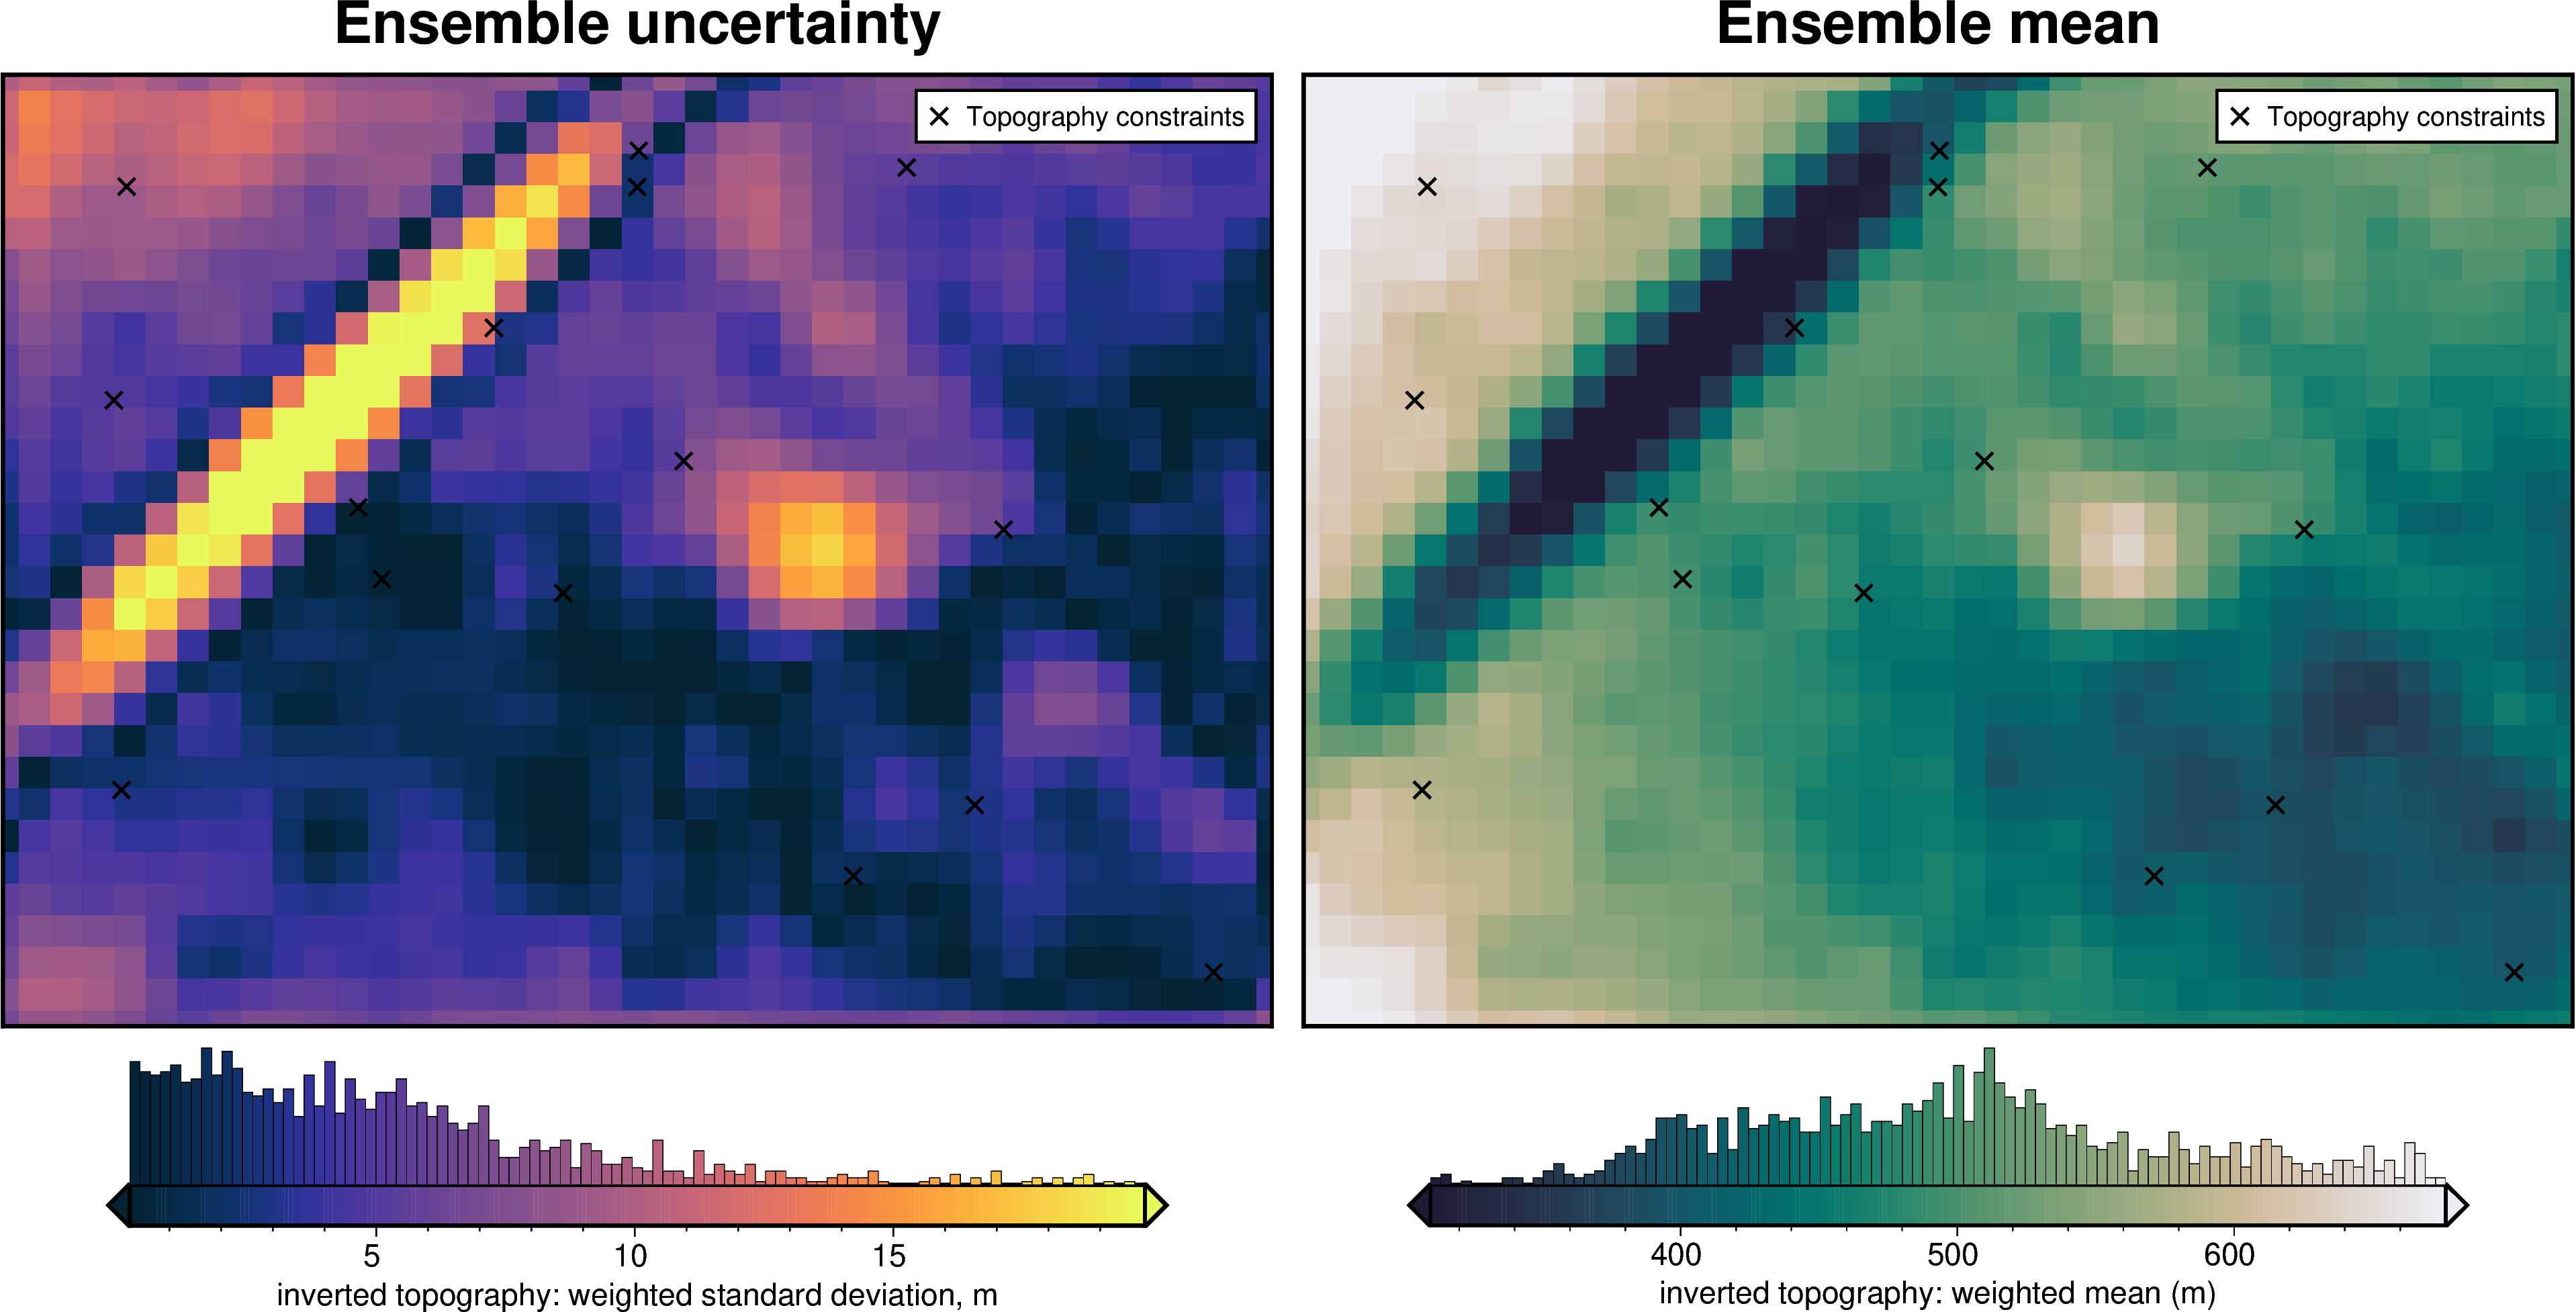

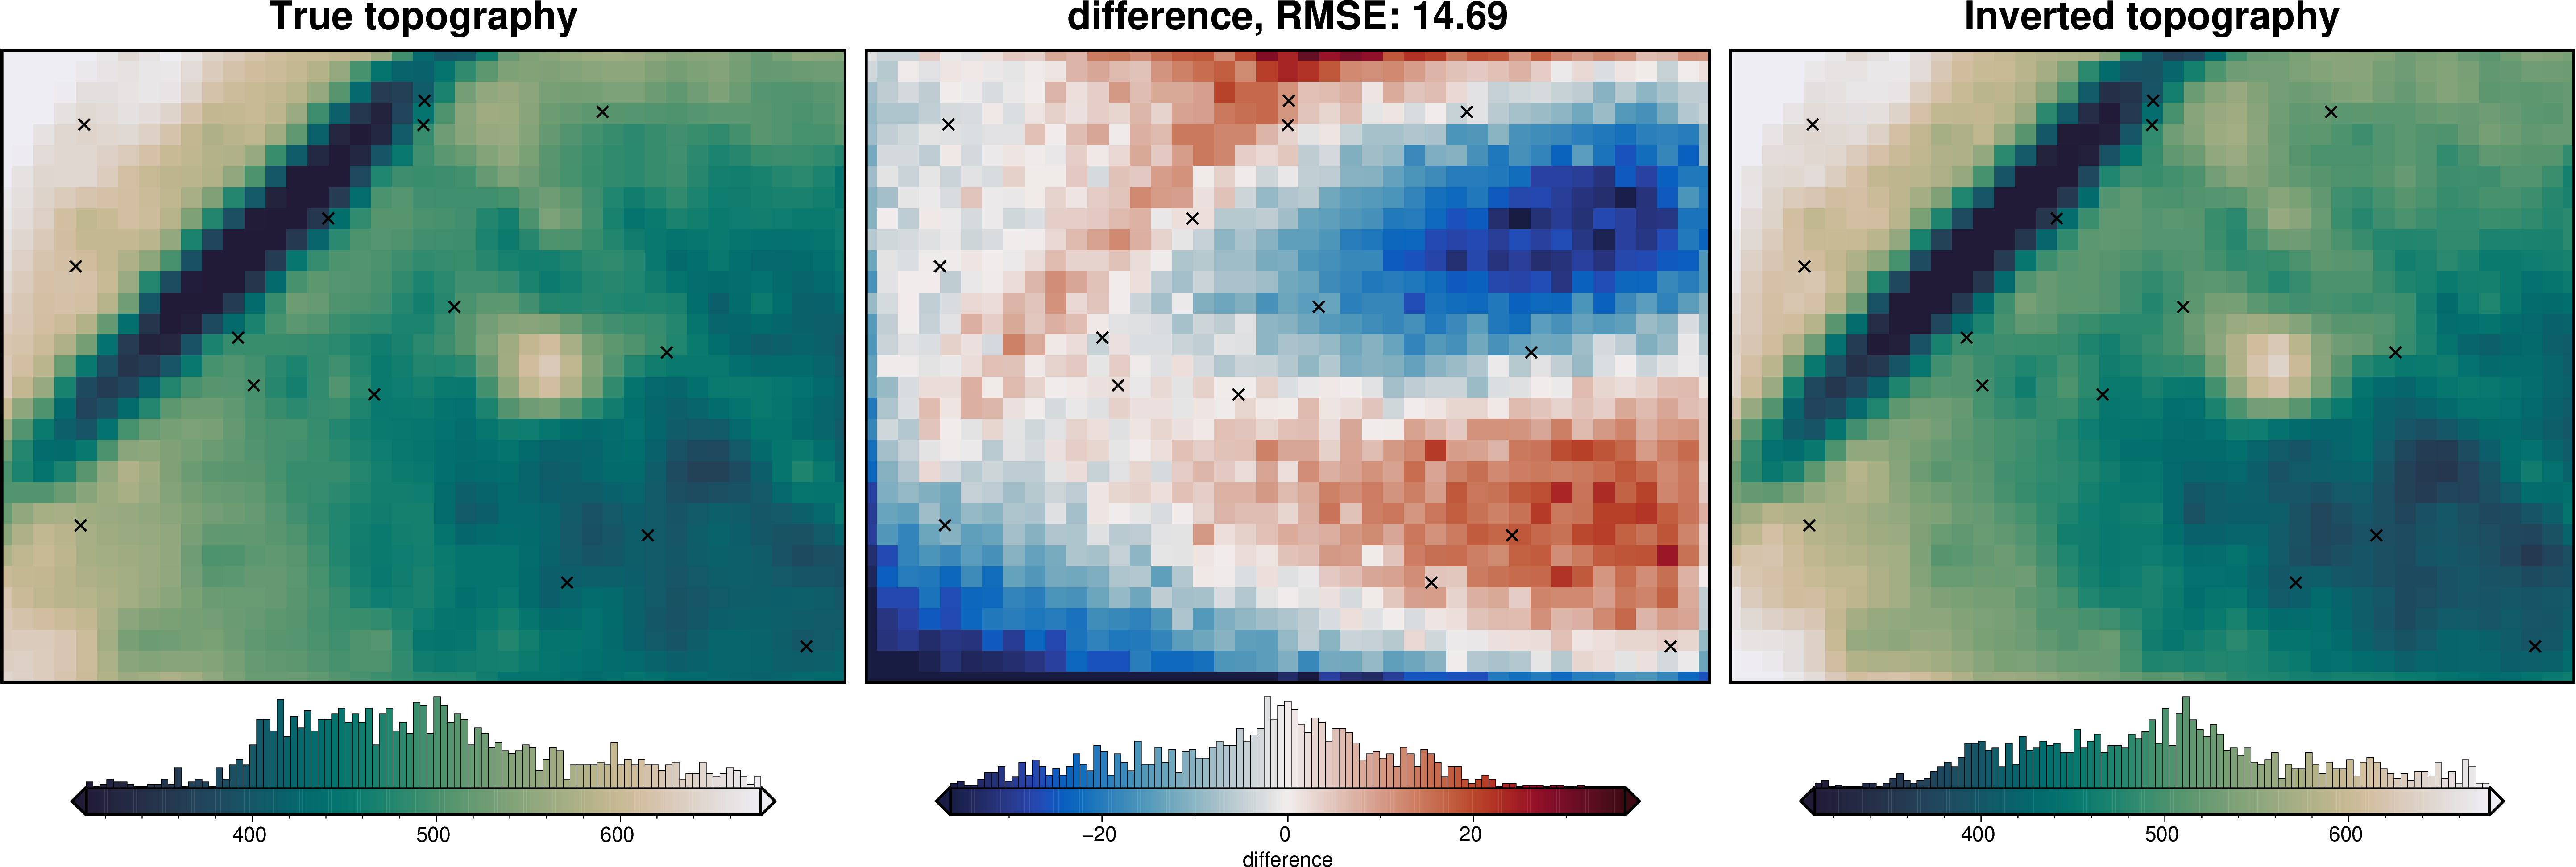

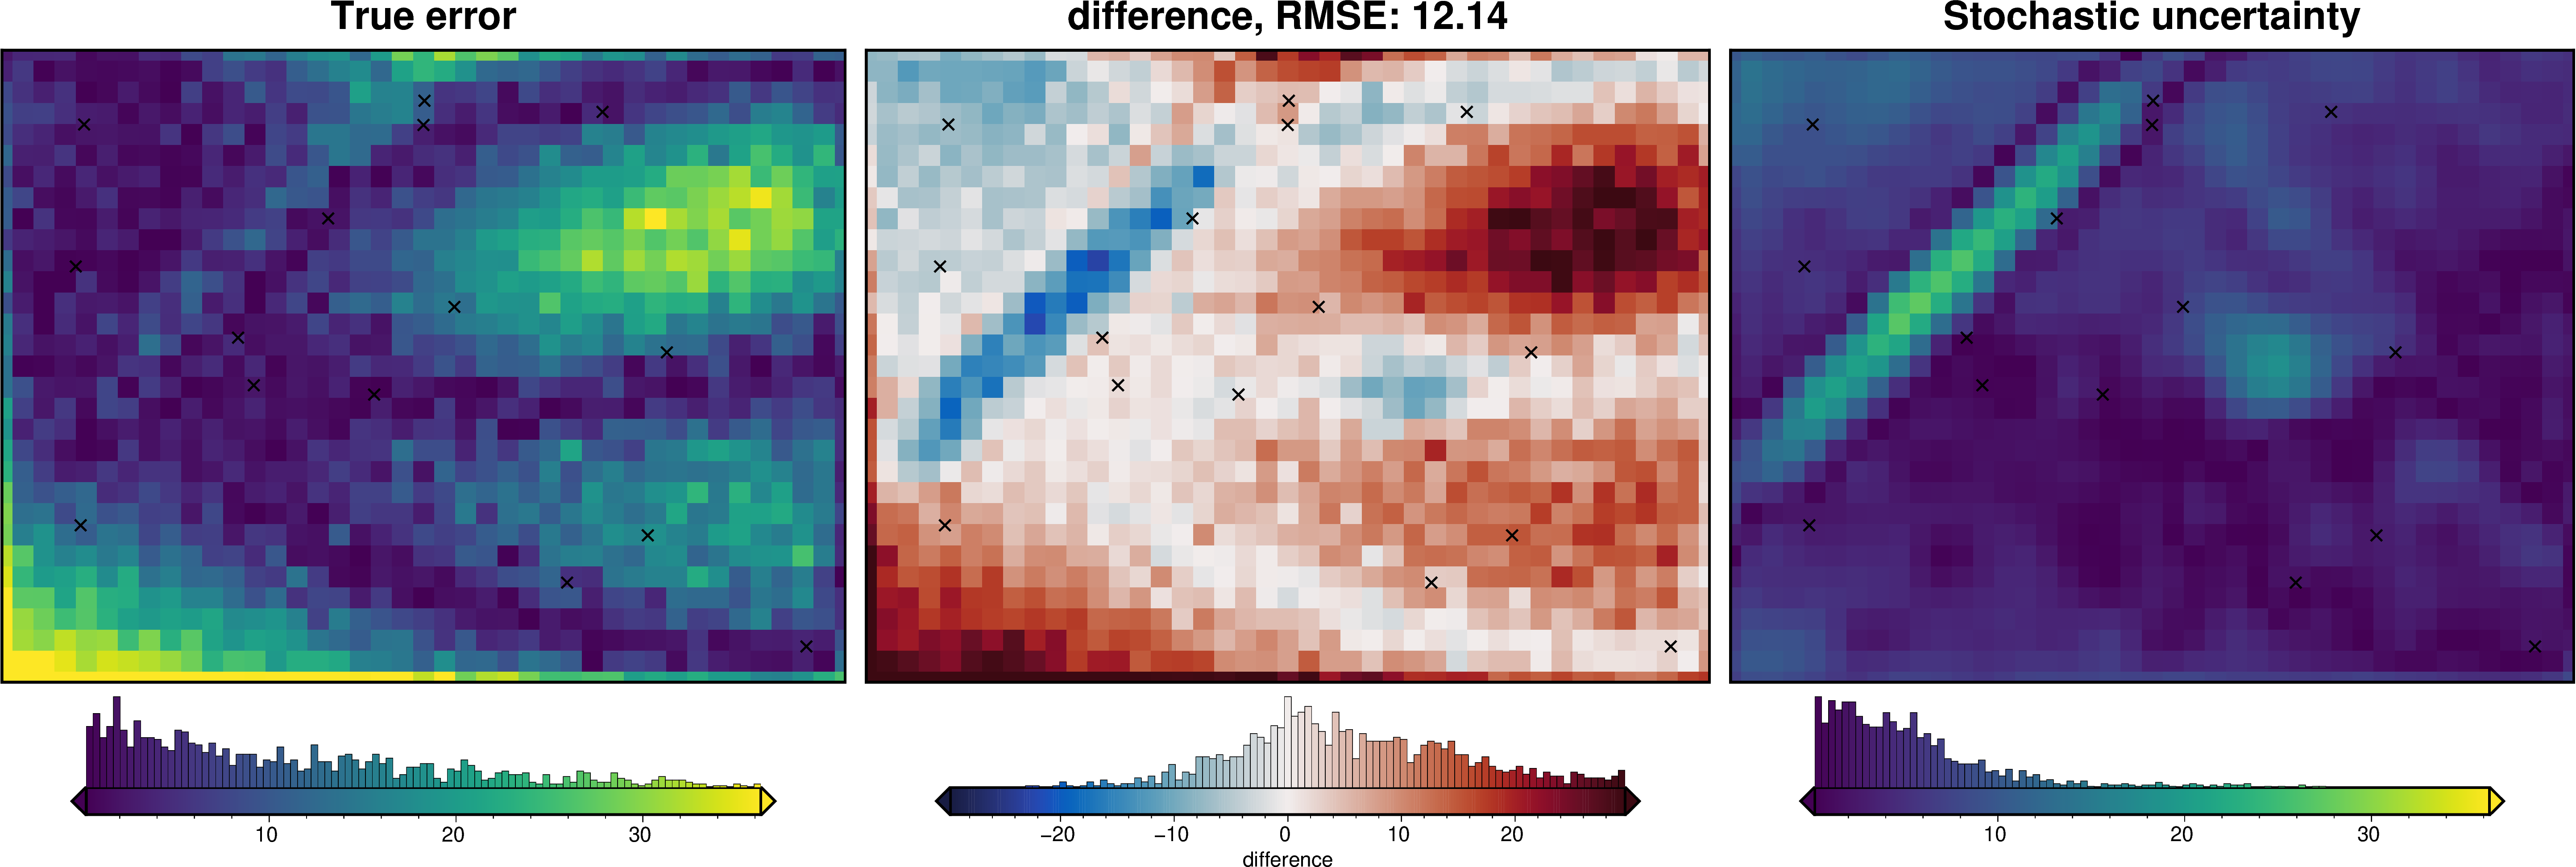

In [24]:
parameter_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": density_contrast,
        "scale": 300,
    },
}

fname = "tmp/uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_density_results)

#### Solver damping component

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.042373890398093264, min: 0.002454530084483668, max: 0.22383724096500762
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_damping'



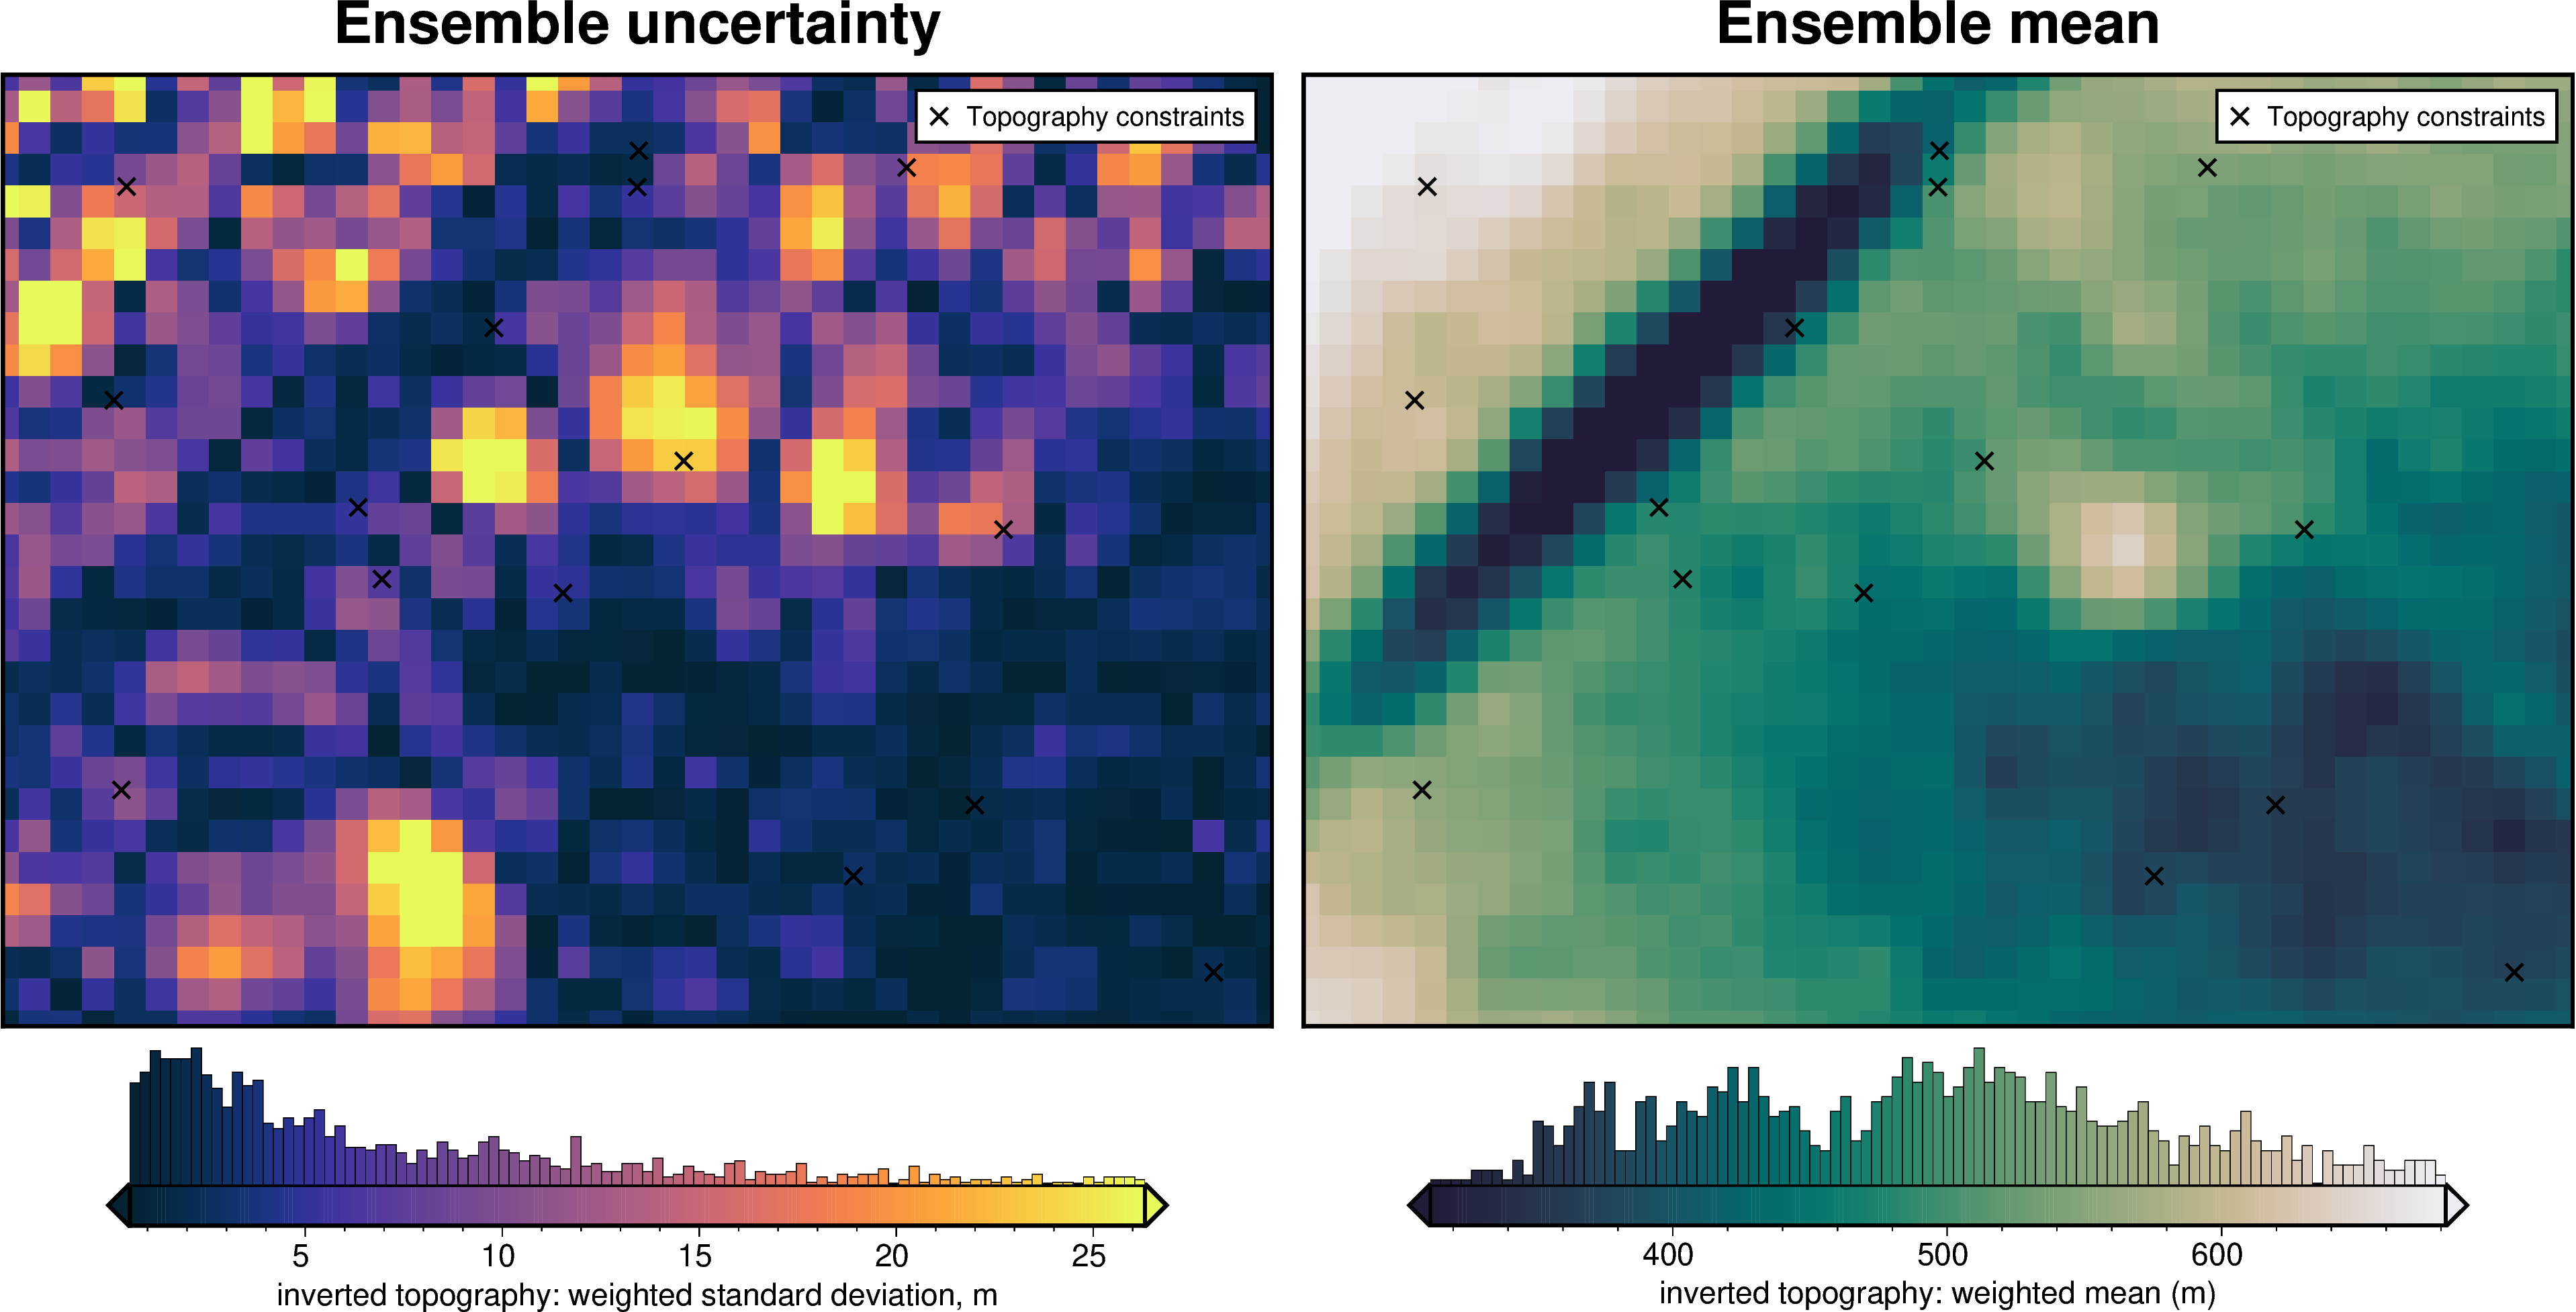

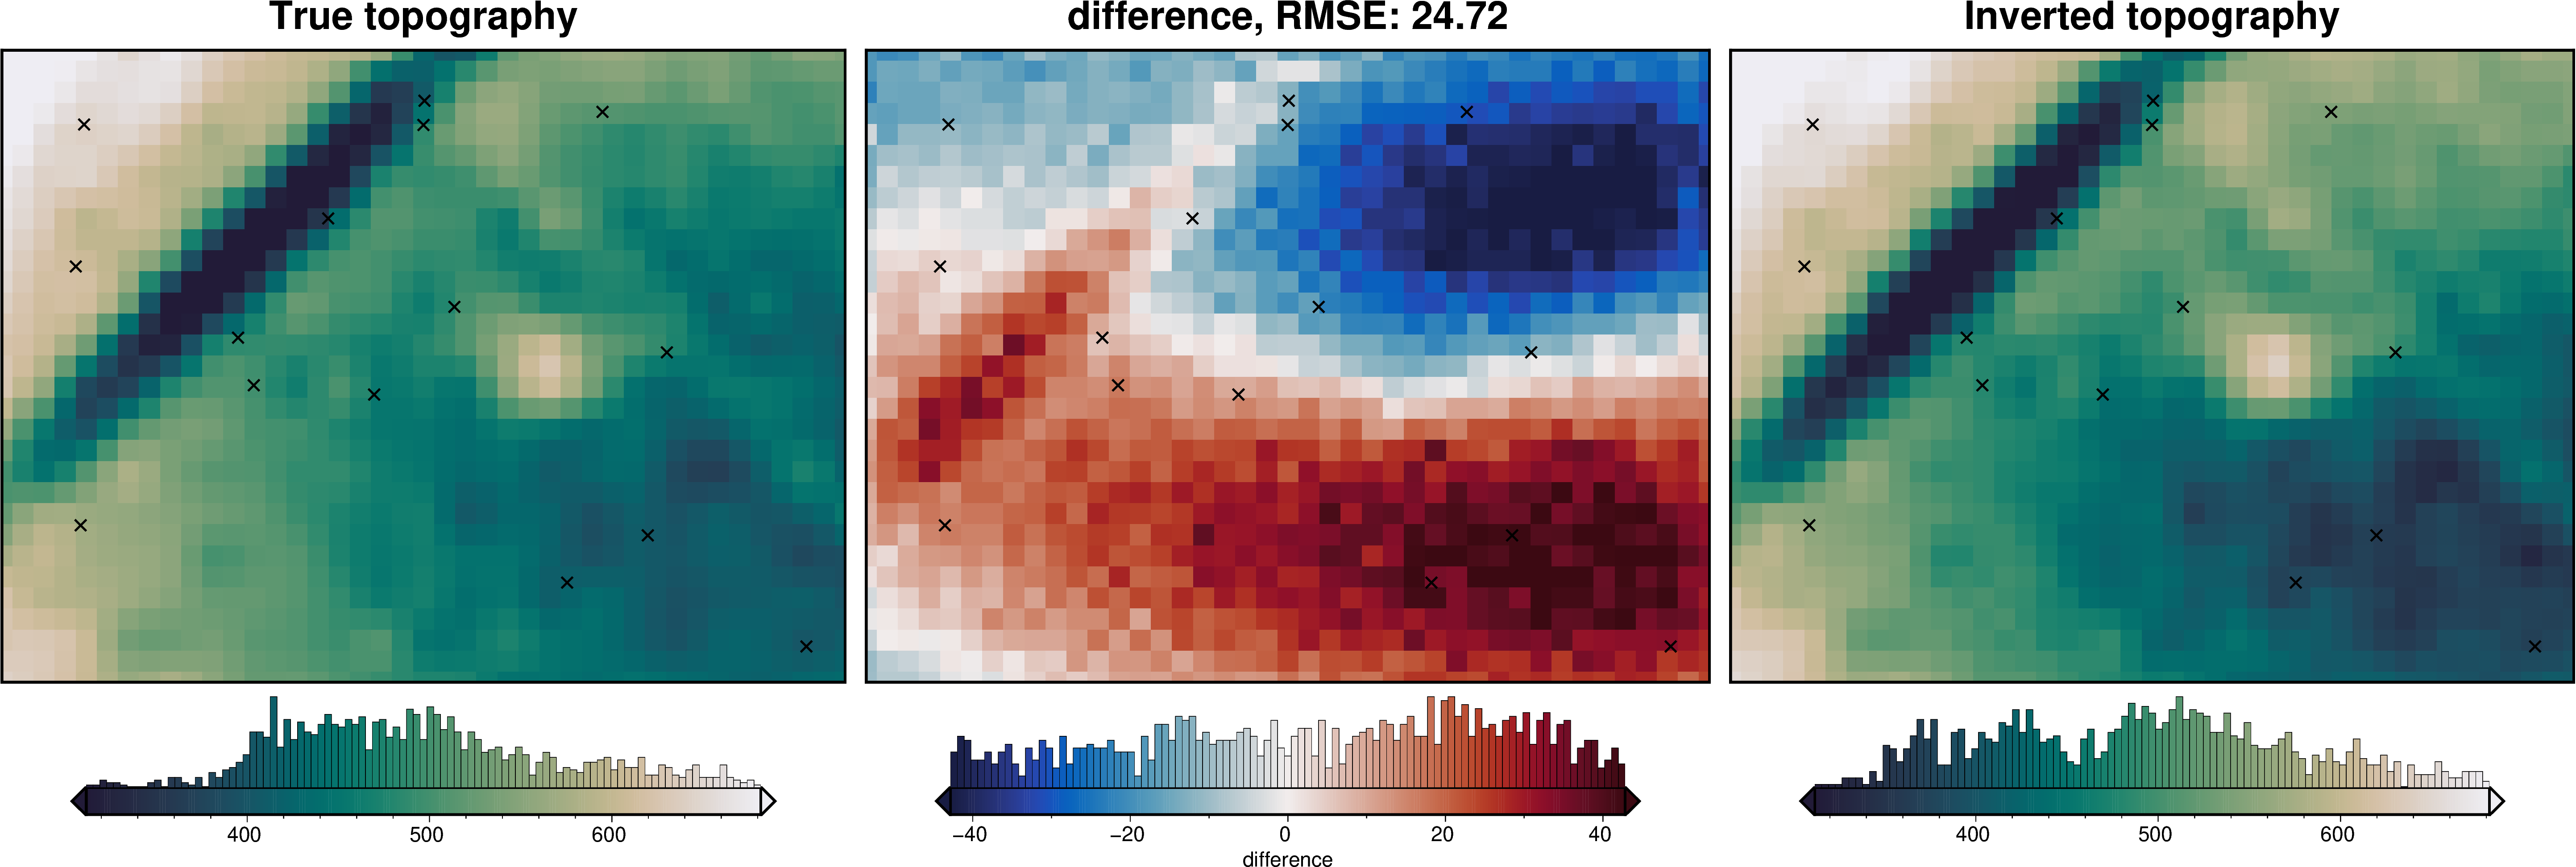

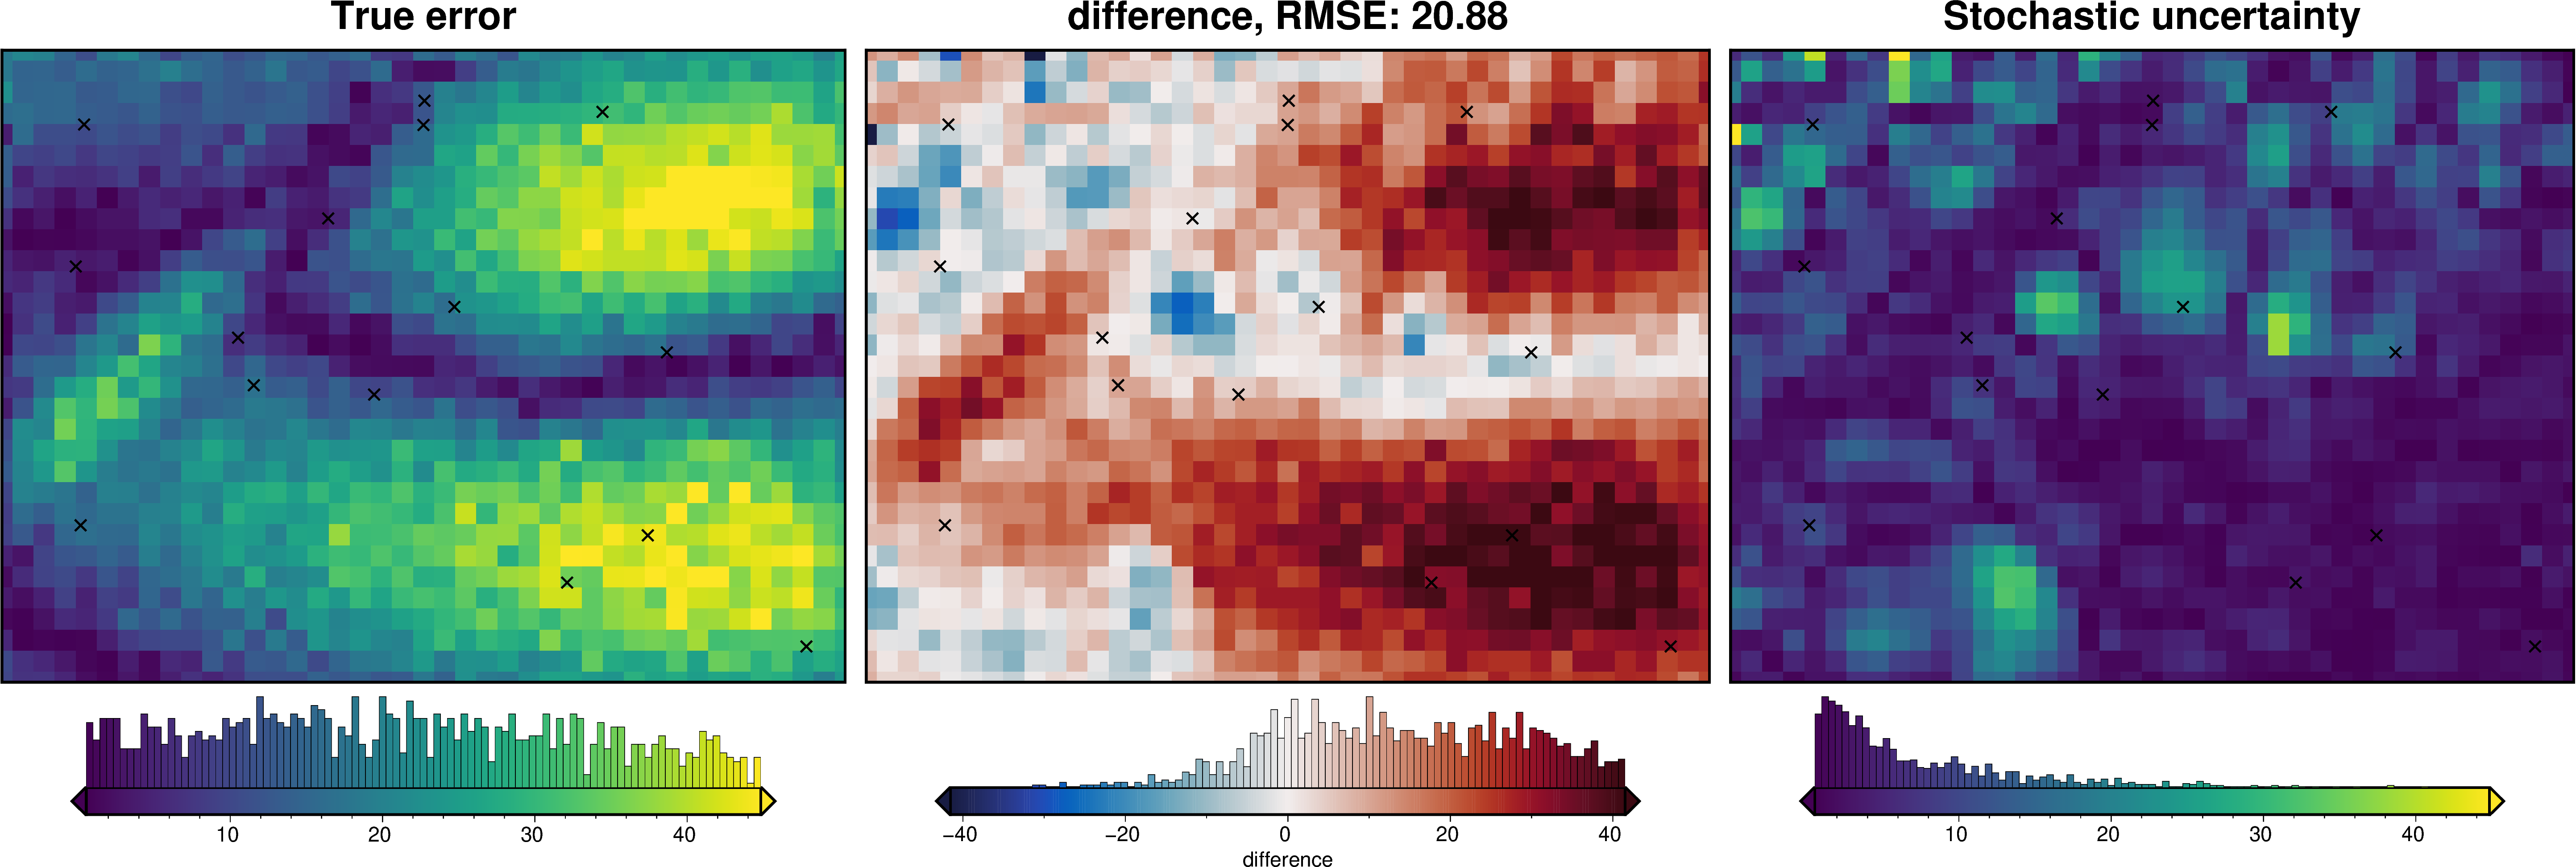

In [25]:
parameter_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(solver_damping),  # mean of base 10 exponent
        "scale": 0.5,  # standard deviation of base 10 exponent
        "log": True,
    },
}

fname = "tmp/uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_damping_results)

#### Gravity component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_grav' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_grav'



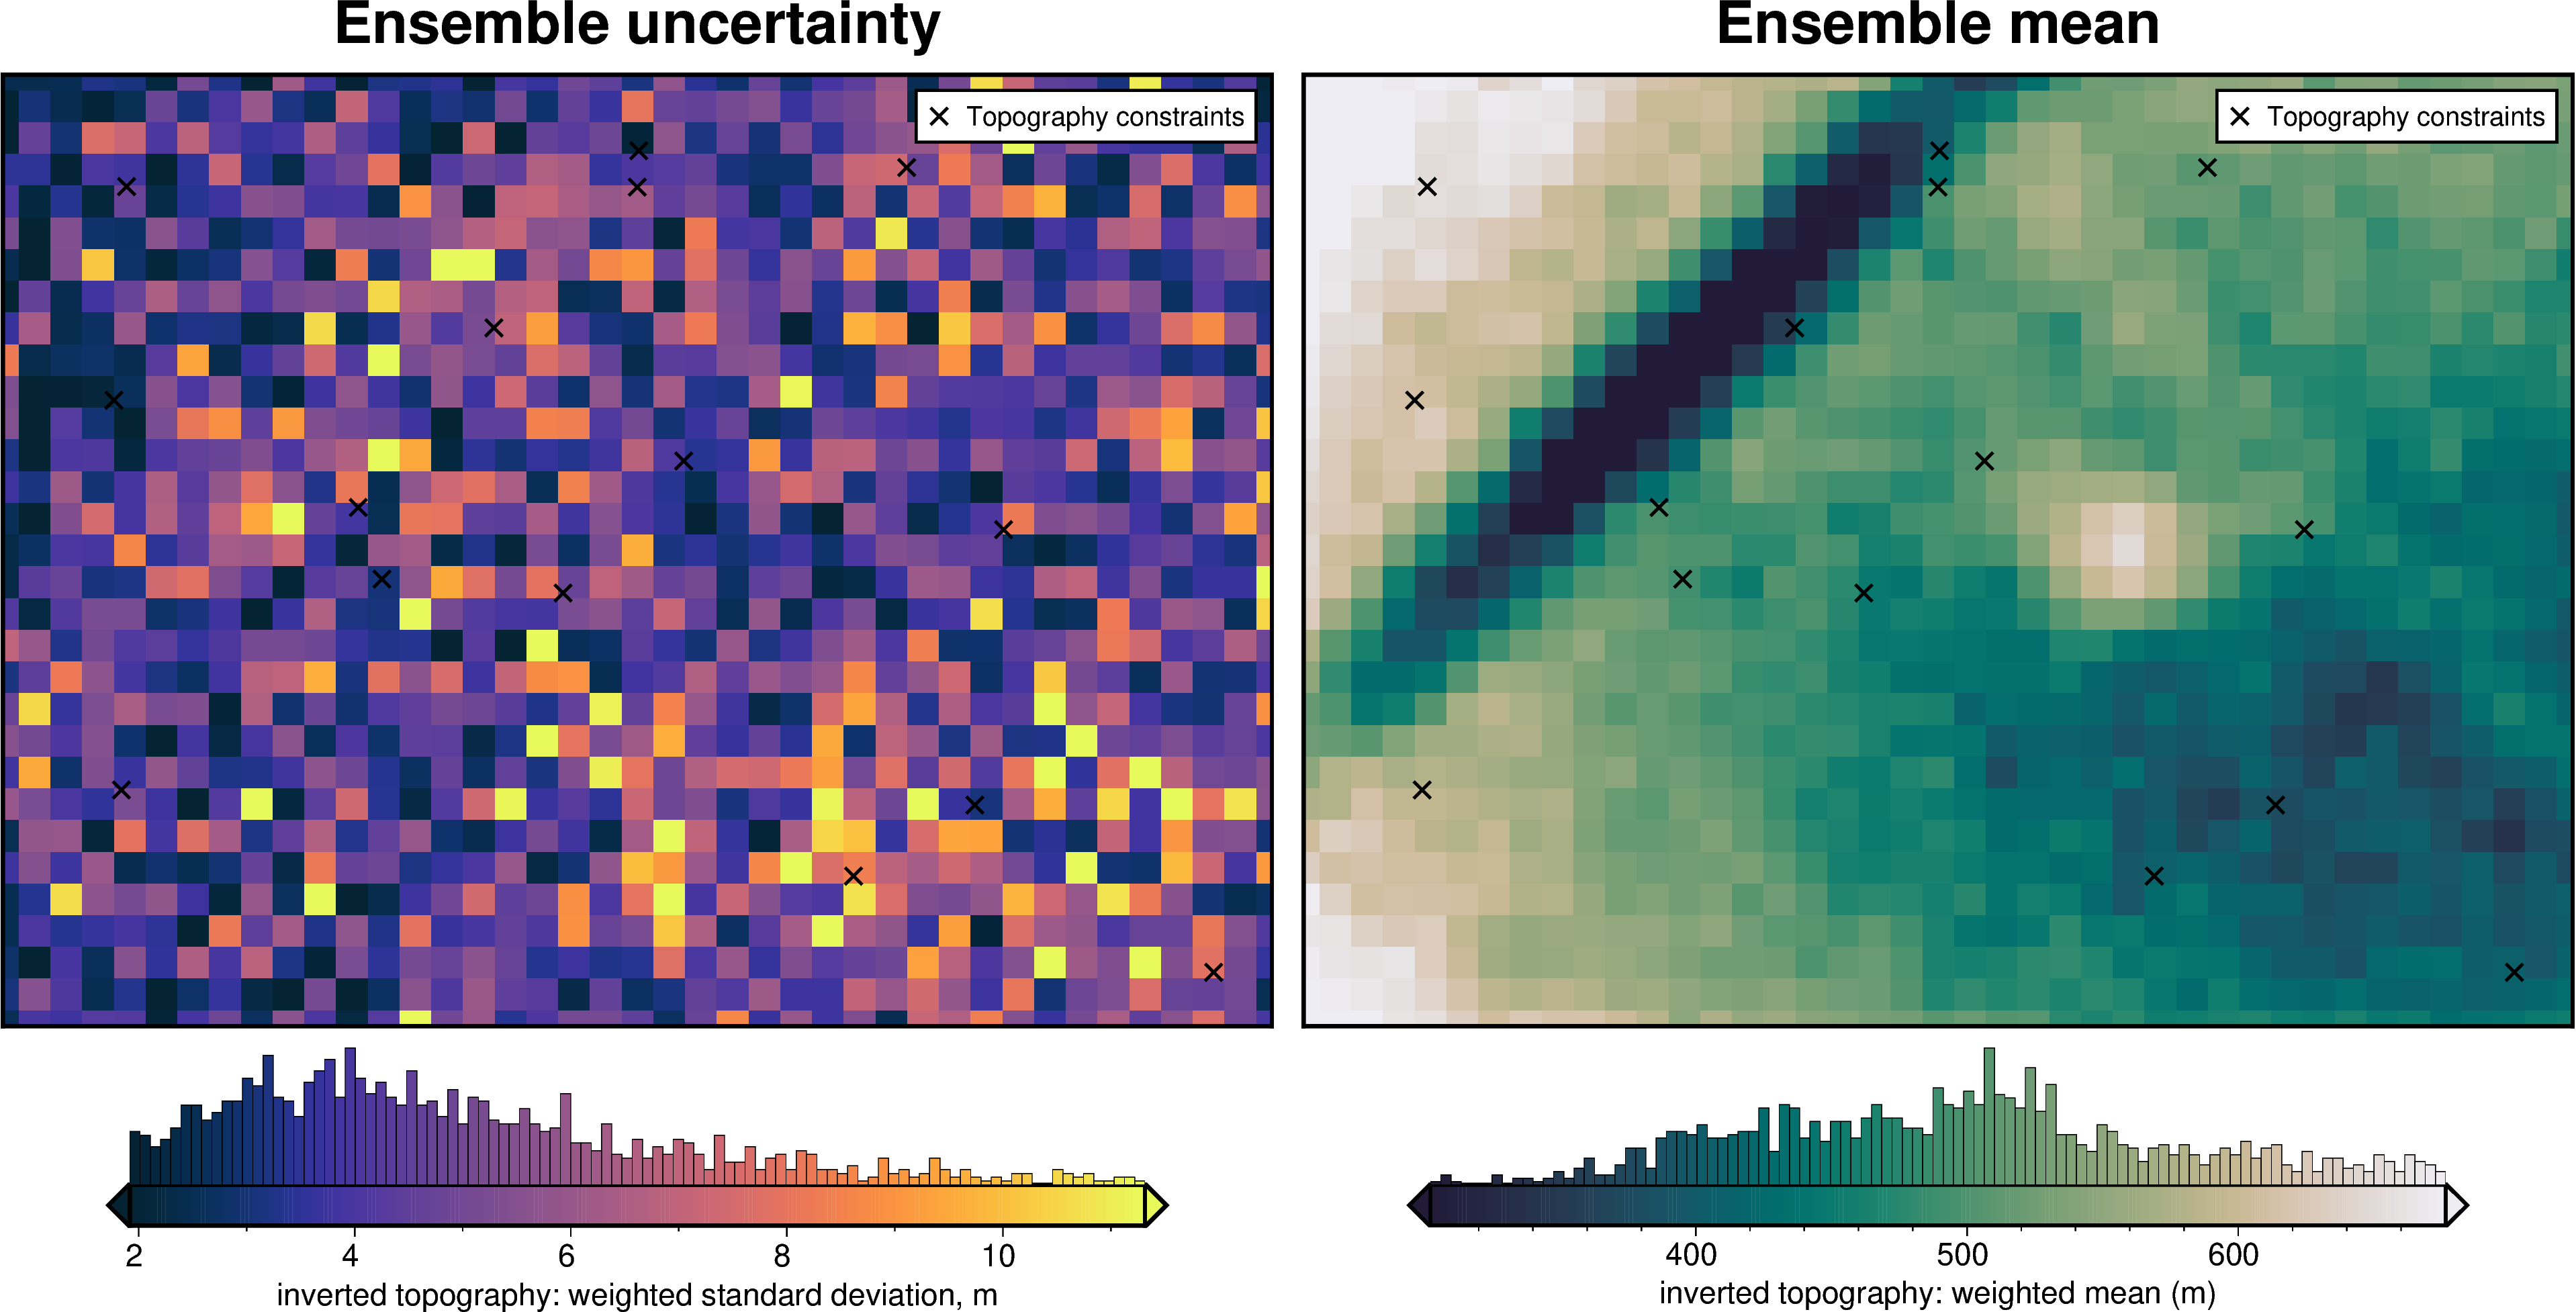

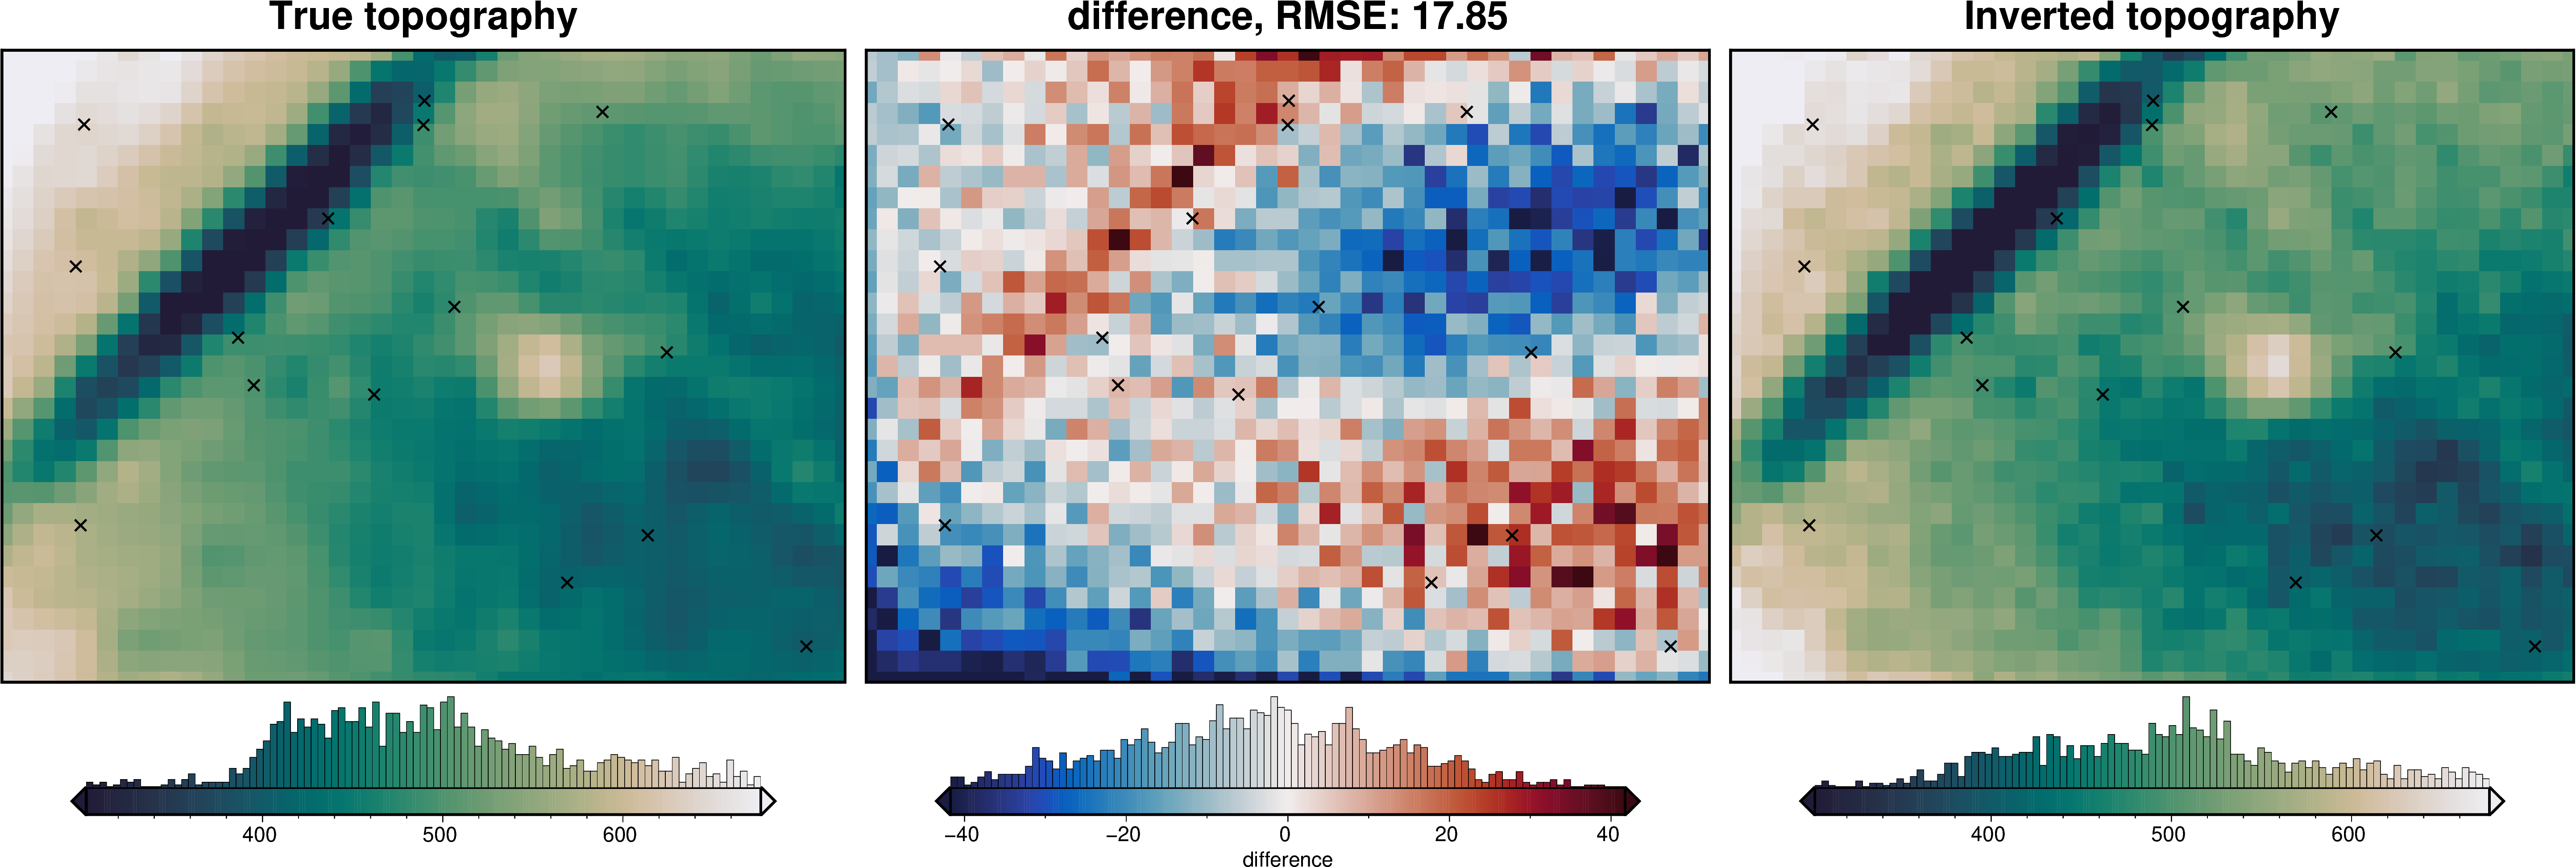

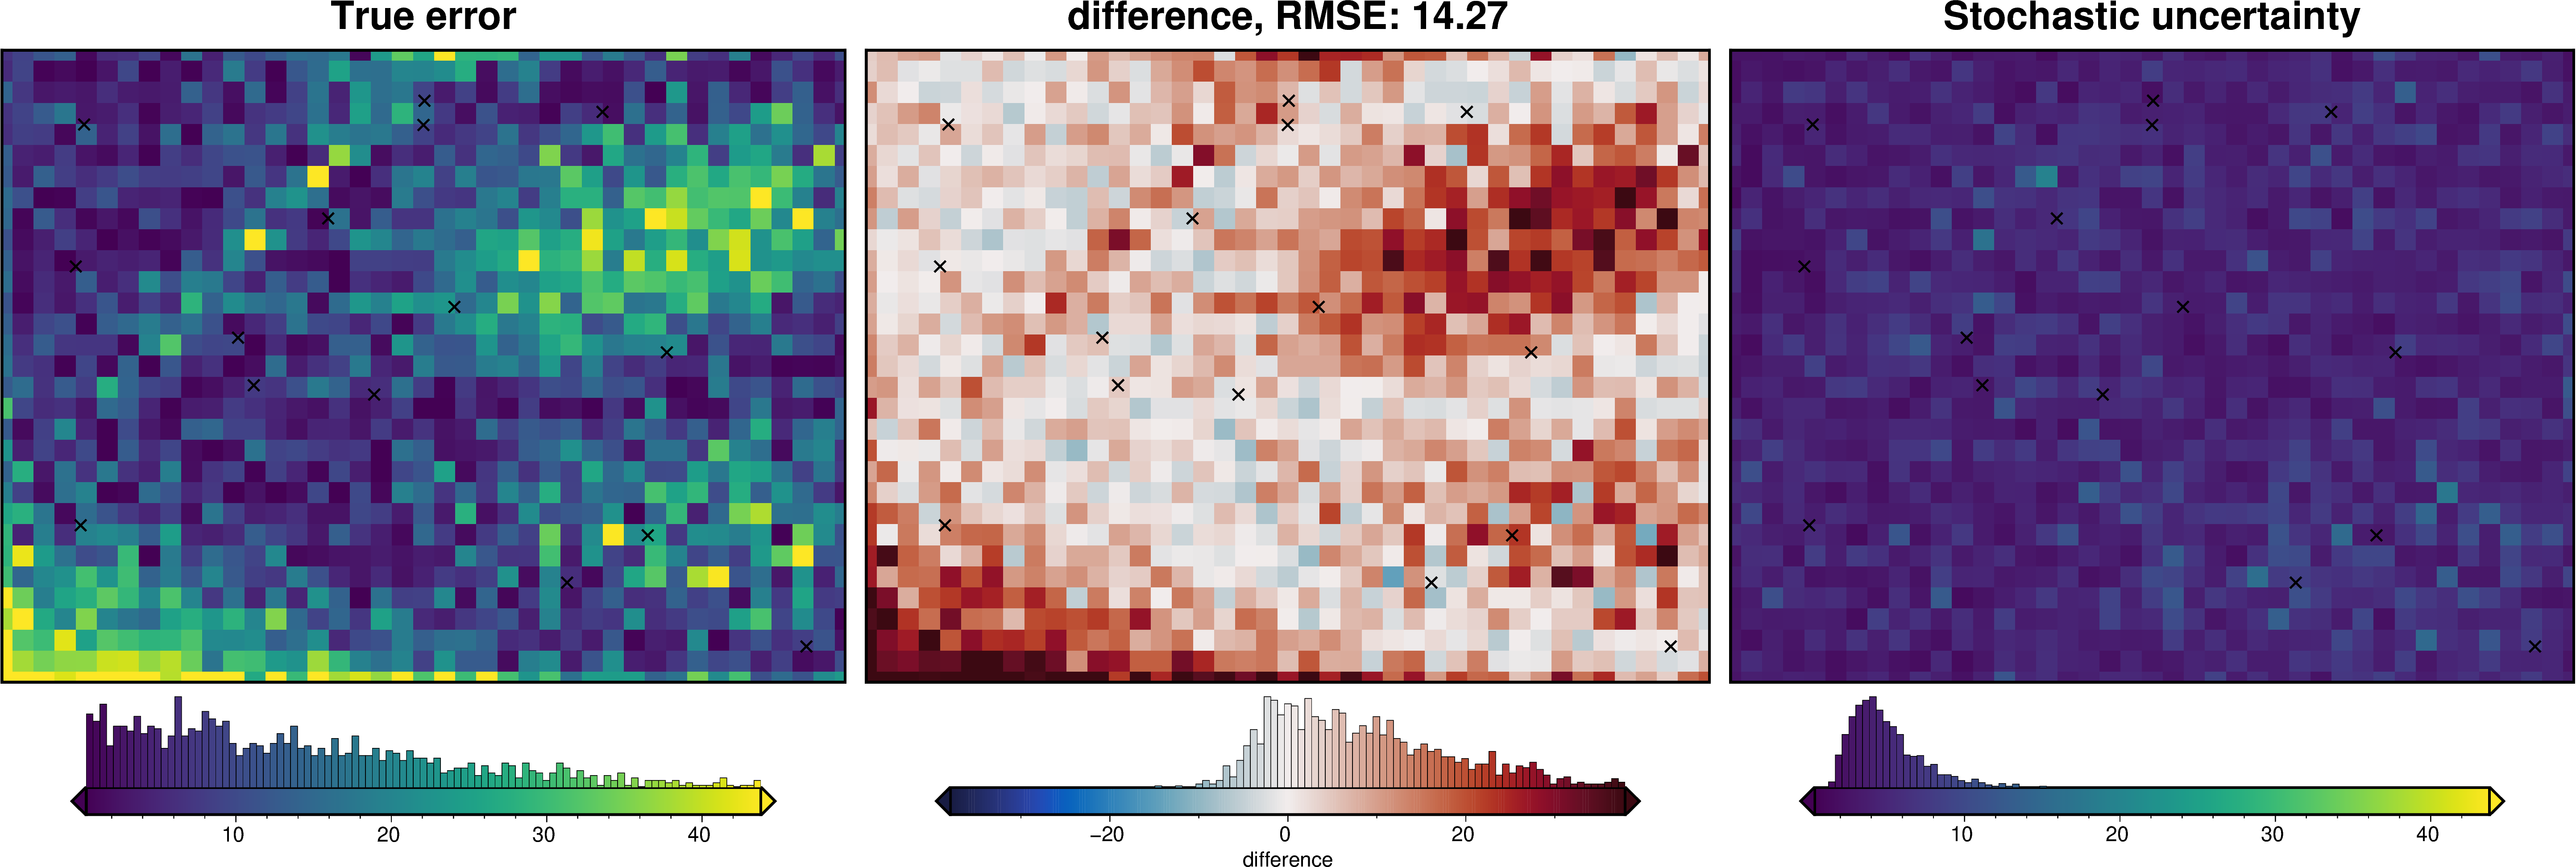

In [26]:
fname = "tmp/uncertainty_grav"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_grav_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_grav_results)

#### Constraints component

INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_constraints' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_constraints'



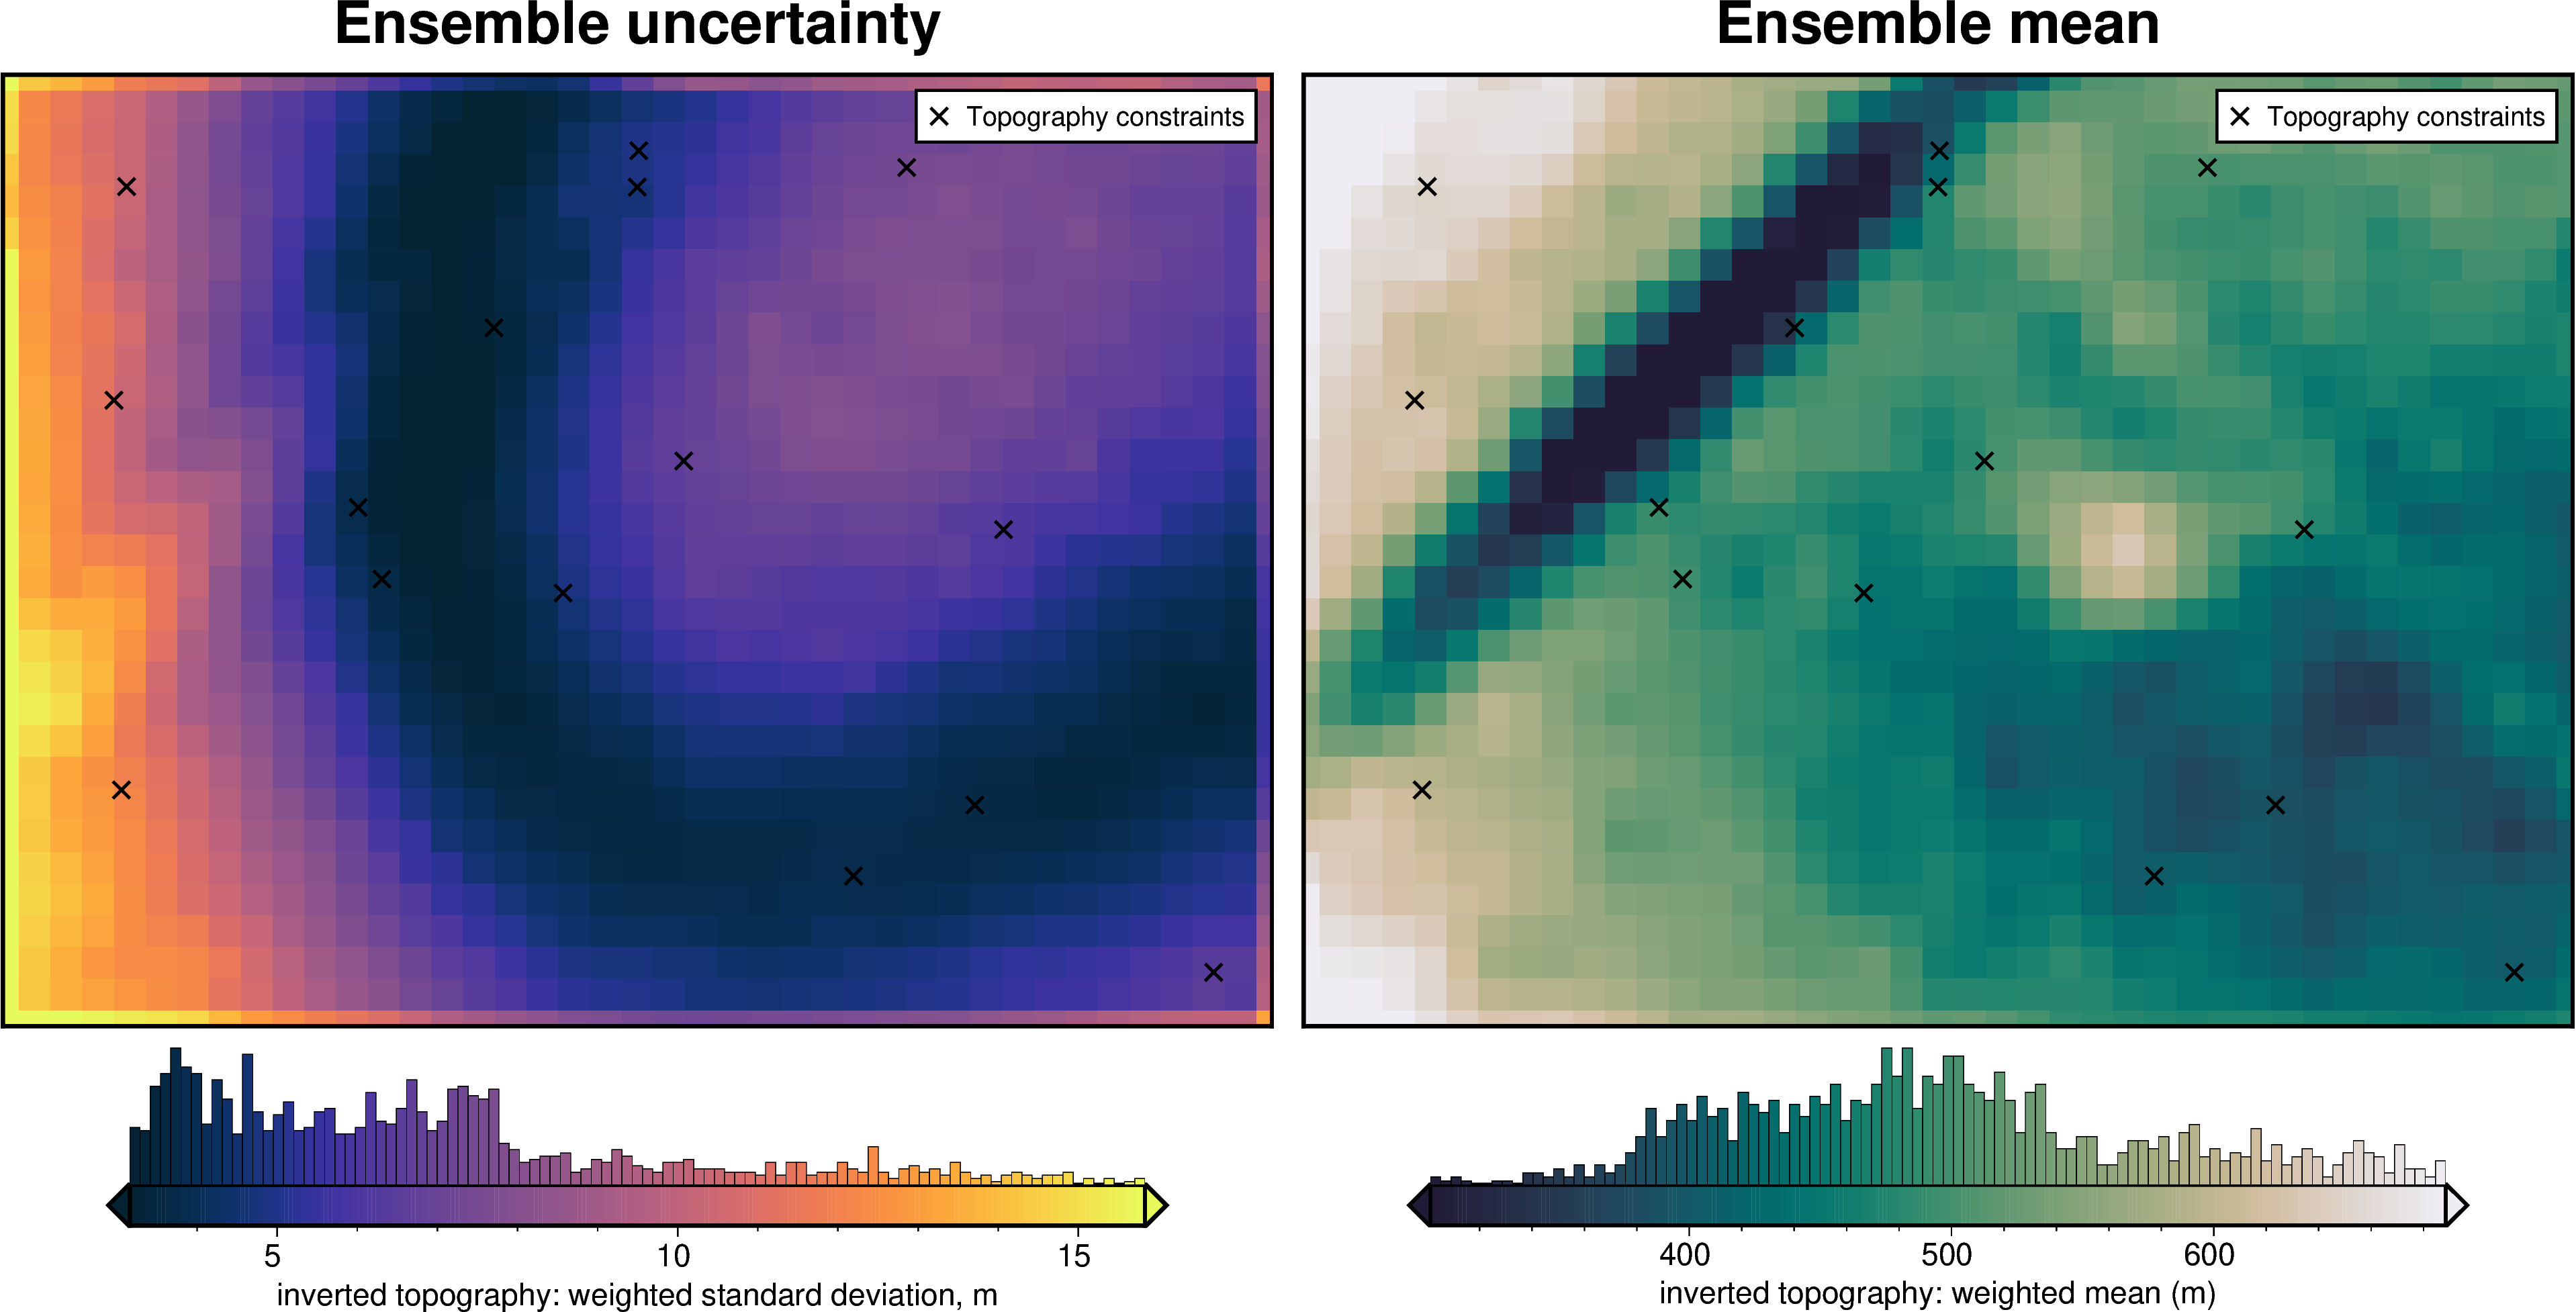

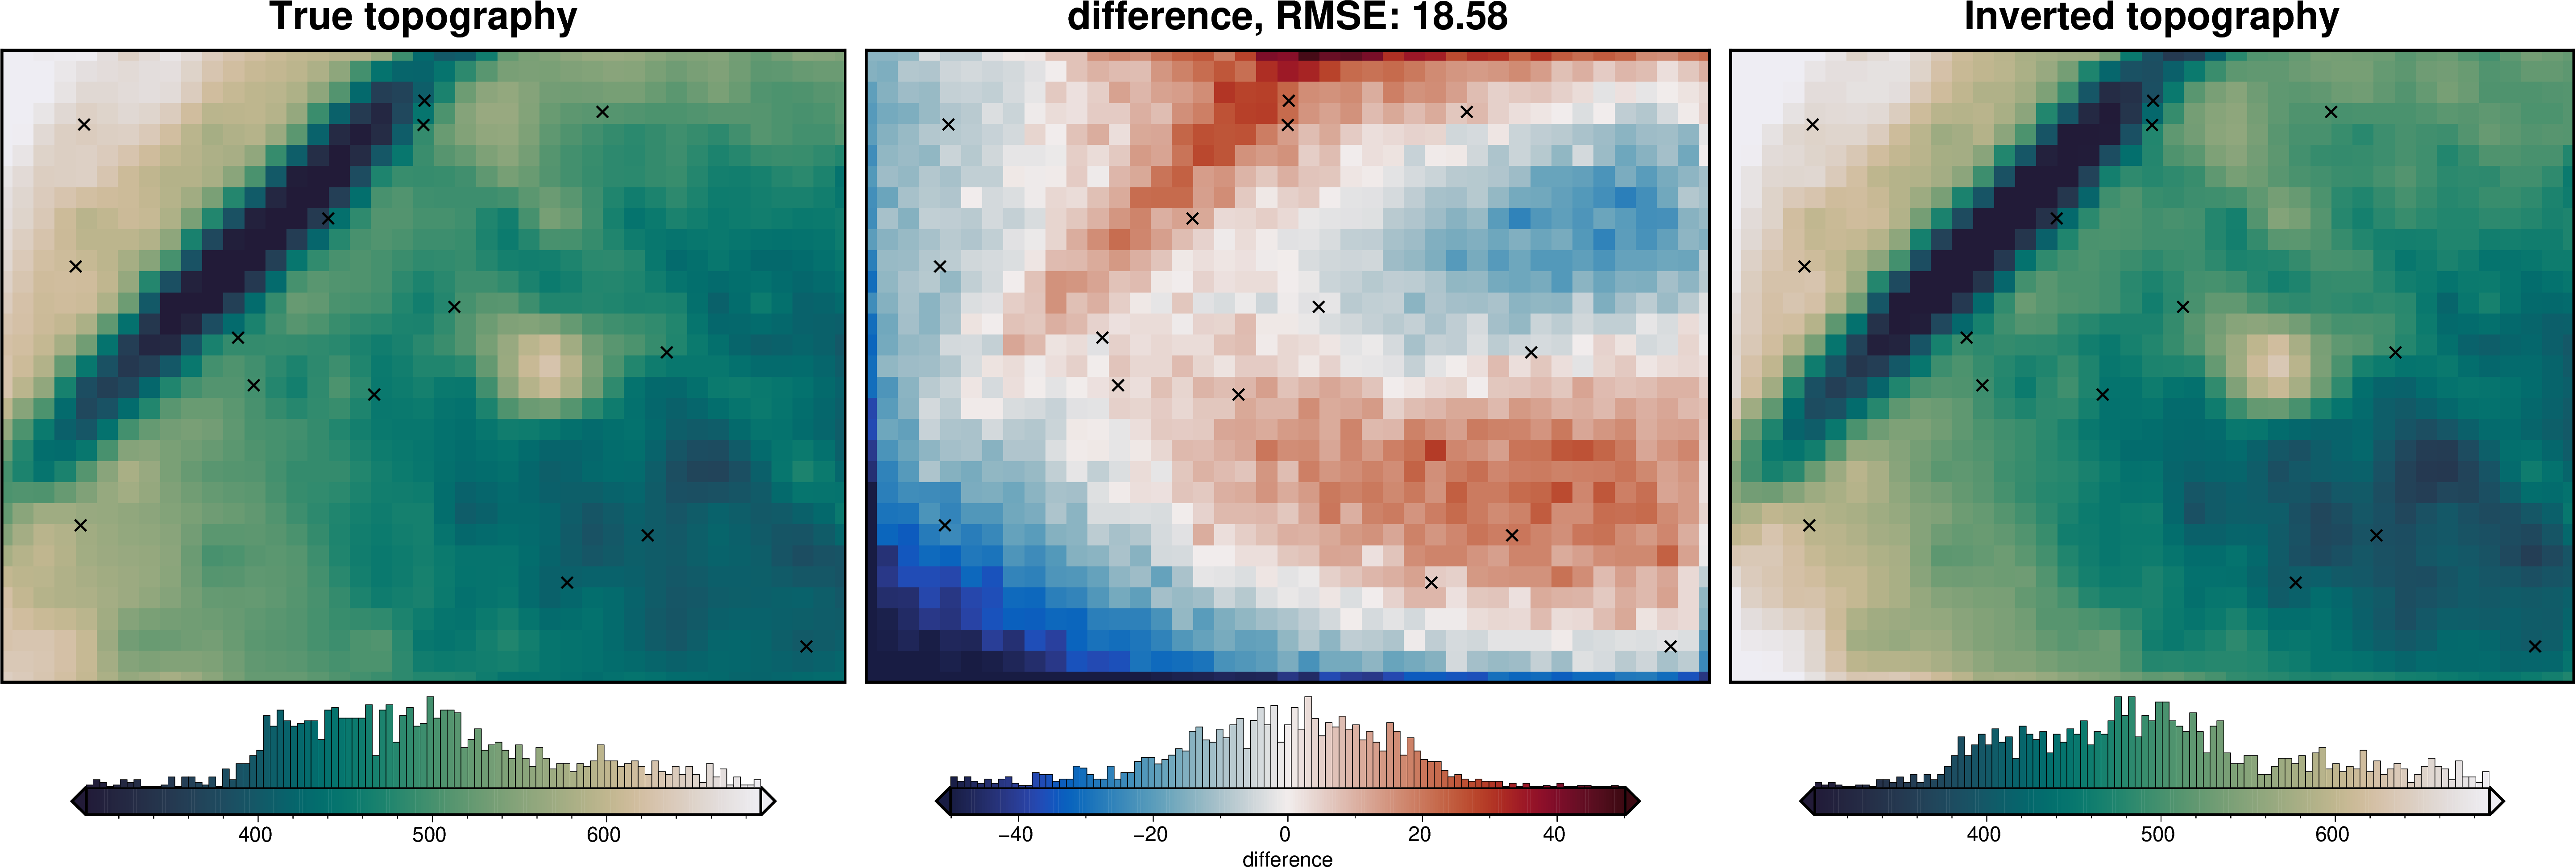

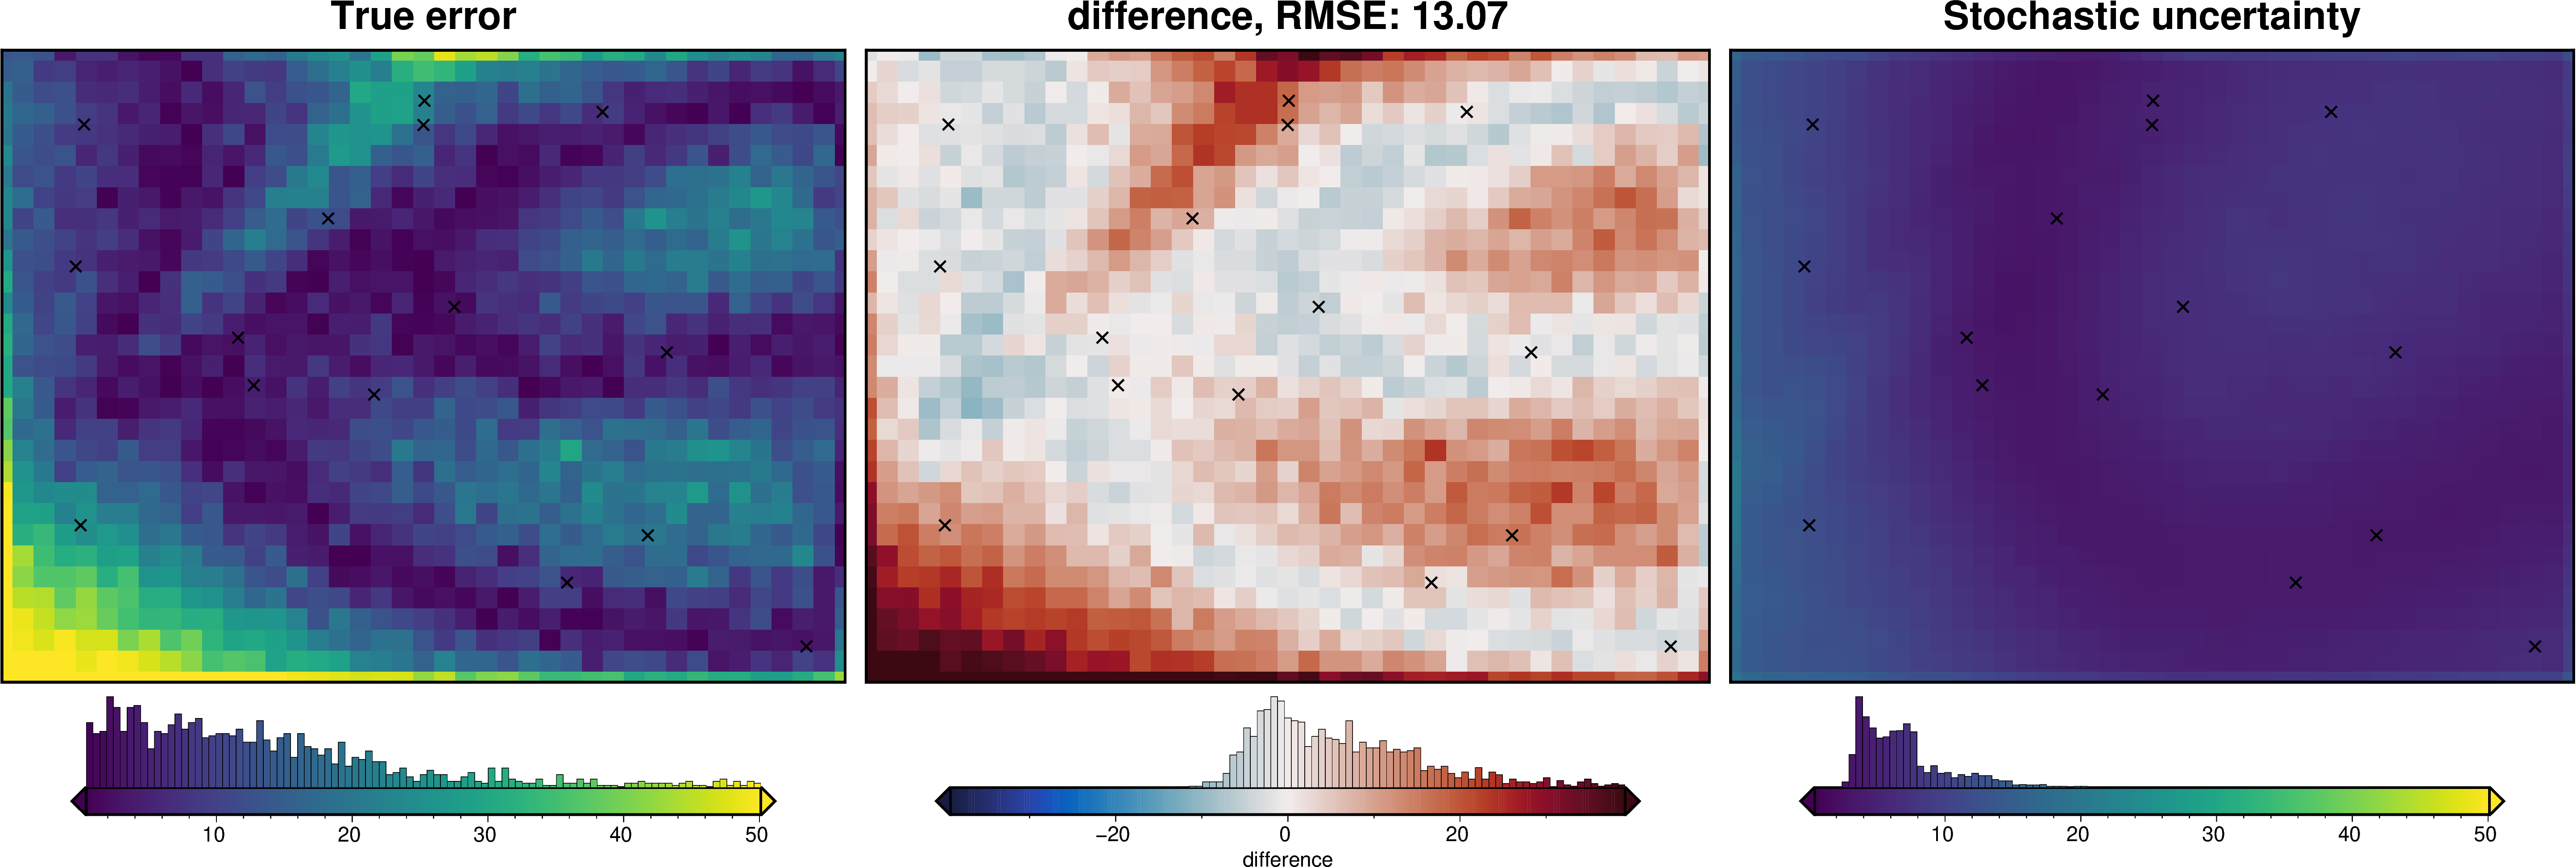

In [27]:
fname = "tmp/uncertainty_constraints"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_constraints_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_constraints_results)

### Inversion parameters component

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.042373890398093264, min: 0.002454530084483668, max: 0.22383724096500762
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_params' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_params'



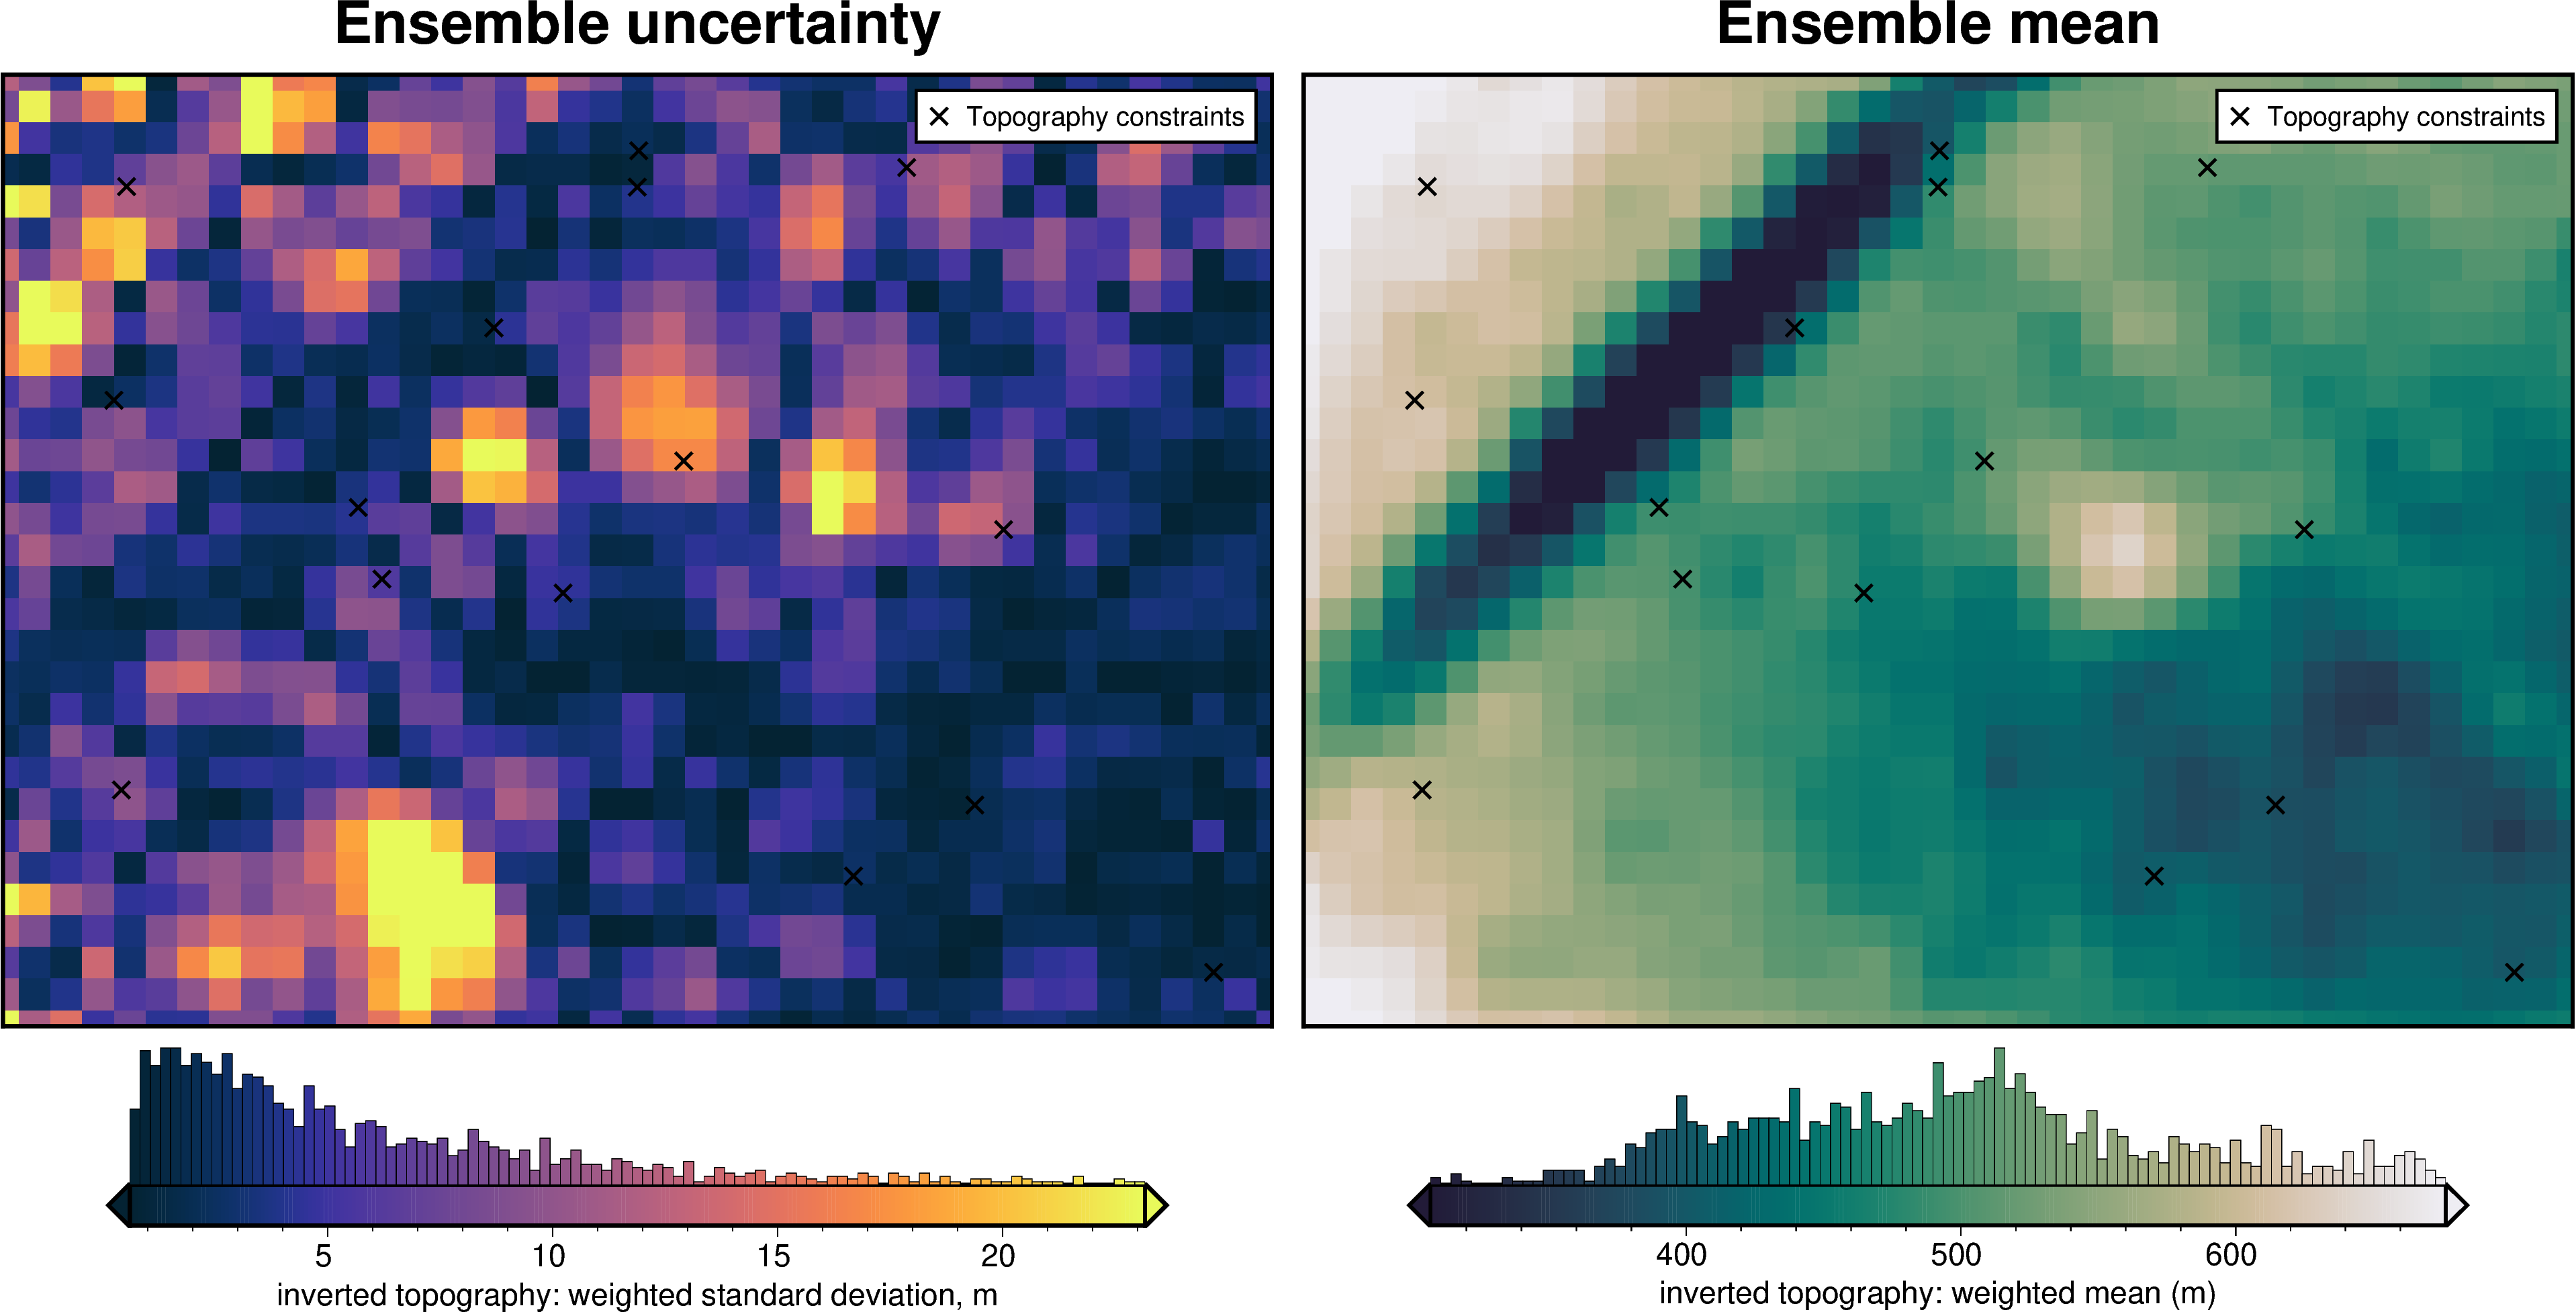

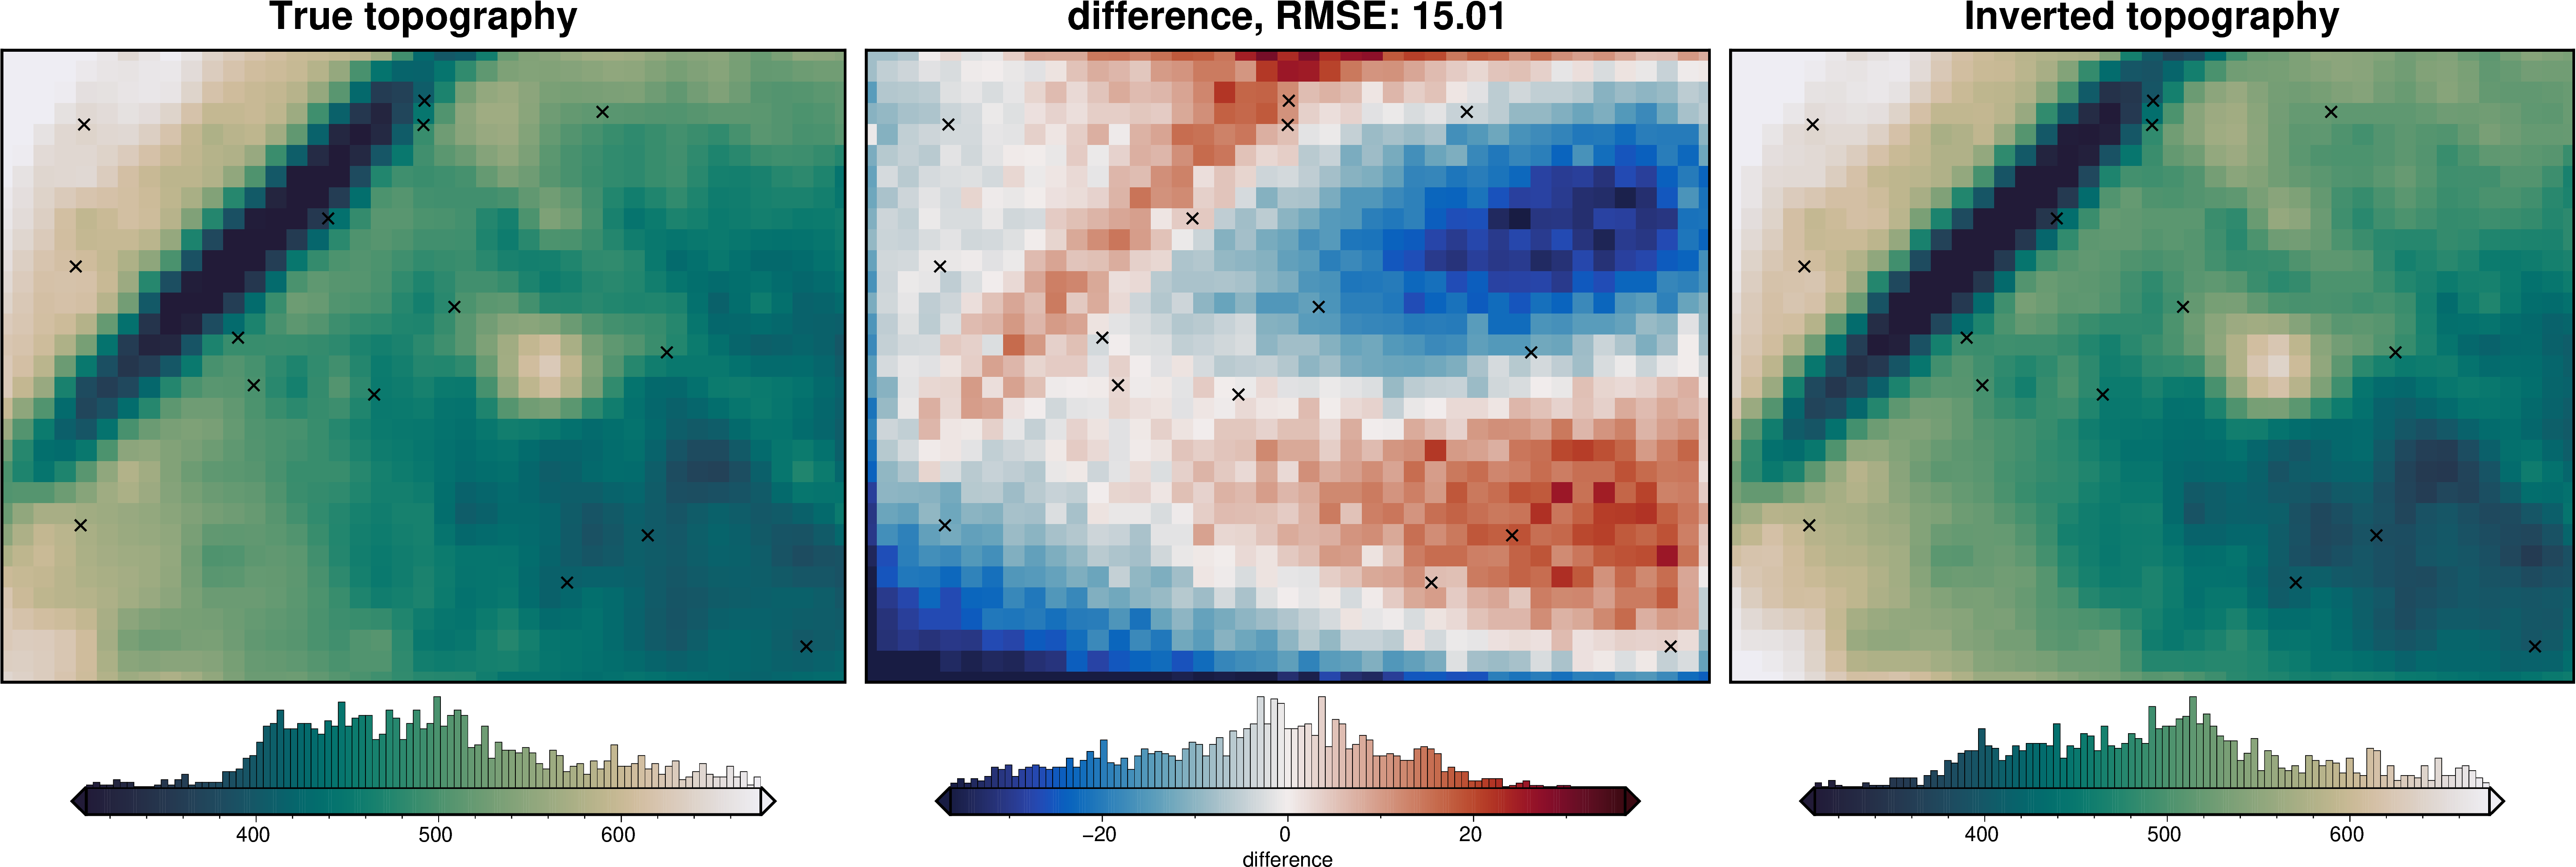

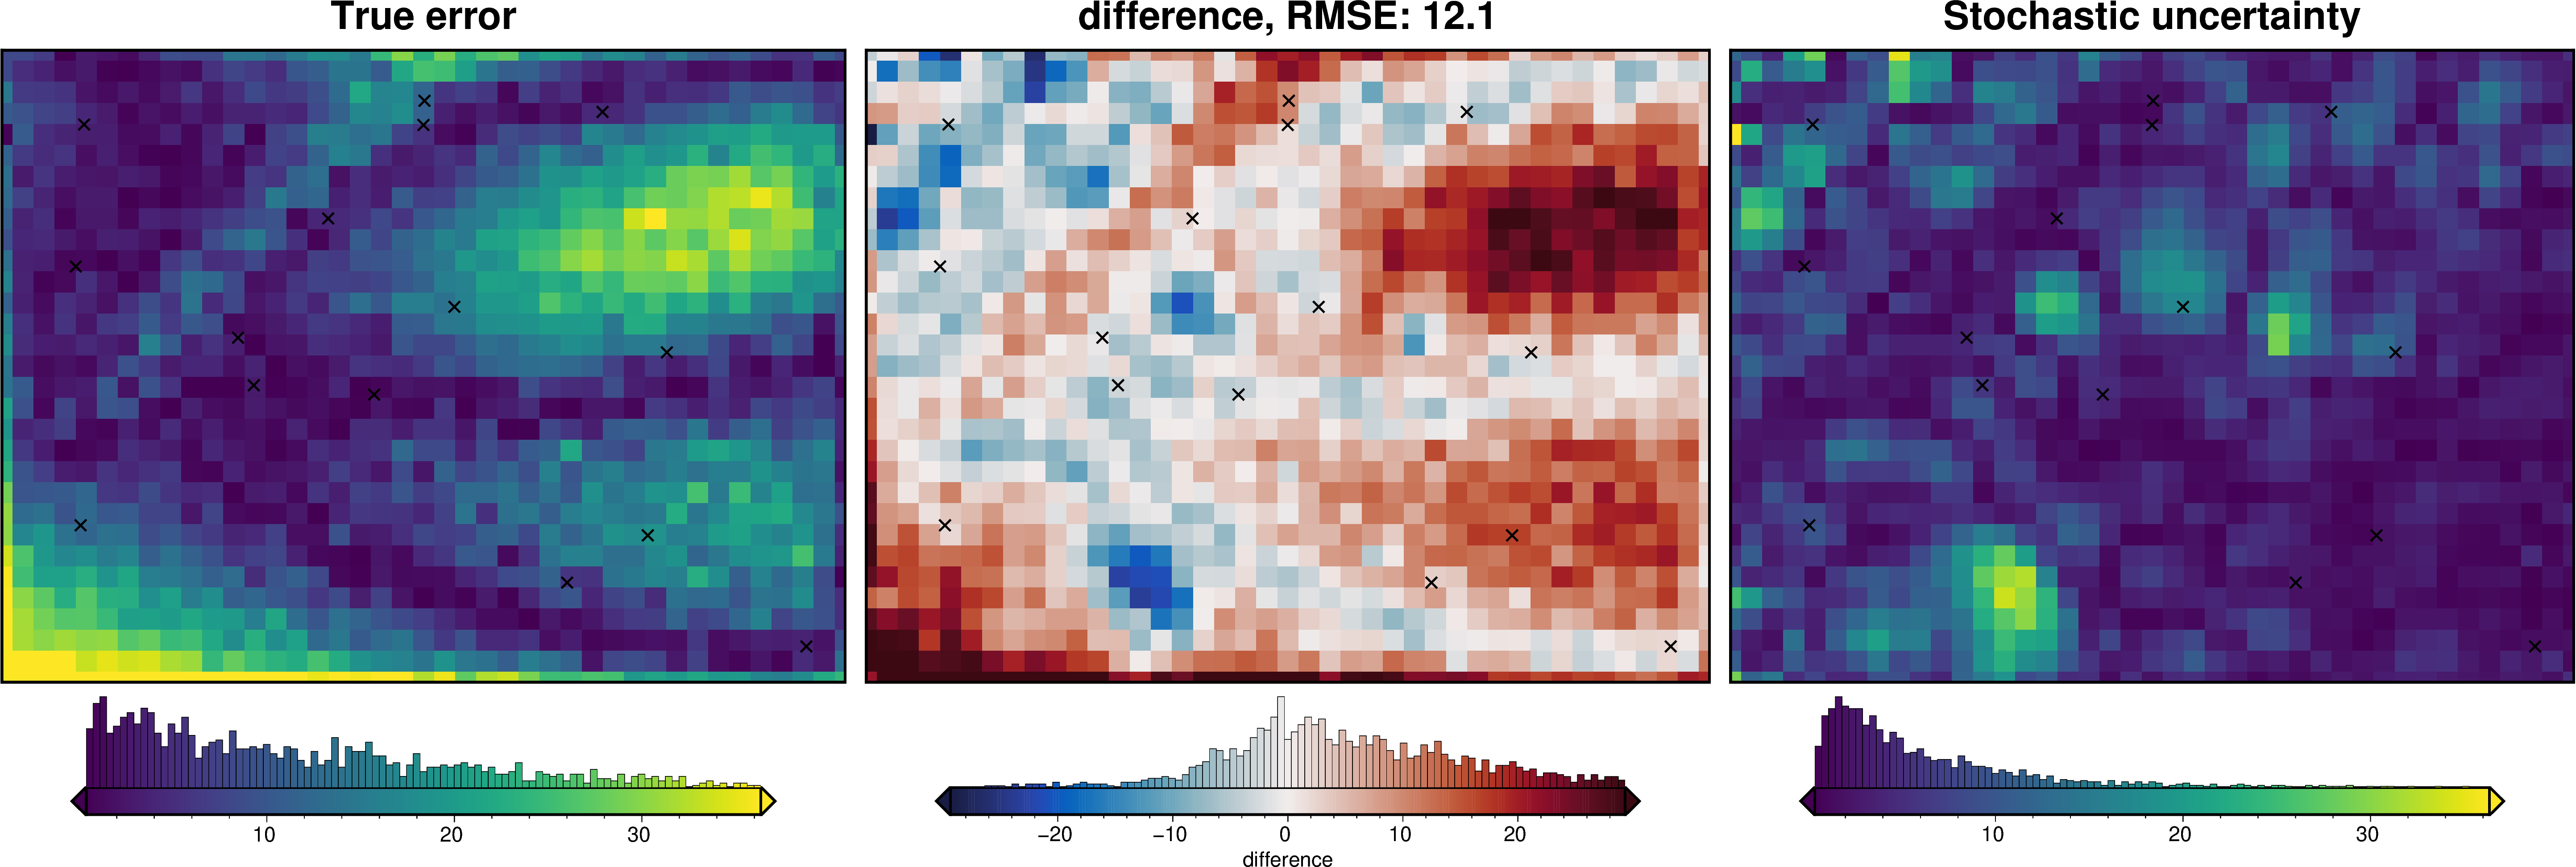

In [28]:
fname = "tmp/uncertainty_params"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_parameters_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    create_starting_prisms=True,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_parameters_results)

### Starting topography component

INFO:invert4geom:Sampled 'dampings' parameter values; mean: 3.986413368726571e-06, min: 2.3091510953564804e-07, max: 2.105796190575718e-05
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_starting_topo' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_starting_topo'



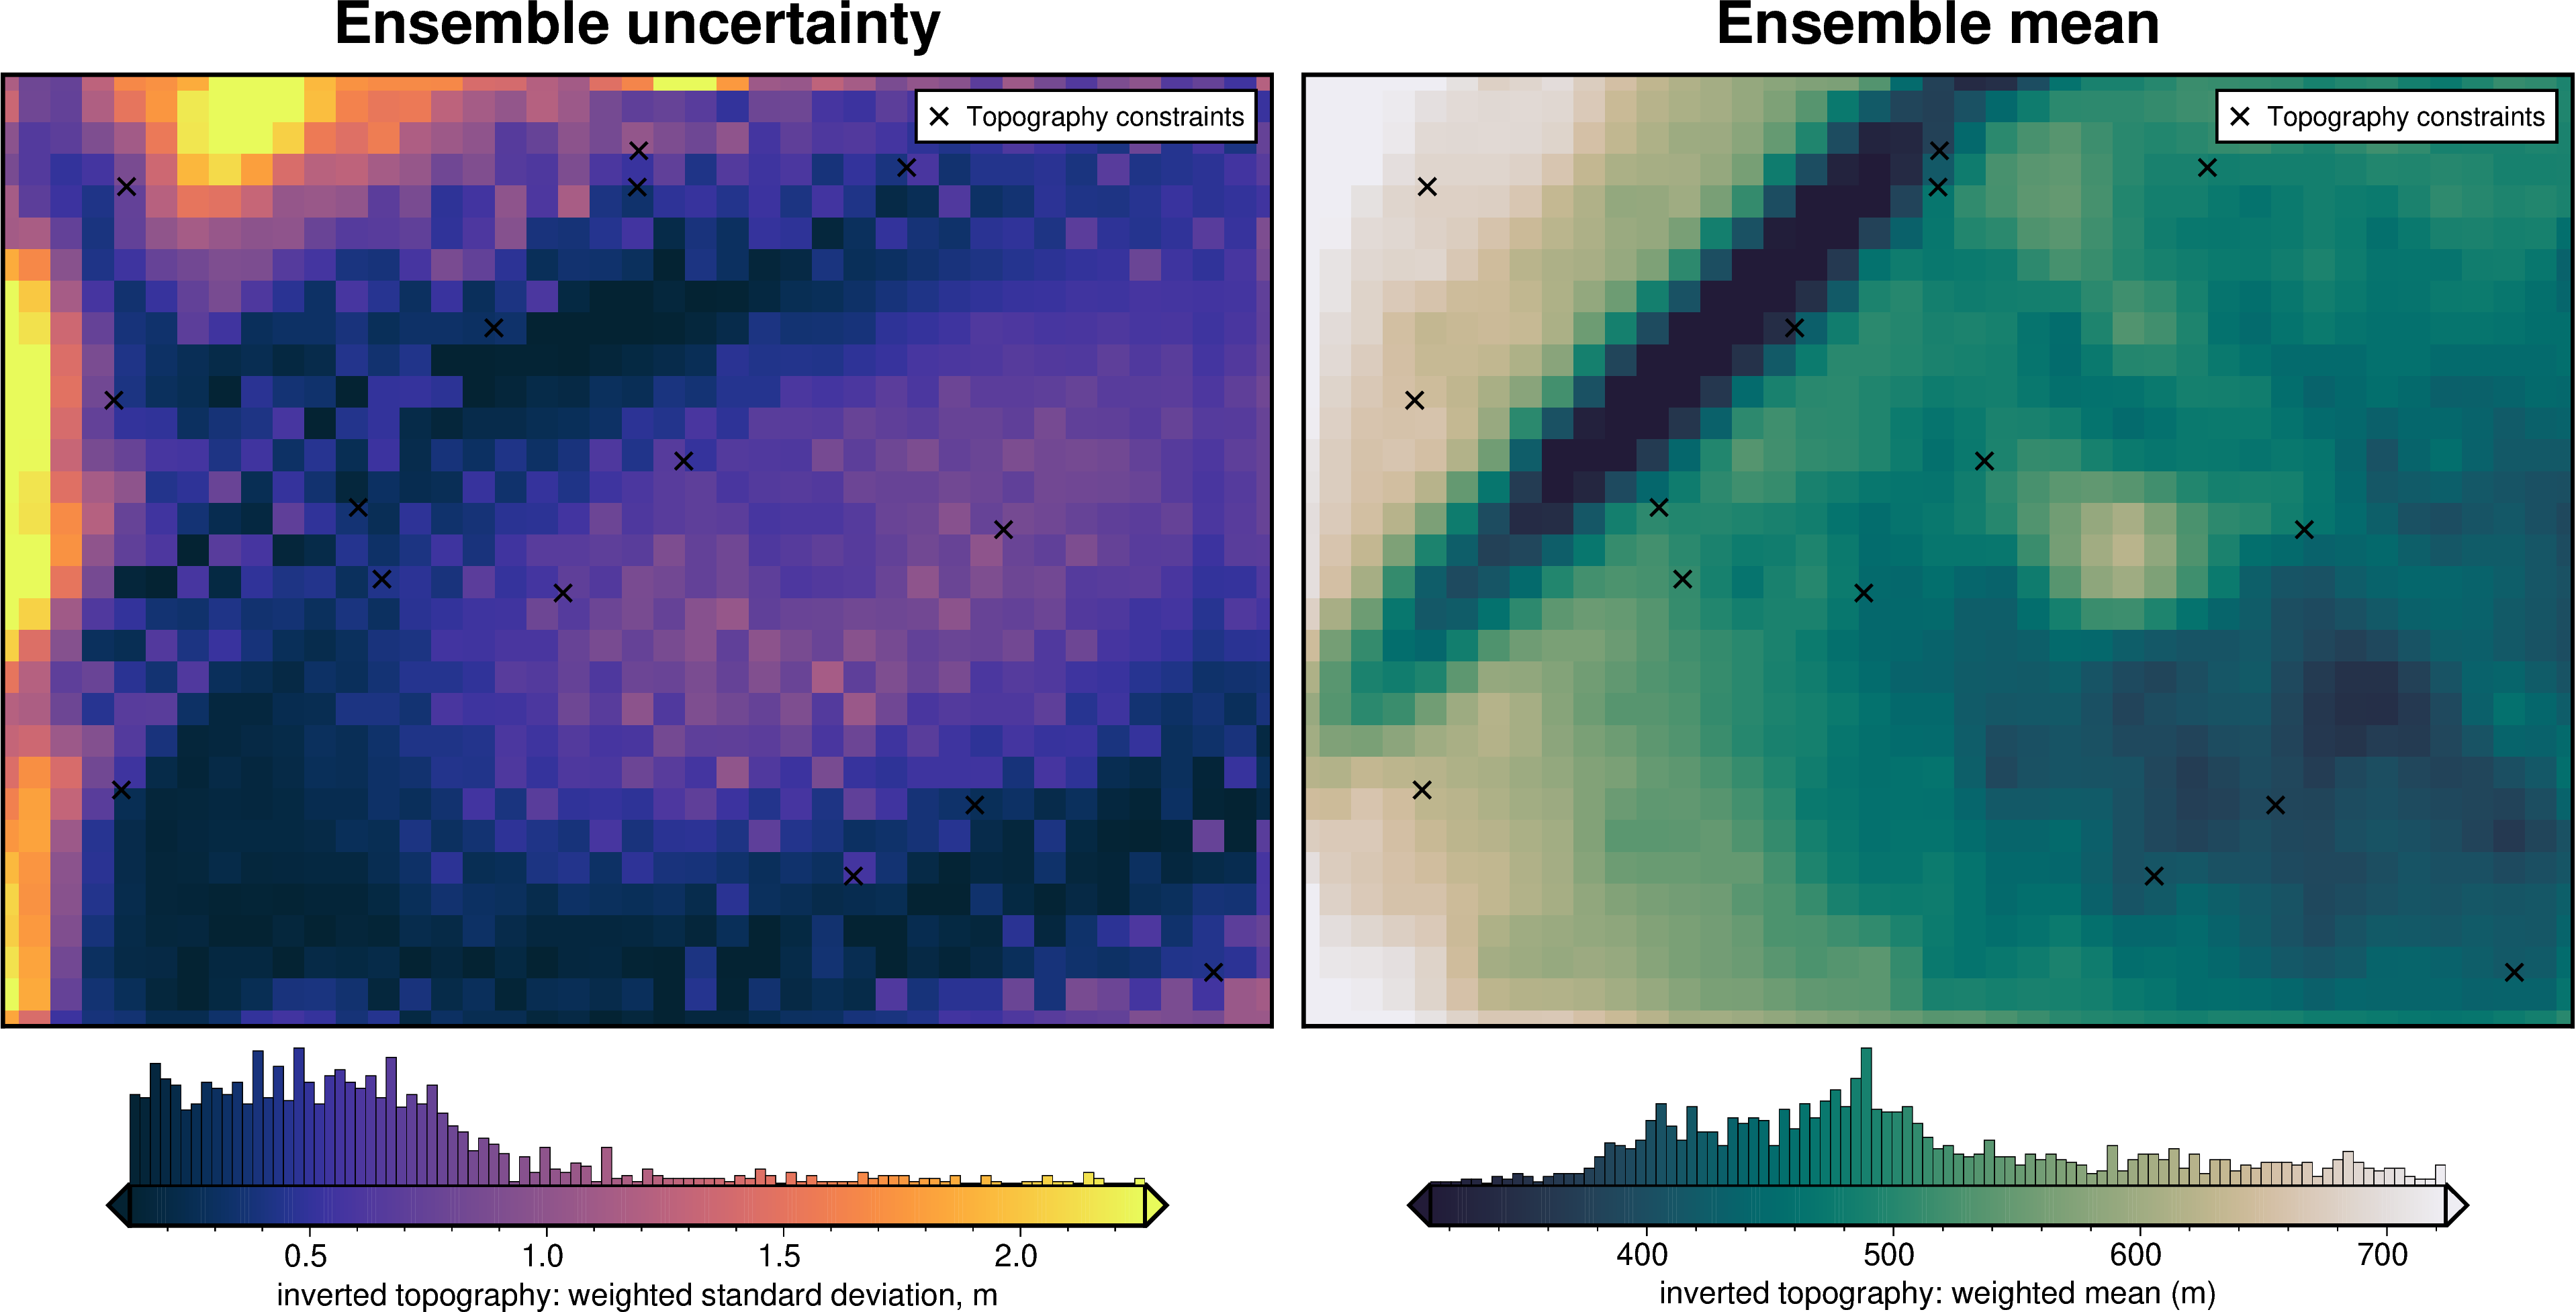

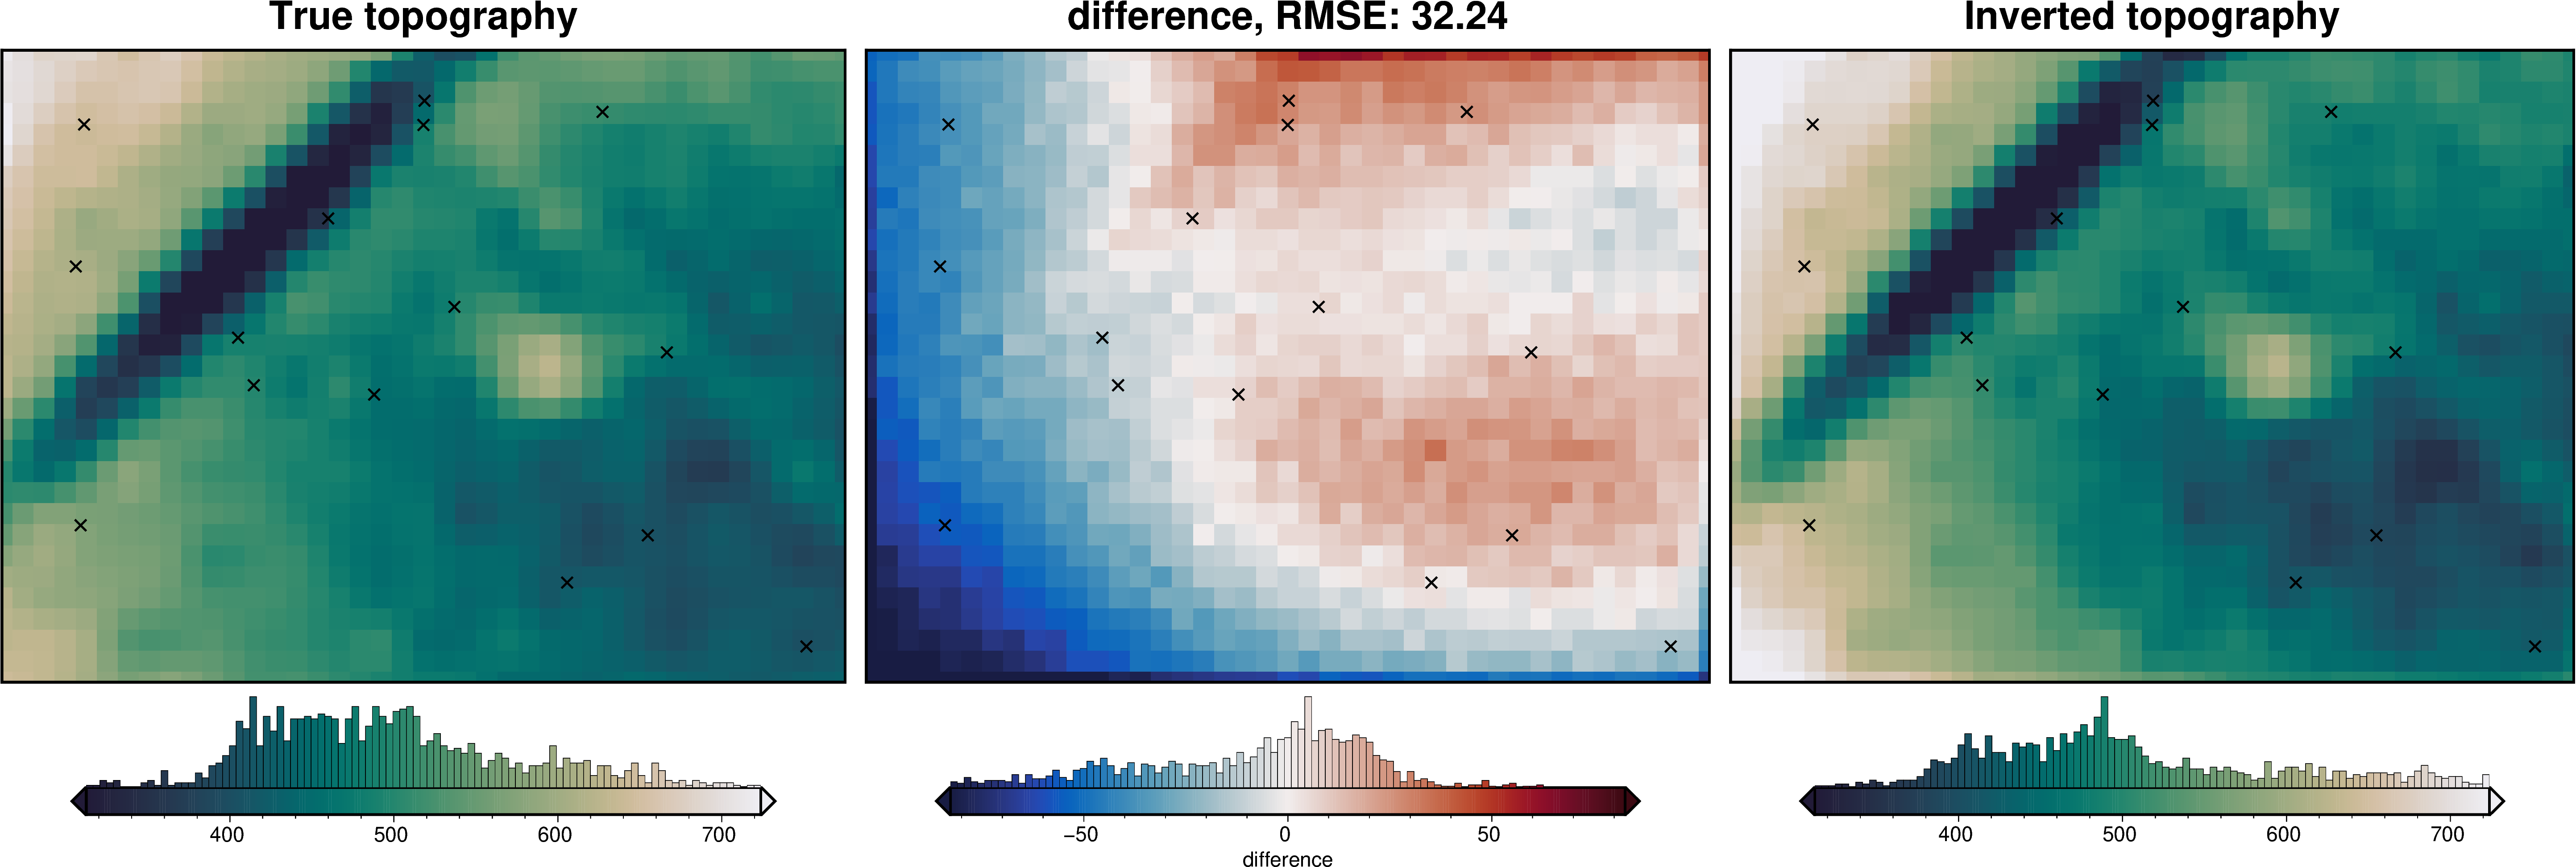

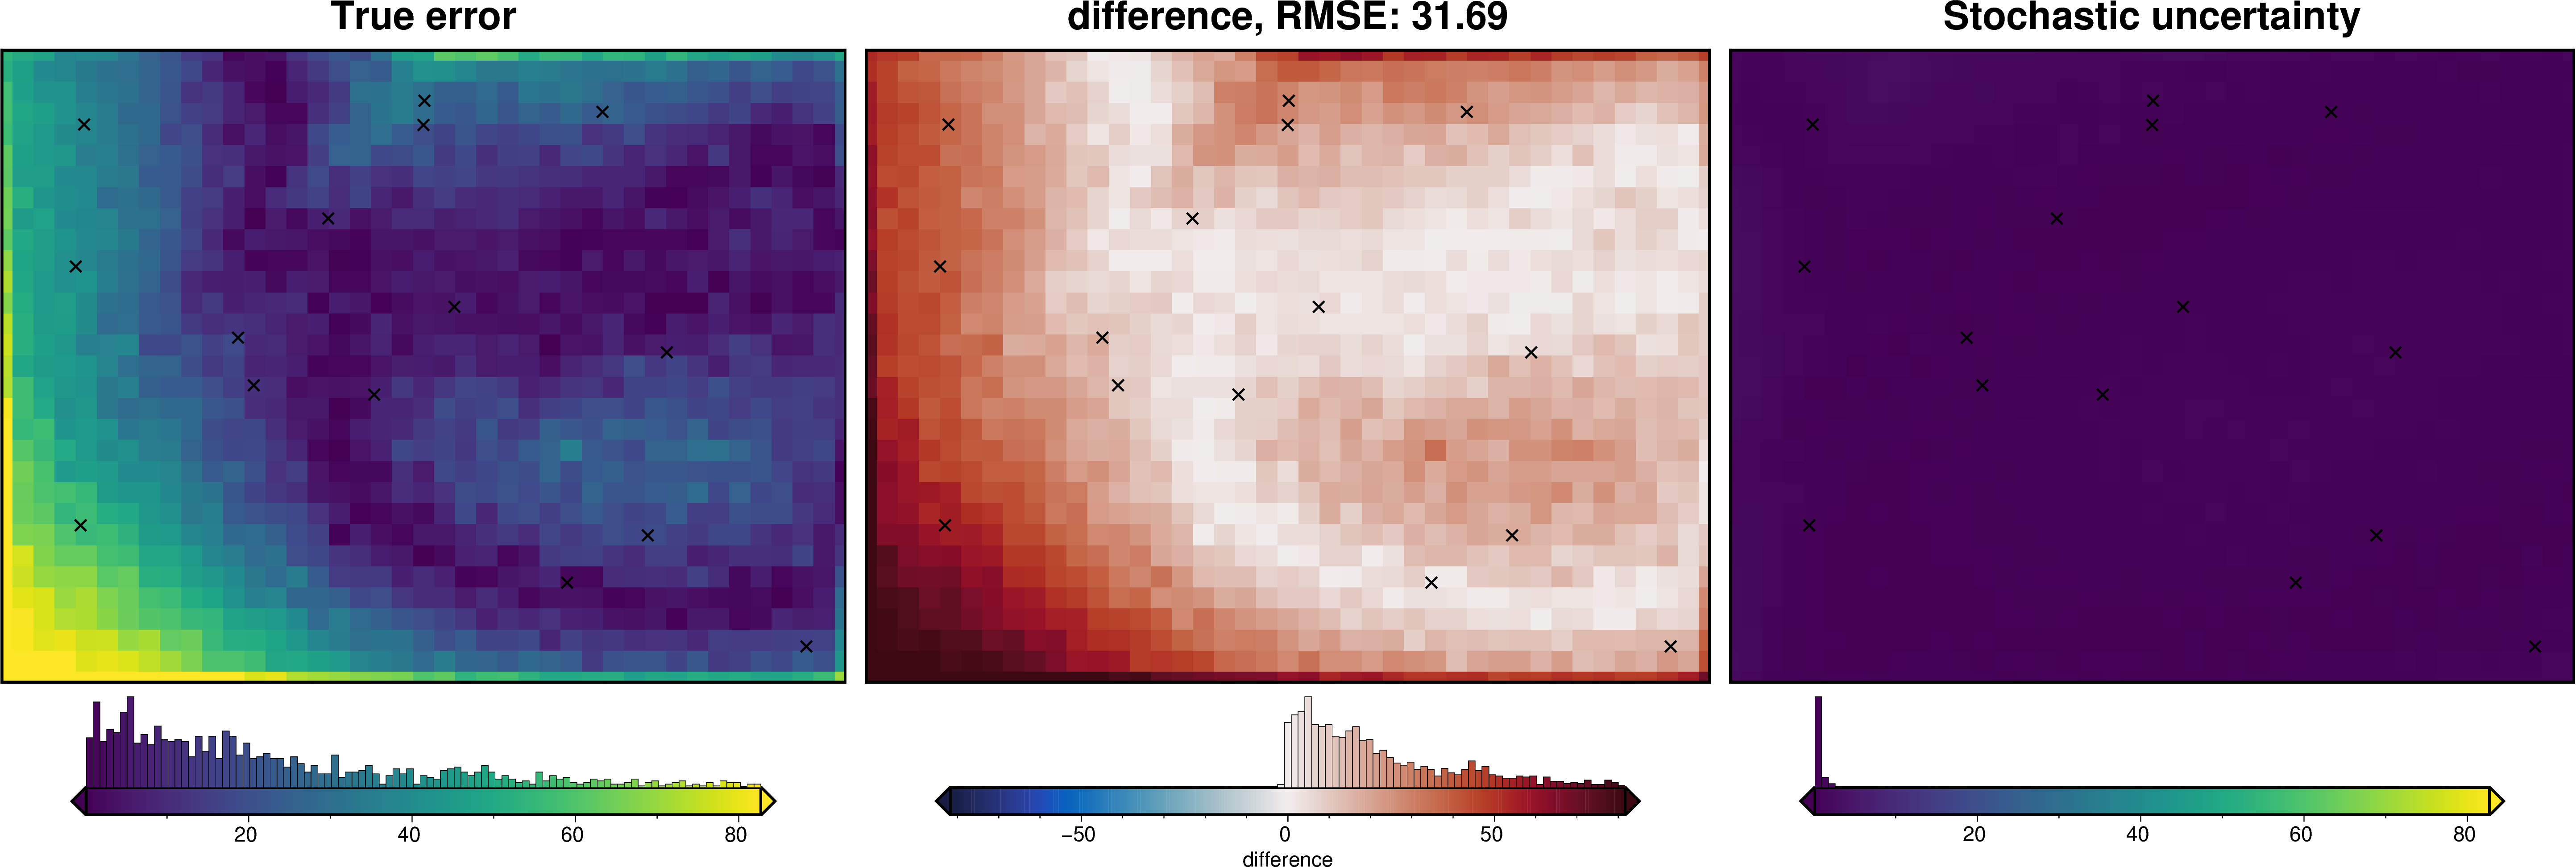

In [29]:
fname = "tmp/uncertainty_starting_topo"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_starting_topo_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    starting_topography_parameter_dict=starting_topography_parameter_dict,
    # regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    # calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_starting_topo_results)

### Regional gravity component

INFO:invert4geom:Sampled 'depth' parameter values; mean: 23796.415162690966, min: 14487.817466697146, max: 33105.012858684786
INFO:invert4geom:Sampled 'damping' parameter values; mean: 0.15254884051283088, min: 0.00020686026106998004, max: 1.7203033598166477
INFO:invert4geom:No pickle files starting with 'tmp/uncertainty_regional' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: 'tmp/uncertainty_regional'



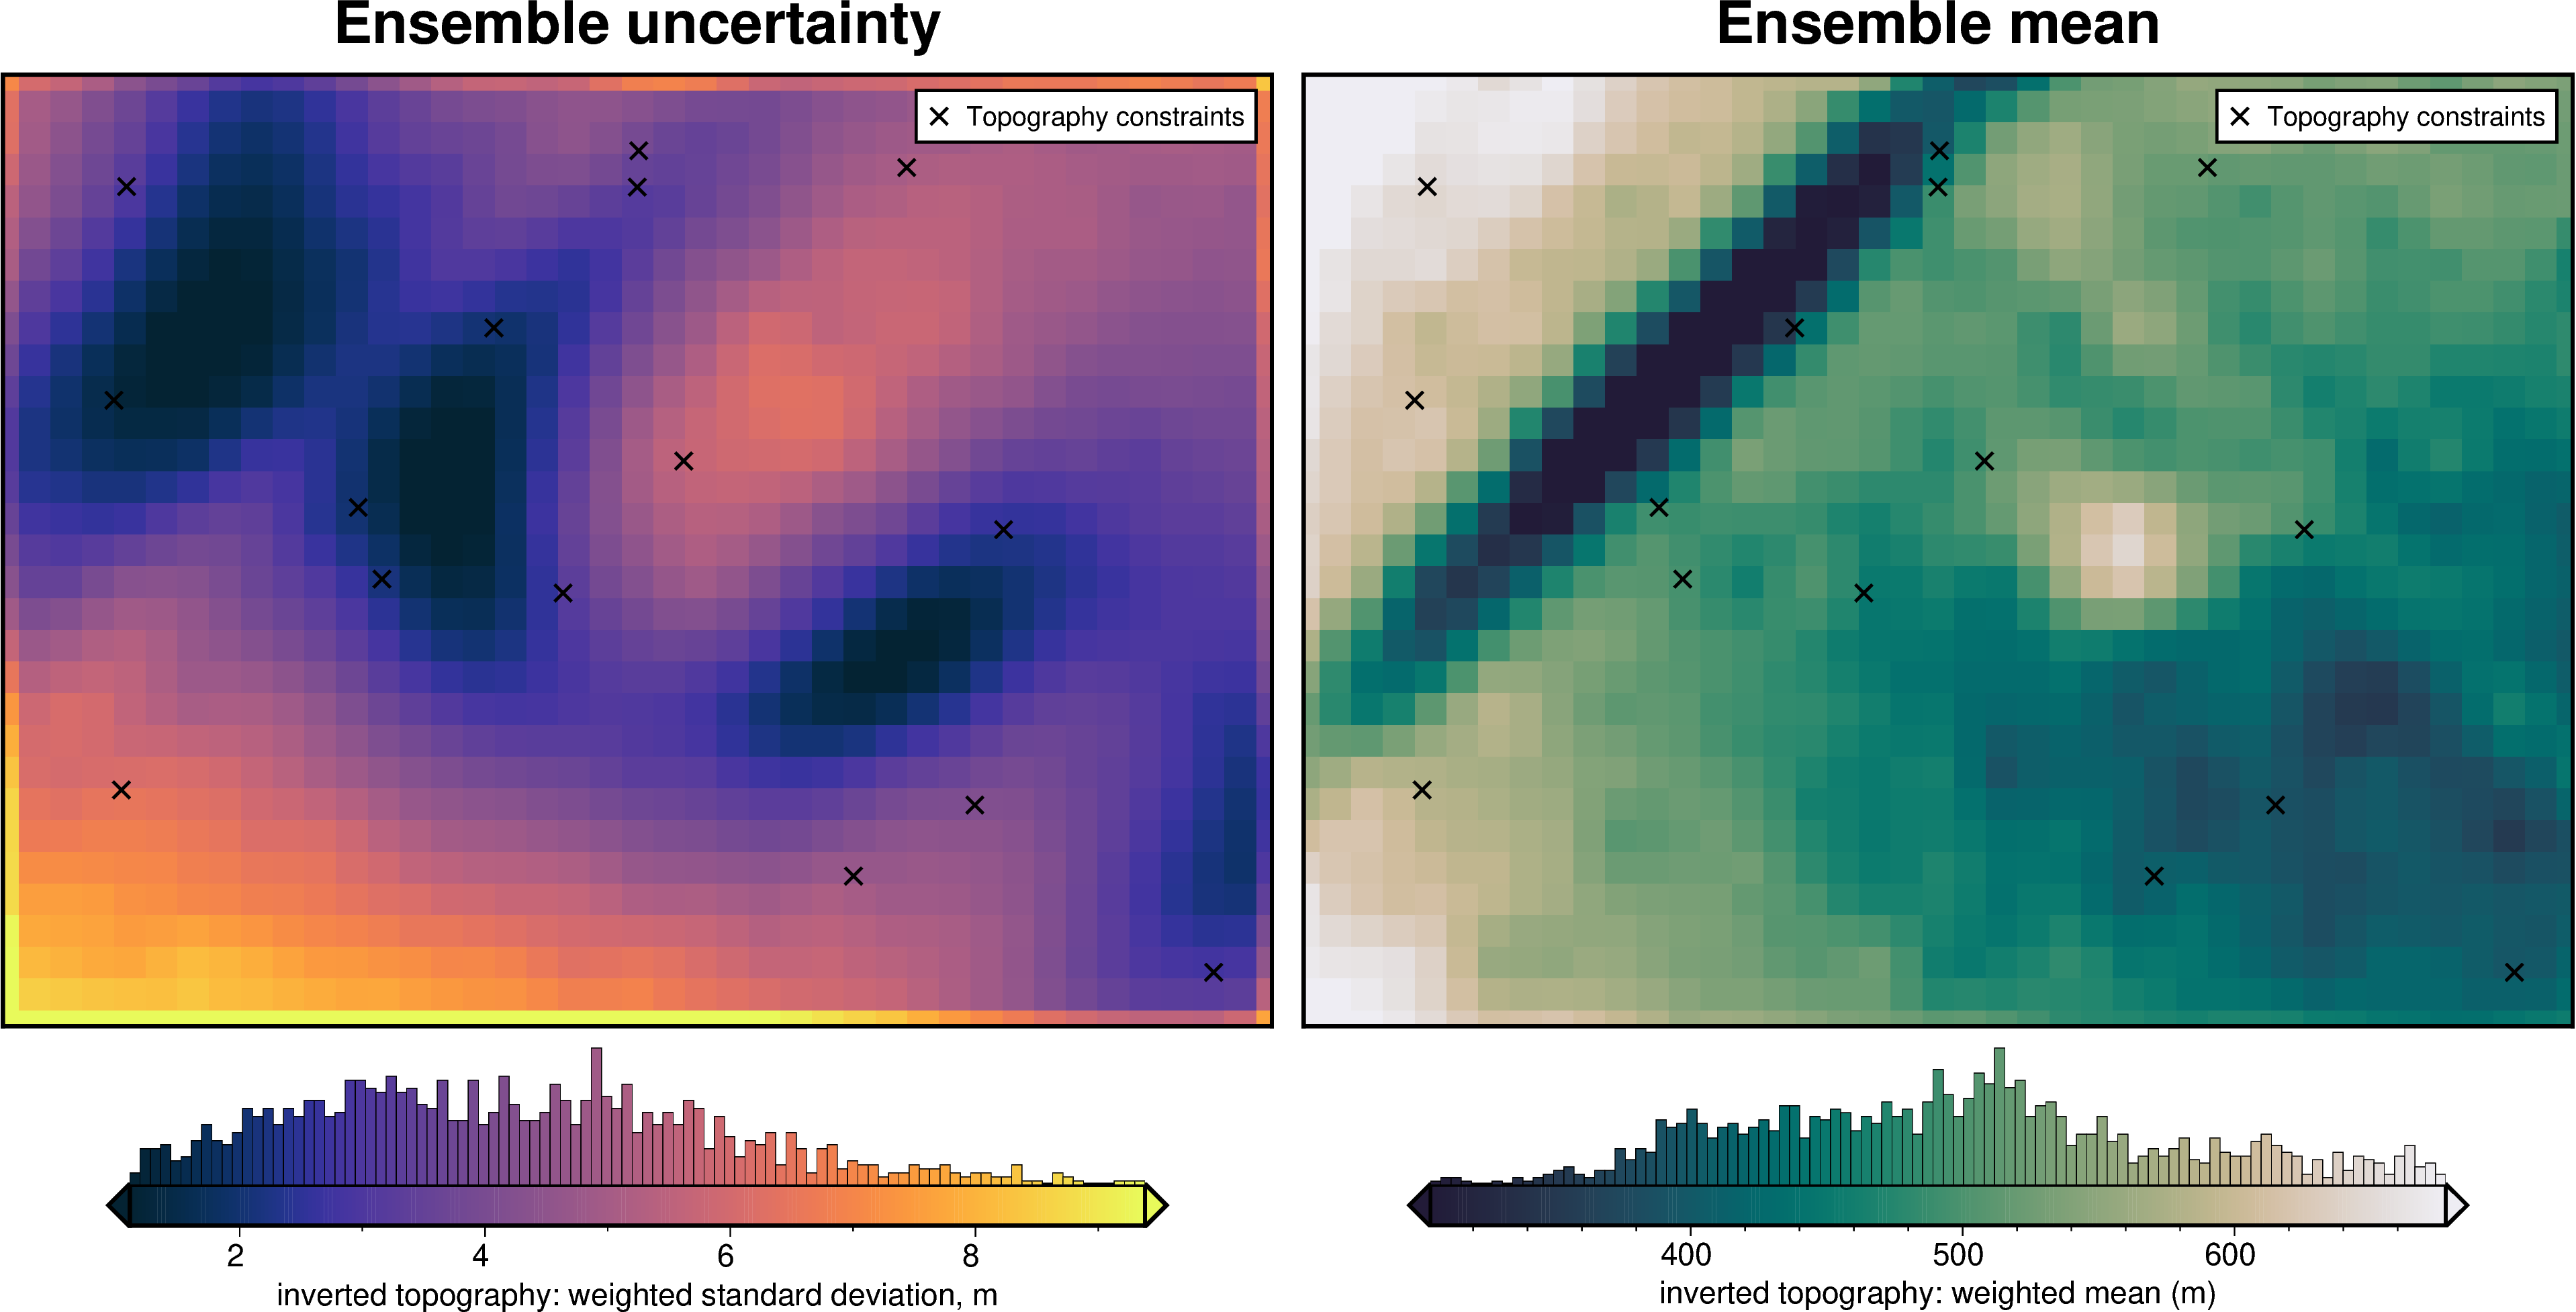

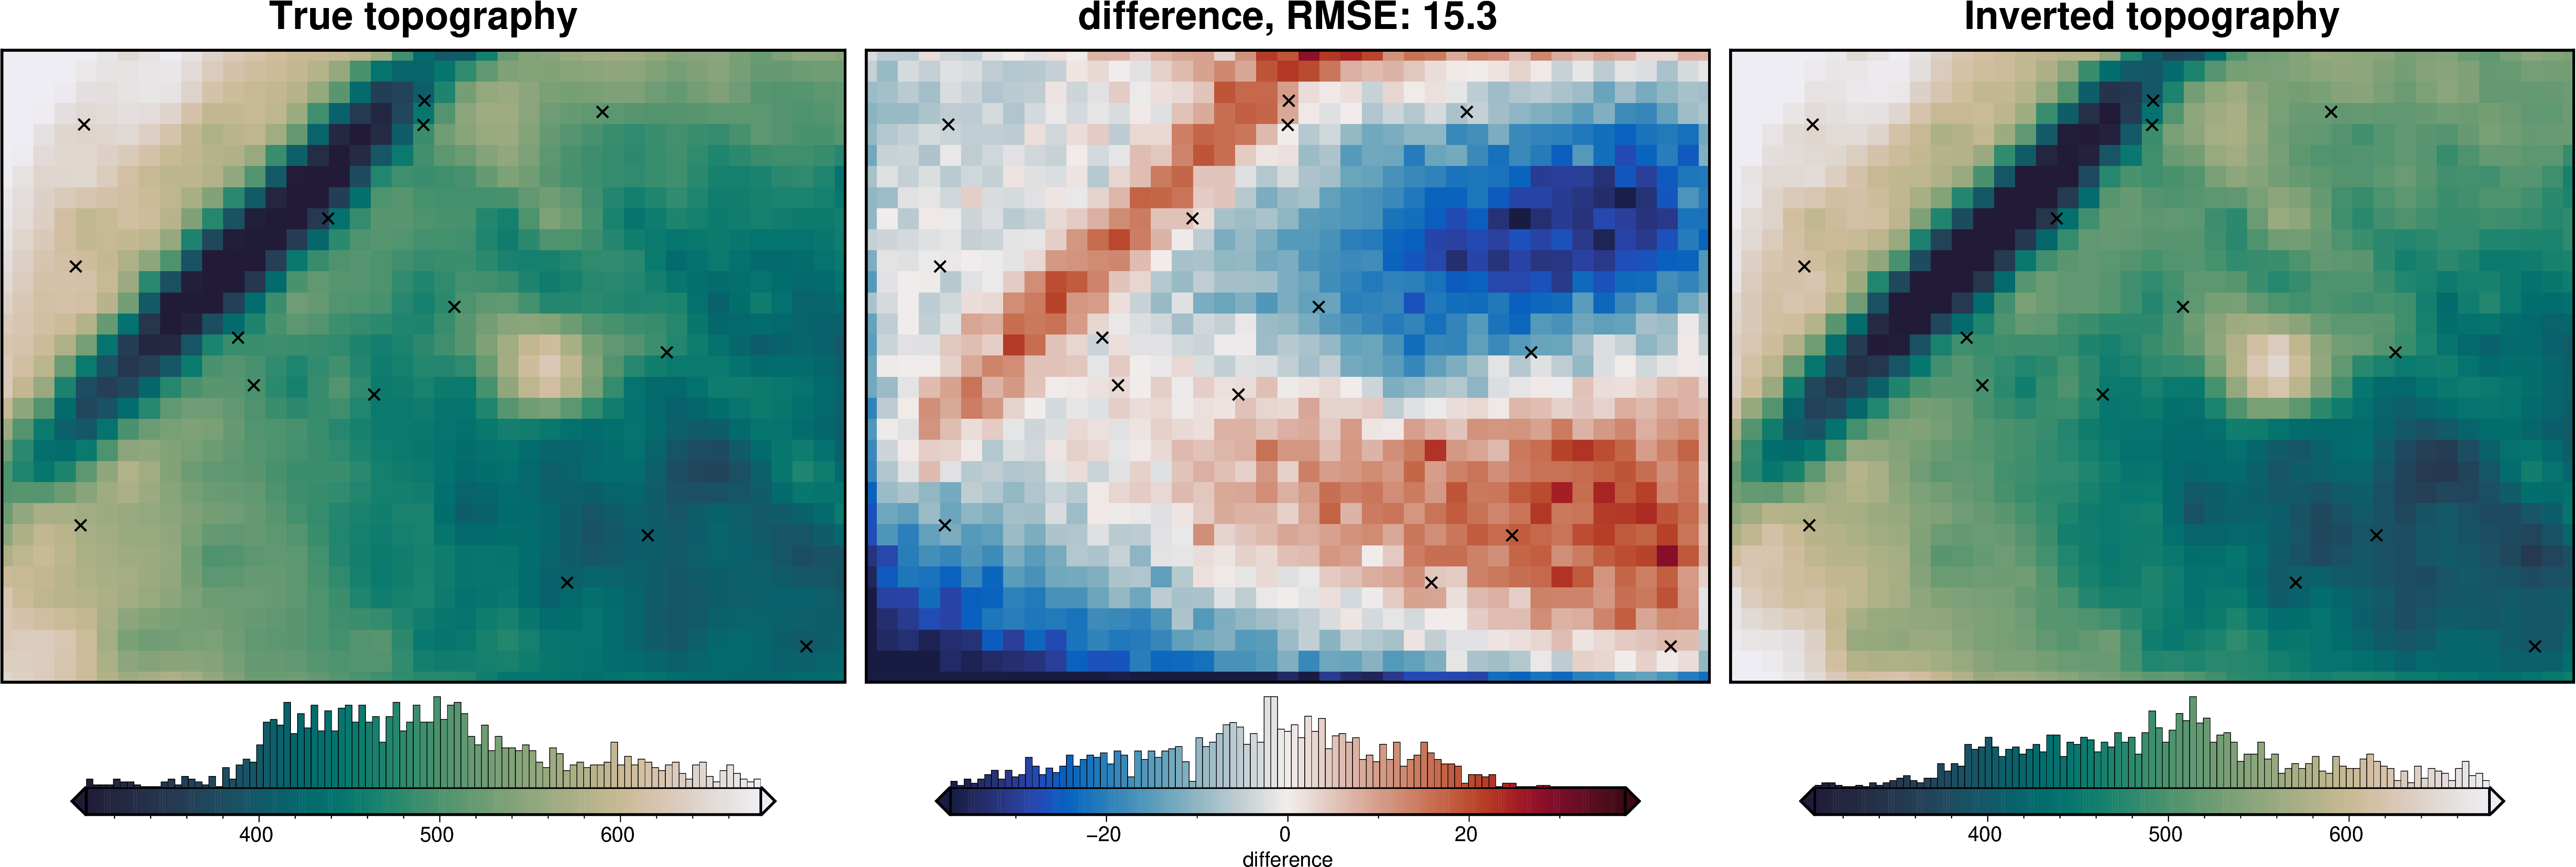

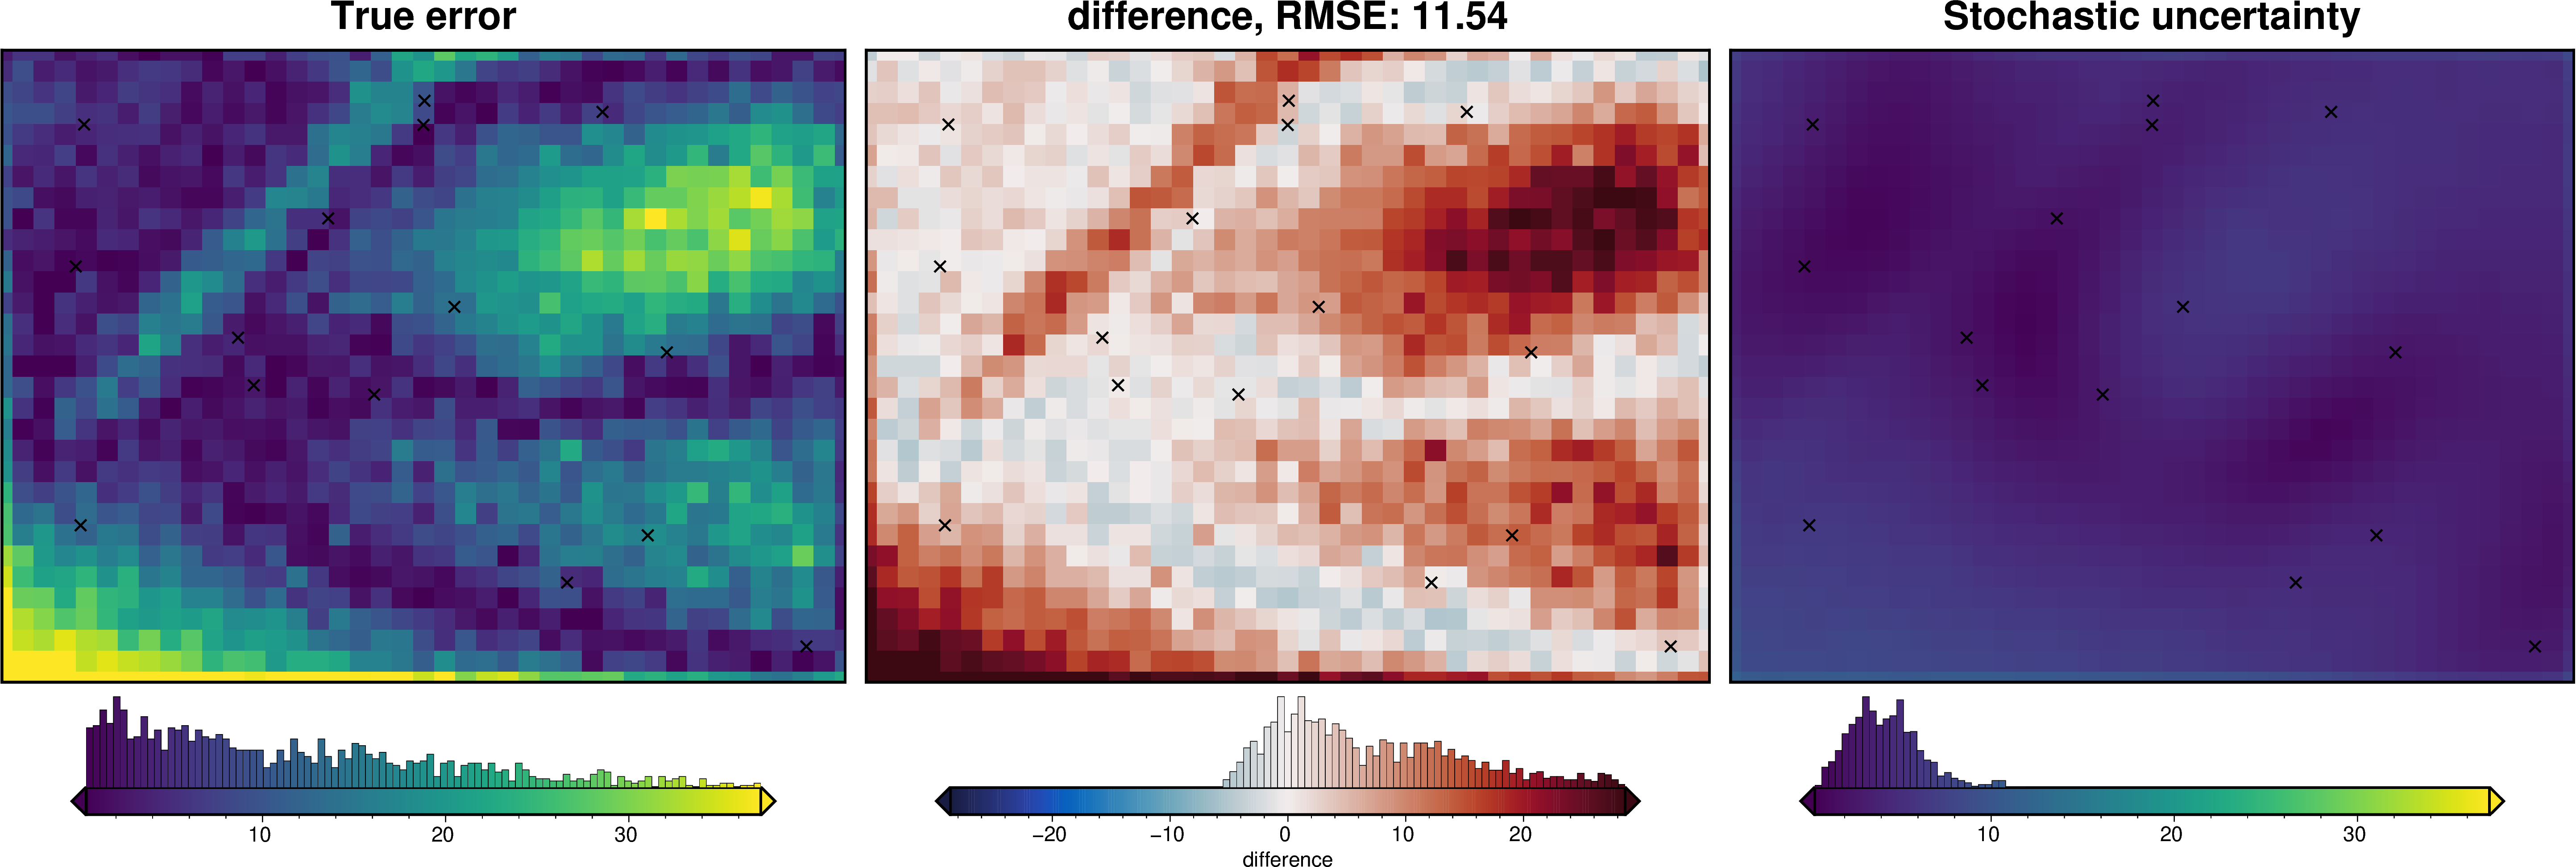

In [30]:
fname = "tmp/uncertainty_regional"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_regional_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    # choose what to sample
    # sample_gravity=True,
    # sample_constraints=True,
    # parameter_dict=parameter_dict,
    # starting_topography_parameter_dict=starting_topography_parameter_dict,
    regional_misfit_parameter_dict=regional_misfit_parameter_dict,
    # choose what to do
    # create_starting_topography=True,
    # create_starting_prisms=True,
    # calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    **uncert_kwargs,
)

uncert_plots(uncert_regional_results)

## Comparing results

In [31]:
results = [
    uncert_results,
    uncert_grav_results,
    uncert_constraints_results,
    uncert_parameters_results,
    uncert_starting_topo_results,
    uncert_regional_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
    )
    stats.append(ds)

In [32]:
names = ["full", "grav", "constraints", "parameters", "topo", "regional"]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 62kB
Dimensions:            (northing: 31, easting: 41)
Coordinates:
  * northing           (northing) float64 248B 0.0 1e+03 2e+03 ... 2.9e+04 3e+04
  * easting            (easting) float64 328B 0.0 1e+03 2e+03 ... 3.9e+04 4e+04
Data variables:
    full_stdev         (northing, easting) float64 10kB 25.27 27.31 ... 24.99
    grav_stdev         (northing, easting) float64 10kB 2.555 3.962 ... 2.012
    constraints_stdev  (northing, easting) float64 10kB 18.74 16.54 ... 11.57
    parameters_stdev   (northing, easting) float64 10kB 28.83 11.51 ... 5.13
    topo_stdev         (northing, easting) float64 10kB 1.832 1.42 ... 1.224
    regional_stdev     (northing, easting) float64 10kB 11.62 10.47 ... 8.354

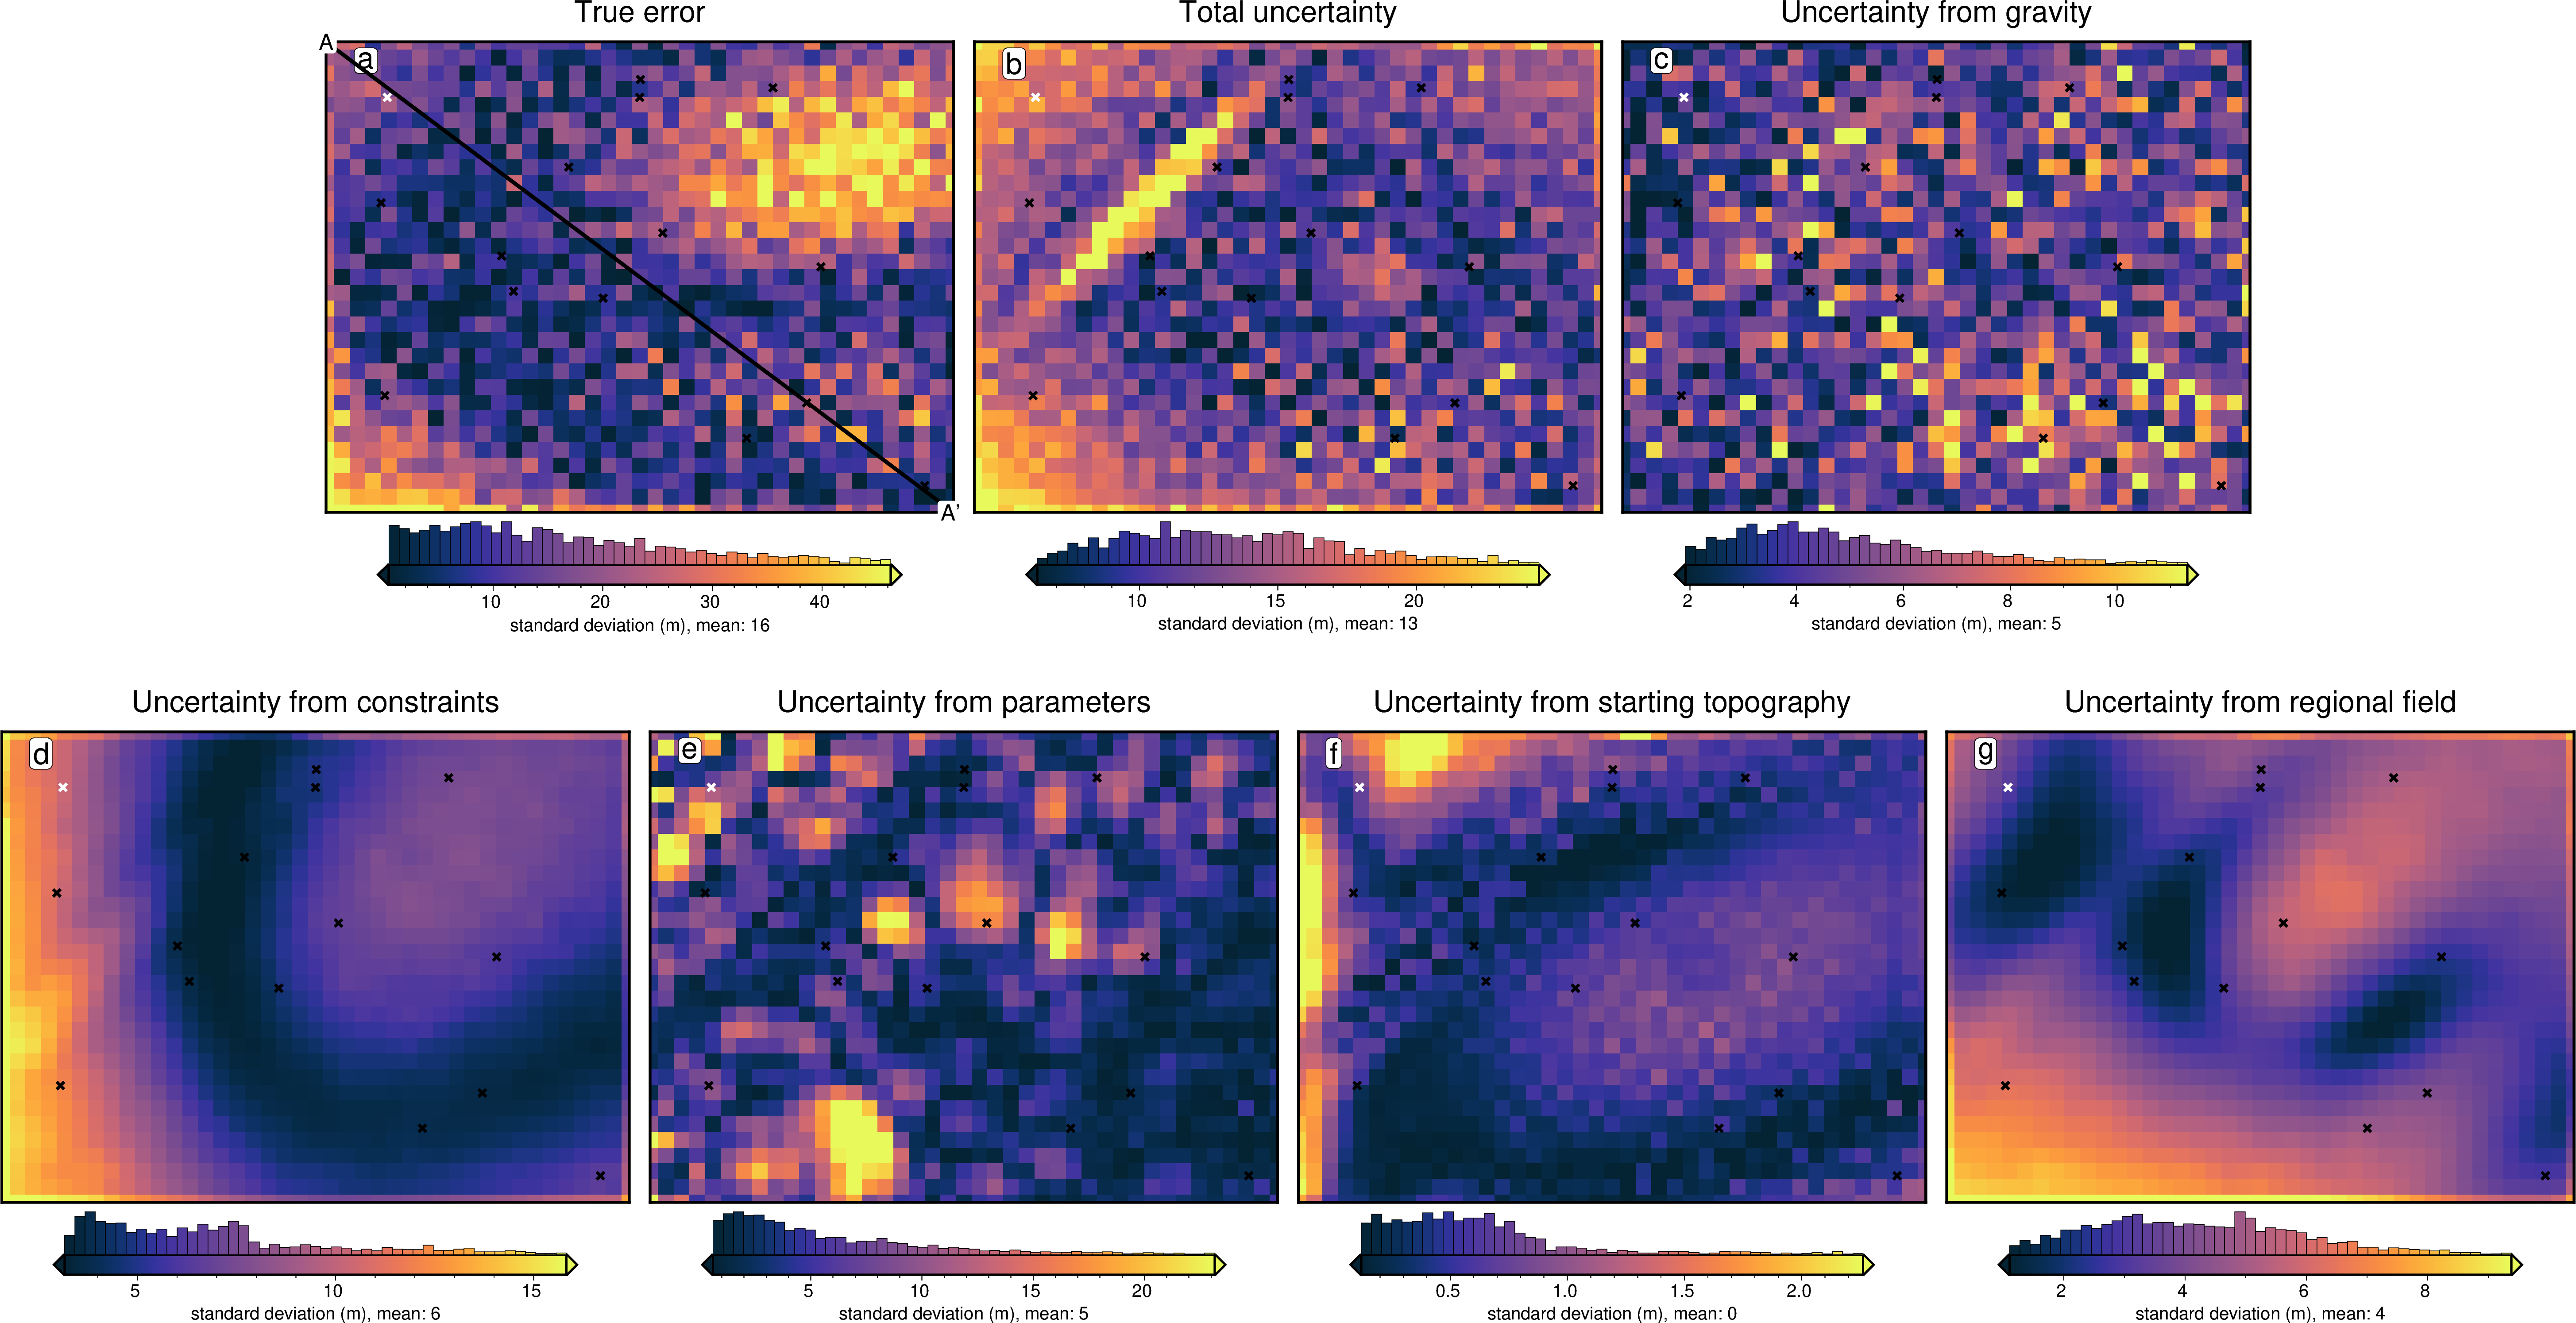

In [33]:
titles = [
    "True error",
    "Total uncertainty",
    "Uncertainty from gravity",
    "Uncertainty from constraints",
    "Uncertainty from parameters",
    "Uncertainty from starting topography",
    "Uncertainty from regional field",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - true_topography))

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 3:
        origin_shift = "both_shift"
        xshift_amount = -2.5
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        # cpt_lims=polar_utils.get_min_max(grids[0], robust=True,),
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points.easting,
        y=constraint_points.northing,
        style="x.2c",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profile location, and endpoints on map
        start = [region[0], region[3]]
        stop = [region[1], region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

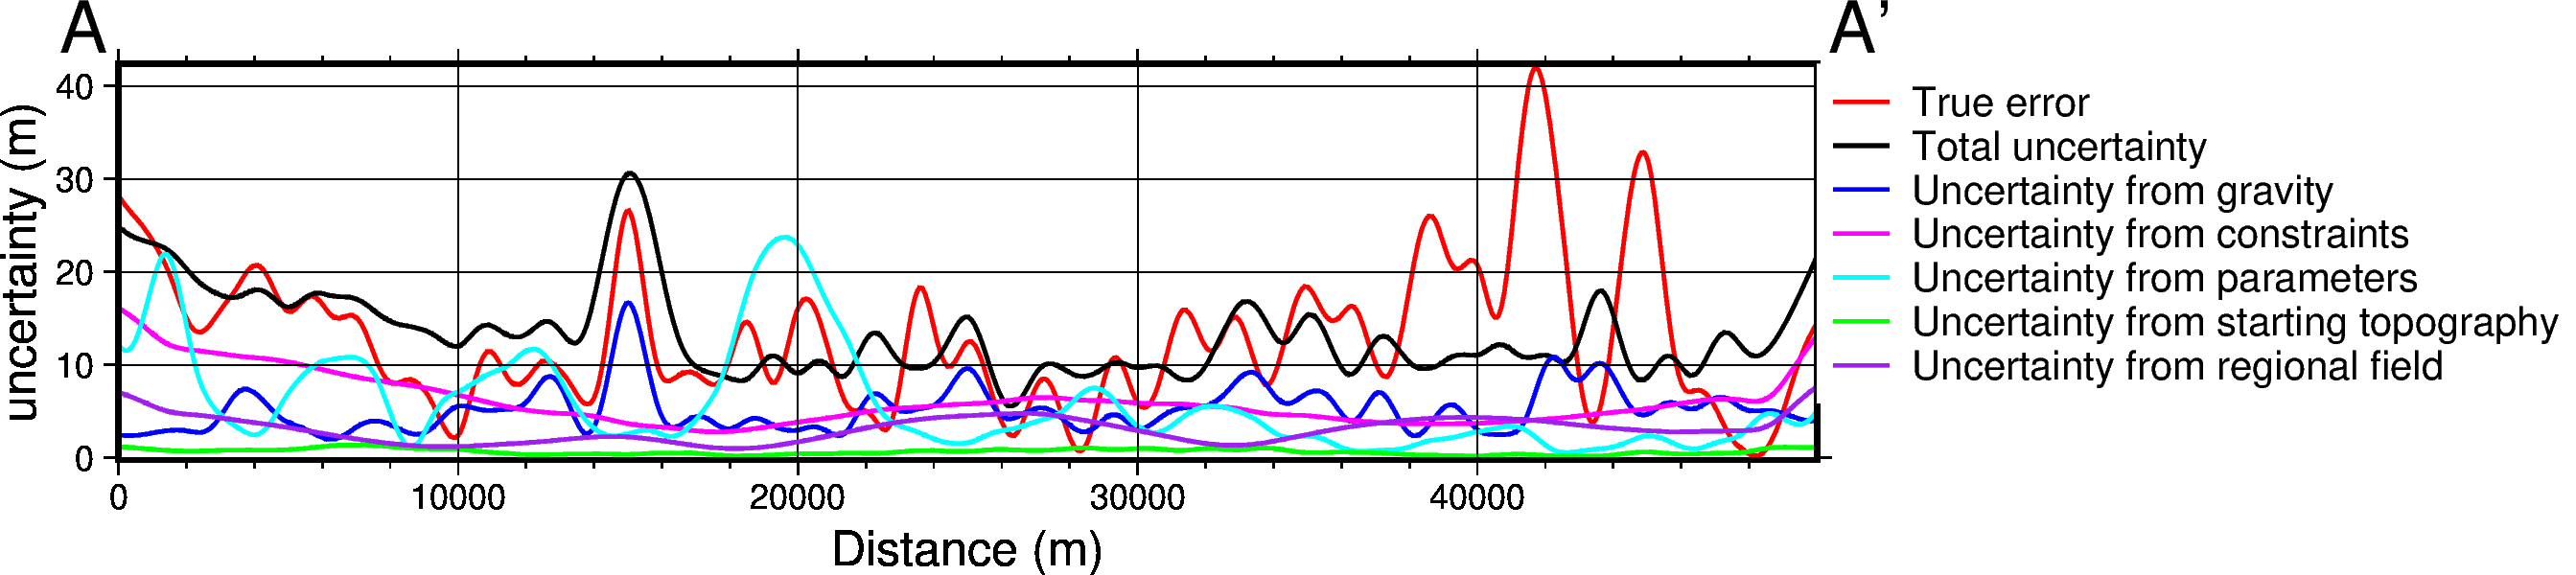

In [34]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[region[0], region[3]],
    stop=[region[1], region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()